# Output visualization for USA scenarios

In [1]:
import pandas as pd
import numpy as np
import os, sys, site, math, time, pickle, gzip
from glob import glob
from tqdm.notebook import tqdm, trange
tqdm.pandas()
import matplotlib as mpl
import matplotlib.pyplot as plt

site.addsitedir(os.path.expanduser('~/github/zephyr'))
import zephyr
projpath = zephyr.settings.projpath

### Format plots and tables
zephyr.plots.plotparams()
from matplotlib.ticker import (
    AutoMinorLocator, MultipleLocator, AutoLocator, PercentFormatter)
pd.options.display.max_columns = 200
pd.options.display.max_rows = 24

%config InlineBackend.figure_format = 'retina'

/Users/patrickbrown/anaconda3/lib/python3.7/site-packages/tqdm/std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


# Load data

In [2]:
dfout = pd.read_csv(
    os.path.join(projpath,'results','USApACpDC-capacity.csv'),
    index_col=[0,1])
dictout = {int(i): dfout[i] for i in dfout.columns}

In [3]:
dfops = pd.read_csv(
    os.path.join(projpath,'results','USApACpDC-operation.csv.gz'),
    index_col=[0], header=[0,1], parse_dates=True
)
dictops = {int(i): dfops[i] for i in dfops.T.reset_index(level=0).level_0.unique()}

In [4]:
### States and intrazones
cases = pd.read_excel(
    os.path.join(projpath,'cases-USApACpDC.xlsx'), 
    index_col='case', sheet_name='runs',
    dtype={'include_hydro_res':bool, 'include_hydro_ror':bool,
           'include_gas':bool, 'build_ac':bool, 'build_dc': str,
           'include_phs':int, 'build_phs':str, 'gasprice': str,
           'include_nuclear':int, 'build_nuclear':str,
           'bins_pv':str, 'bins_wind':str}
)
caseyear = dict(zip(cases.index.values,cases.vreyears.values))
dfstate = pd.read_excel(
    os.path.join(projpath,'cases-USApACpDC.xlsx'), 
    sheet_name='state',
    index_col=0, header=[0,1],
)
states = dfstate.index.values
### Economic and simulation assumptions
defaults = zephyr.cpm.Defaults(os.path.join(projpath,'io','generator_fuel_assumptions.xlsx'))

In [5]:
### Rename some cases
notesrenamer = {
    'inflex nuclear_2030': 'inflex nuclear_$6180/kW',
    'noflex nuclear_2030': 'noflex nuclear_$6180/kW',
    'midflex nuclear_2030': 'midflex nuclear_$6180/kW',
    'fullflex nuclear_2030': 'fullflex nuclear_$6180/kW',
    'superflex nuclear_2030': 'superflex nuclear_$6180/kW',
    'inflex nuclear_vogtle': 'inflex nuclear_$12000/kW',
    'noflex nuclear_vogtle': 'noflex nuclear_$12000/kW',
    'midflex nuclear_vogtle': 'midflex nuclear_$12000/kW',
    'fullflex nuclear_vogtle': 'fullflex nuclear_$12000/kW',
    'superflex nuclear_vogtle': 'superflex nuclear_$12000/kW',
}
cases['notes'] = cases.notes.map(lambda x: notesrenamer.get(x,x))

In [6]:
# hours = sum([len(dictops[i]) for i in range(0,7)])
# [len(dictops[i]) for i in range(0,7)]
casehours = {}
for case in cases.index:
    if cases.loc[case,'vreyears'] in ['2007','2008','2009','2010','2011','2012']:
        casehours[case] = 8760
    elif cases.loc[case,'vreyears'] == '2013':
        casehours[case] = 8736
    elif cases.loc[case,'vreyears'] == '2007,2008,2009,2010,2011,2012,2013':
        casehours[case] = 8760*6 + 8736

In [7]:
bas = list(dfstate['area']['ba'].unique())
# loadmean = dictout[1]['values']['loadsum'] / 8760
tz = 'Etc/GMT+6'

In [8]:
opindex = pd.date_range(
    '2007-01-01','2013-12-31',closed='left',freq='H',tz=tz)
opindex = [i for i in opindex if not ((i.month==2) and (i.day==29))]

In [9]:
dfregion = pd.read_excel(
    os.path.join(projpath,'cases-USApACpDC.xlsx'), 
    sheet_name='ba',
    index_col=0, header=[0,1],
    dtype={('bins_pv','ba'):str,('bins_wind','ba'):str},
).xs('ba',axis=1,level=1)
# dfregion

# Set saver

In [10]:
save = True
save = False
figpath = os.path.join(projpath,'results','figs','USApACpDC','')
os.makedirs(figpath,exist_ok=True)
figsize = (13/48*50,2) ### fixed width

# Plot everything

In [11]:
### Original ordering
years = list(range(2007,2014))
labels = cases.notes.drop_duplicates().values
yearindices, barindex = {}, {}
for label in labels:
    df = cases.loc[cases.notes==label]
    yearindices[label] = df.index[:7].tolist()
    barindex[label] = int(df.index[-1])
    
alllabels = cases.loc[
    (cases.vreyears=='2007,2008,2009,2010,2011,2012,2013'),
    'notes']

In [12]:
### Order by hand, ordered roughly by cost within category
labels = [
    ### Default
    'default',
    ### Transmission
    'no existing transmission',
    '2x transmission cost',
    '2x interconnection cost',
    'no new dc',
    '5x transmission cost',
    '5x interconnection cost',
    'no new ac or dc',
    ### Existing capacity, nuclear
    'existing PHS',
    'noflex nuclear_existing',   
    'noflex nuclear_$12000/kW', ### renamed 'vogtle' to '$12000/kW'
    'noflex nuclear_$6180/kW', 
    'midflex nuclear_$6180/kW', 
    'fullflex nuclear_$6180/kW',
    'fullflex nuclear_$5000/kW',
    'fullflex nuclear_$4000/kW',
    ### VRE availability
    '0.5x VRE available',
    '0.2x VRE available',
    '0.1x VRE available',
    ### Prices
    '2030low VRE&S prices',
    'LDES ($5/kWh)',
    '3% wacc',
    'LDES ($50/kWh)',
    'EIA regional cost scalers',
    '6% wacc',
    '5x Li-ion cost',
    '2018 VRE&S prices',
    ### Wind assumptions
    'Leitwind:LTW90/1000',
    'Suzlon:S120/2100',
    'WTKclass3',
    'Vestas:V110/2000',
    'WTKclass2',
    ### Demand assumptions
    'demand Reference_Rapid',
    'demand Medium_Moderate',
    'demand High_Rapid',
    'demand High_Slow',
    'demand 2050_High_Slow',
    ### Reliability
    '$9000/MWh load shedding', 
    '20% reserves',
    '50% reserves',
    '100% reserves',
    ### Nonzero carbon
    '2030mid VRES, 2030low gas',
    '2030mid VRES, 2030mid gas',
    '2030mid VRES, 2030high gas',
    '2030low VRES, 2030low gas',
    '2018 VRES, 2030low gas',
    '2030low VRES, 2030high gas',
    '2018 VRES, 2030high gas',
]

                       default: 27.1h
      no existing transmission: 25.4h
          2x transmission cost: 41.6h
       2x interconnection cost: 28.7h
                     no new dc: 19.3h
          5x transmission cost: 30.1h
       5x interconnection cost: 39.1h
               no new ac or dc: 9.8h
                  existing PHS: 41.6h
       noflex nuclear_existing: 32.4h
      noflex nuclear_$12000/kW: 45.3h
       noflex nuclear_$6180/kW: 31.8h
      midflex nuclear_$6180/kW: 97.1h
     fullflex nuclear_$6180/kW: 95.1h
     fullflex nuclear_$5000/kW: 52.0h
     fullflex nuclear_$4000/kW: 33.5h
            0.5x VRE available: 36.9h
            0.2x VRE available: 24.7h
            0.1x VRE available: 18.6h
          2030low VRE&S prices: 41.1h
                 LDES ($5/kWh): 512.4h
                       3% wacc: 46.8h
                LDES ($50/kWh): 72.1h
     EIA regional cost scalers: 43.8h
                       6% wacc: 24.8h
                5x Li-ion cost: 33.6h
            

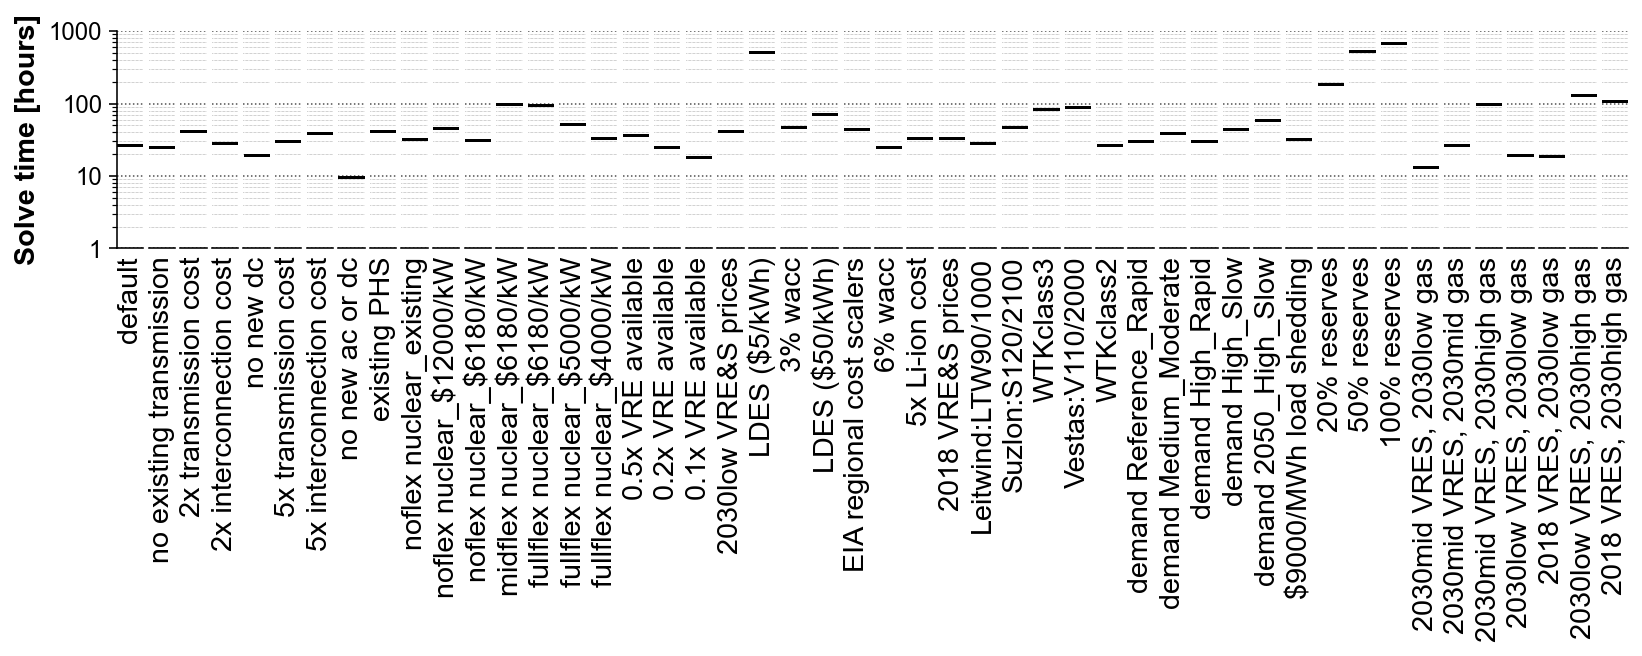

In [13]:
plt.close()
f,ax=plt.subplots(1,len(labels), figsize=figsize, sharex=True, sharey='row')
for col, label in enumerate(labels):
    ### Formatting
    ax[col].set_xticks([])
    ax[col].set_xticklabels([])
    ax[col].set_xlabel(label, rotation=90, weight='normal')
    ax[col].grid(which='major', axis='y', c='0.3', ls=':', lw=0.75)
    ax[col].grid(which='minor', axis='y', c='0.3', ls=':', lw=0.25)
    ### Bar
    try:
        val = dictout[barindex[label]]['values']['time_solve']/3600
        print('{:>30}: {:.1f}h'.format(label, val))
    except KeyError:
        continue
    ax[col].plot([2007,2013], [val]*2, color='k', lw=1.5,)
ax[0].set_ylim(1,1000)
ax[0].set_ylabel('Solve time [hours]')
plt.yscale('log')
ax[0].yaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
for col in range(1,len(labels)):
    zephyr.plots.despine(ax[col],left=False)
zephyr.plots.despine(ax[0])
if save:
    savename = 'sensitivity-runtime-7y'
    plt.savefig(figpath+savename+'.png')
    plt.savefig(figpath+savename+'.pdf')
plt.show()

default 12.075611 20.807721
no existing transmission 9.868919 17.497701
2x transmission cost 12.075611 20.807721
2x interconnection cost 12.075611 20.807721
no new dc 11.707826 20.256051
5x transmission cost 12.075611 20.807721
5x interconnection cost 12.075611 20.807721
no new ac or dc 10.236686 18.049371
existing PHS 14.098434 24.179078
noflex nuclear_existing 12.749889 23.504767
noflex nuclear_$12000/kW 12.749889 23.504756
noflex nuclear_$6180/kW 12.749889 23.504756
midflex nuclear_$6180/kW 12.749889 23.504756
fullflex nuclear_$6180/kW 12.749889 23.504756
fullflex nuclear_$5000/kW 12.749889 23.504756
fullflex nuclear_$4000/kW 12.749889 23.504756
0.5x VRE available 12.075611 20.807721
0.2x VRE available 12.075611 20.807721
0.1x VRE available 12.075611 20.807721
2030low VRE&S prices 12.075611 20.807721
LDES ($5/kWh) 12.075611 20.807721
3% wacc 12.075611 20.807721
LDES ($50/kWh) 12.075611 20.807721
EIA regional cost scalers 12.075611 20.807721
6% wacc 12.075611 20.807721
5x Li-ion cost

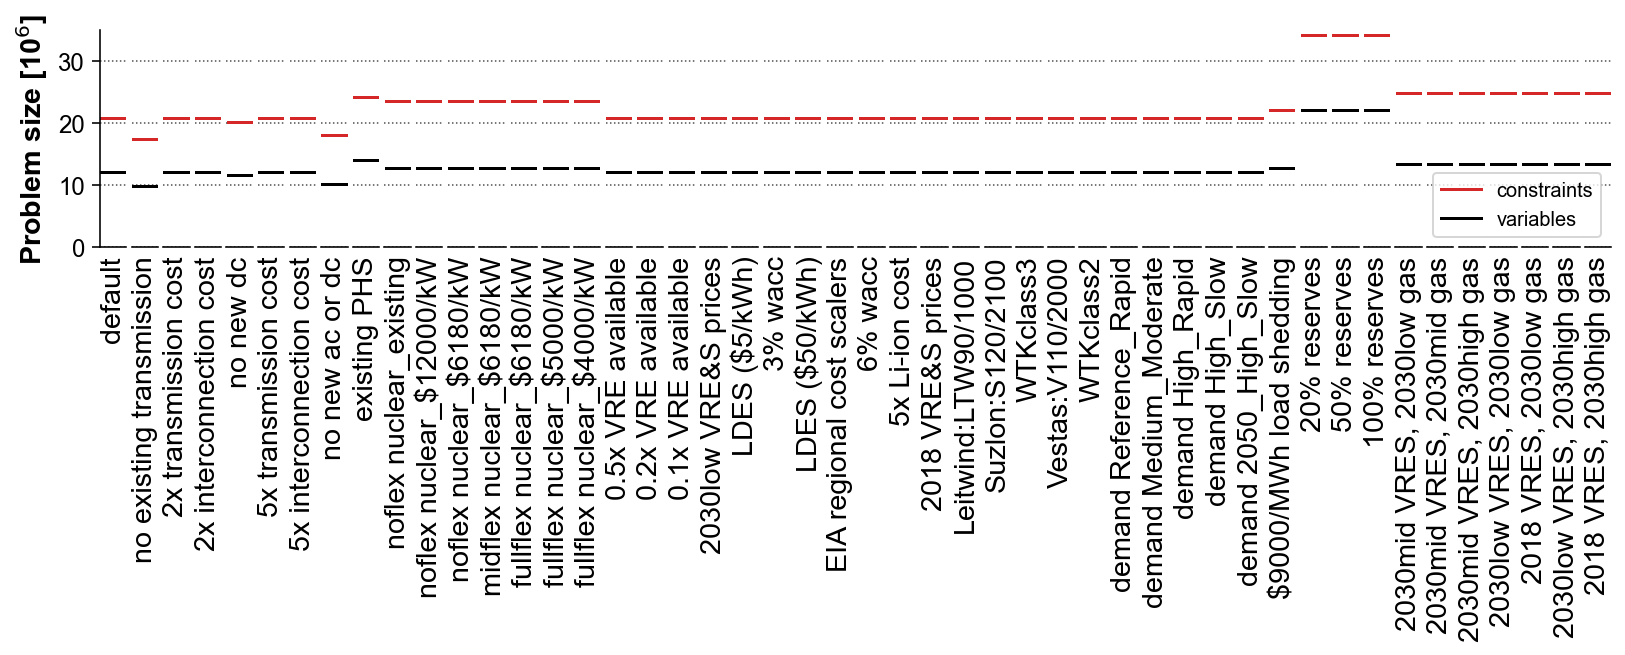

In [14]:
plt.close()
f,ax=plt.subplots(1,len(labels), figsize=figsize, sharex=True, sharey='row')
for col, label in enumerate(labels):
    ### Formatting
    ax[col].set_xticks([])
    ax[col].set_xticklabels([])
    ax[col].set_xlabel(label, rotation=90, weight='normal')
    ax[col].grid(which='major', axis='y', c='0.3', ls=':', lw=0.75)
    ax[col].grid(which='minor', axis='y', c='0.3', ls=':', lw=0.25)
    ### Bar
    try:
        var = dictout[barindex[label]]['values']['variables']/1E6
        con = dictout[barindex[label]]['values']['constraints']/1E6
        print(label, var, con)
    except KeyError:
        continue
    ax[col].plot([2007,2013], [con]*2, color='C3', lw=1.5, label='constraints')
    ax[col].plot([2007,2013], [var]*2, color='k', lw=1.5, label='variables')
ax[0].set_ylim(0,35)
ax[0].set_ylabel('Problem size ['r'10$^6$'']')
ax[-1].legend(loc='lower right')
for col in range(1,len(labels)):
    zephyr.plots.despine(ax[col],left=False)
zephyr.plots.despine(ax[0])
if save:
    savename = 'sensitivity-variables,constraints-7y'
    plt.savefig(figpath+savename+'.png')
    plt.savefig(figpath+savename+'.pdf')
plt.show()

default: 2.64
no existing transmission: 2.65
2x transmission cost: 2.87
2x interconnection cost: 2.79
no new dc: 3.30
5x transmission cost: 3.29
5x interconnection cost: 3.03
no new ac or dc: 4.31
existing PHS: 2.65
noflex nuclear_existing: 2.17
noflex nuclear_$12000/kW: 2.64
noflex nuclear_$6180/kW: 2.08
midflex nuclear_$6180/kW: 1.60
fullflex nuclear_$6180/kW: 1.61
fullflex nuclear_$5000/kW: 1.01
fullflex nuclear_$4000/kW: 0.77
0.5x VRE available: 2.89
0.2x VRE available: 3.15
0.1x VRE available: 4.37
2030low VRE&S prices: 4.01
LDES ($5/kWh): 36.84
3% wacc: 2.66
LDES ($50/kWh): 4.32
EIA regional cost scalers: 2.86
6% wacc: 2.70
5x Li-ion cost: 0.05
2018 VRE&S prices: 1.00
Leitwind:LTW90/1000: 2.38
Suzlon:S120/2100: 3.51
WTKclass3: 3.97
Vestas:V110/2000: 4.25
WTKclass2: 4.33
demand Reference_Rapid: 2.60
demand Medium_Moderate: 2.78
demand High_Rapid: 2.79
demand High_Slow: 3.02
demand 2050_High_Slow: 3.64
$9000/MWh load shedding: 1.48
20% reserves: 2.56
50% reserves: 2.72
100% reserve

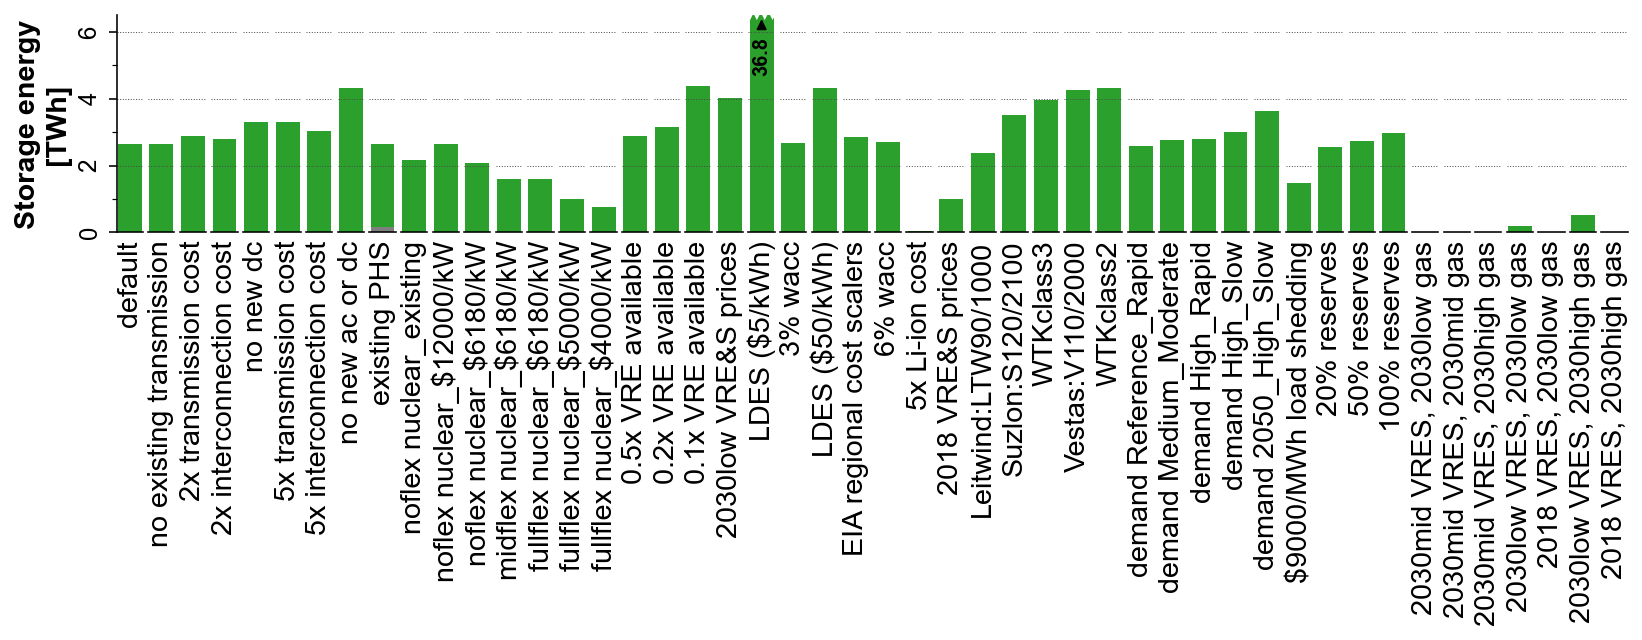

In [15]:
###### Include existing PHS
years = list(range(2007,2014))
frameon = False
color = 'C2'
alpha = 1#0.7

plt.close()
f,ax=plt.subplots(1,len(labels), figsize=figsize, sharex=True, sharey='row')
for col, label in enumerate(labels):
    ### Formatting
    ax[col].set_xticks([])
    ax[col].set_xticklabels([])
    ax[col].set_xlabel(label, rotation=90, weight='normal')
    ax[col].grid(which='major', axis='y', c='0.3', ls=':', lw=0.5)
    ### Bar
    try:
        val = dictout[barindex[label]]['cap'][
            [c for c in dictout[barindex[label]]['cap'].index if c.endswith('_E')]
        ].sum() / 1000
    except KeyError:
        continue
    ax[col].bar([2010], val, color=color, alpha=alpha, width=7)
    if label == 'existing PHS':
        phsval = dictout[barindex[label]].loc['cap',['PHS_{}_E'.format(ba) for ba in bas]].sum() / 1000
        ax[col].bar([2010], phsval, color=plt.cm.tab20(14), alpha=1, width=7)
    print('{}: {:.2f}'.format(label, val))
    ### Out-of-scale labels
    outlabels = ['LDES ($5/kWh)','LDES ($10/kWh)',
                 'LDES ($20/kWh)',
                 '200% reserves','500% reserves']
    if label in outlabels:
        ax[col].annotate(
            '▼▼▼▼',
            xy=(0.5,1.0035), xycoords='axes fraction', ha='center', va='top',
            color='w', fontsize=4)
        ax[col].annotate(
            '{:.1f}'.format(val), xy=(0.5,1), xytext=(0.5,0.9),
            xycoords='axes fraction', weight='bold',
            ha='center', va='top', rotation=90,
            arrowprops={'arrowstyle':'-|>', 'color':'k'}, 
        )
    
### Formatting
ax[0].yaxis.set_major_locator(MultipleLocator(20))
ax[0].yaxis.set_minor_locator(AutoMinorLocator(2))
l = np.arange(0,32,4)
l = np.arange(0,16,2)
ax[0].set_yticks(l)
ax[0].set_yticklabels(l, rotation=90, va='center')
ax[0].set_ylabel('Storage energy\n[TWh]')
ax[0].set_ylim(0,6.5)
for col in range(1,len(labels)):
    zephyr.plots.despine(ax[col],left=False)
zephyr.plots.despine(ax[0])
if save:
    savename = 'sensitivity-storage_twh-bars'
    plt.savefig(figpath+savename+'.png')
    plt.savefig(figpath+savename+'.pdf')
plt.show()

## Transmission (GW-km)

In [16]:
###### Transmission inputs
### Load connectivity matrix
dftransin = pd.read_csv(
    os.path.join(projpath,'io','transmission','reeds-transmission-GW-state.csv'),
    index_col=[0,1])

### Load distance matrix
dfdistance_state = pd.read_csv(
    os.path.join(projpath,'io','transmission','state-distance-urbancentroid-km.csv'),
    index_col=0)
dfdistance = pd.read_csv(
    os.path.join(projpath,'io','transmission','ba-distance-urbancentroid-km.csv'),
    index_col=0)

###### Transmission loss rates
loss_distance = {'ac': 0.01/1.60934/100, 'dc': 0.005/1.60934/100}

default–––––––––––––––––––––––:  92.6 DC, 177.8 AC_intra, 392.2 AC_inter
no existing transmission––––––:  85.9 DC, 170.7 AC_intra, 382.9 AC_inter
2x transmission cost––––––––––:  67.2 DC, 162.8 AC_intra, 314.5 AC_inter
2x interconnection cost–––––––:  88.8 DC, 173.5 AC_intra, 414.1 AC_inter
no new dc–––––––––––––––––––––:   8.3 DC, 125.1 AC_intra, 328.9 AC_inter
5x transmission cost––––––––––:  50.6 DC, 149.8 AC_intra, 270.1 AC_inter
5x interconnection cost–––––––:  86.0 DC, 174.3 AC_intra, 409.0 AC_inter
no new ac or dc–––––––––––––––:   8.3 DC, 127.6 AC_intra, 207.0 AC_inter
existing PHS––––––––––––––––––:  92.9 DC, 177.9 AC_intra, 393.8 AC_inter
noflex nuclear_existing–––––––:  70.2 DC, 138.3 AC_intra, 333.4 AC_inter
noflex nuclear_$12000/kW––––––:  92.6 DC, 177.8 AC_intra, 392.2 AC_inter
noflex nuclear_$6180/kW–––––––:  83.2 DC, 160.8 AC_intra, 346.9 AC_inter
midflex nuclear_$6180/kW––––––:  73.0 DC, 127.3 AC_intra, 285.3 AC_inter
fullflex nuclear_$6180/kW–––––:  71.1 DC, 126.9 AC_

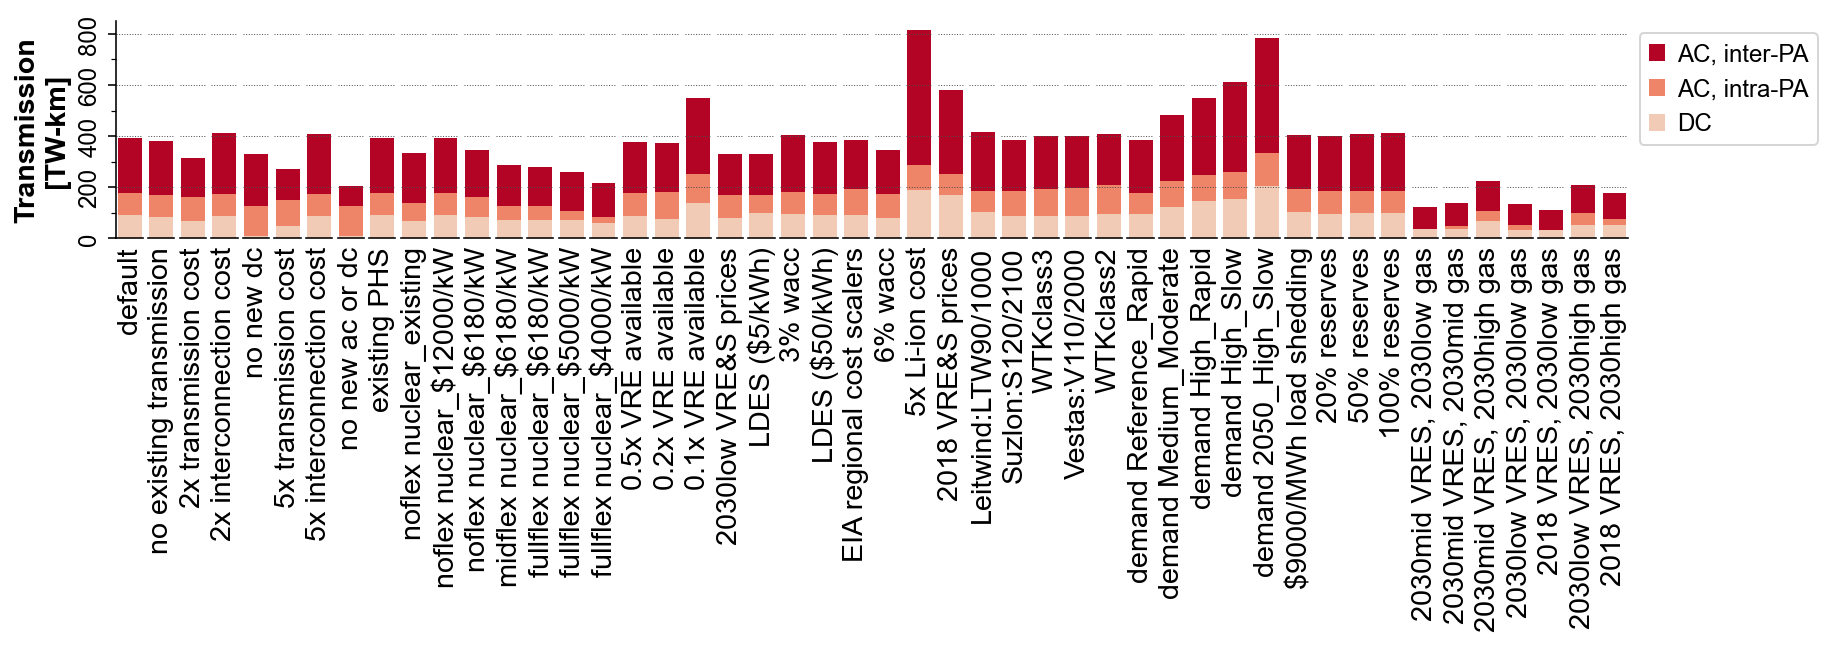

In [17]:
years = list(range(2007,2014))
alpha = 1
frameon = False
bc = {'ac_interba': plt.cm.coolwarm(1.0), 'ac_intraba': plt.cm.coolwarm(0.8), 
      'dc': plt.cm.coolwarm(0.6)}
legendlabels = {'dc': 'DC (inter-PA)', 'ac_intraba': 'AC (intra-PA)',
                'ac_interba': 'AC (inter-PA)'}
legendlabels = {'dc': 'DC', 'ac_intraba': 'AC, intra-PA',
                'ac_interba': 'AC, inter-PA'}

##### Transmission scalers
transcost_adder = pd.read_csv(
    os.path.join(projpath,'io','transmission','transmission-adder-{}.csv'.format(
        cases.loc[case,'intralevel_transcost'])),
    index_col=0
)
### $/kW-km/yr
newac = zephyr.cpm.Line('a', 'b', defaults=defaults, voltage=500,)
newac_cost_annual = (
    newac.cost_distance * zephyr.cpm.crf(newac.wacc, newac.lifetime)
)
### 1000 GW-km / GW VRE
intraba_adder = (
    transcost_adder.transcost_ac_annual 
    / (newac_cost_annual * 1000) 
    / transcost_adder.cap_vre
)

plt.close()
f,ax=plt.subplots(1,len(labels), figsize=figsize, sharex=True, sharey='row')
for col, label in enumerate(labels):
    ### Formatting
    ax[col].set_xticks([])
    ax[col].set_xticklabels([])
    ax[col].set_xlabel(label, rotation=90, weight='normal')
    ax[col].grid(which='major', axis='y', c='0.3', ls=':', lw=0.5)
    try:
        lines = [c for c in dictout[barindex[label]]['cap'].index.values if '|' in c]
    except KeyError:
        continue
    lines = {
        x: [c for c in lines if c.endswith(x)]
        for x in ['dc_old','ac_old','dc_new','ac_new']
    }
    df = pd.Series({
        line: 
        (dictout[barindex[label]]['cap'][lines[line]].index.map(
            lambda x: dfdistance.loc[x.split('|')[0], x.split('_')[0].split('|')[1]]
         ).values * dictout[barindex[label]]['cap'][lines[line]]
        ).sum() / 1000
        for line in lines
    })
    dfplot = pd.Series({'dc':df[['dc_old','dc_new']].sum(),
                        'ac_intraba': 0,
                        'ac_interba': df[['ac_old','ac_new']].sum()})
    ### Add the intra-PA inter-state transmission associated with new VRE capacity and
    ### subtract the prexisting intra-PA inter-state transmission
    dfplot['ac_intraba'] = sum(
        [dictout[barindex[label]]['cap'][
            [c for c in dictout[barindex[label]]['cap'].index 
             if (c.startswith('PV_{}'.format(ba)) or c.startswith('Wind_{}'.format(ba)))]
         ].sum() * intraba_adder[ba]
         for ba in bas
        ]
    )
    dfplot = dfplot.cumsum()
    ### Plot it
    for line in ['ac_interba','ac_intraba','dc']:
        ax[col].bar([2010], dfplot[line], color=bc[line], alpha=alpha, width=7)
#     print('{:–<30}: {:.2f}'.format(label, dfplot.iloc[-1]))
    print('{:–<30}: {:>5.1f} DC, {:>5.1f} AC_intra, {:>5.1f} AC_inter'.format(
        label, *dfplot.values.tolist()))
#     print('{:–<30}: {:.2f}'.format(label, dfplot.loc['ac_new'] / dfplot.loc['ac_old']))
    
### Formatting
ax[0].yaxis.set_major_locator(MultipleLocator(100))
ax[0].yaxis.set_minor_locator(AutoMinorLocator(2))
l = np.arange(0,2001,200) ### or 100
ax[0].set_yticks(l)
ax[0].set_yticklabels(l, rotation=90, va='center')
ax[0].set_ylabel('Transmission\n[TW-km]')
ax[0].set_ylim(0,850)
for col in range(1,len(labels)):
    zephyr.plots.despine(ax[col],left=False)
zephyr.plots.despine(ax[0])
### Legend (by hand)
handles = [
    mpl.patches.Patch(facecolor=bc[i], edgecolor='none', label=legendlabels[i])
    for i in bc
]
leg = ax[-1].legend(
    handles=handles,loc='upper left',bbox_to_anchor=(1,1),fontsize='large',
    frameon=True, handletextpad=0.5, handlelength=0.65,
)
if save:
    savename = 'sensitivity-transmission-7yearbars'
    plt.savefig(figpath+savename+'.png')
    plt.savefig(figpath+savename+'.pdf')
plt.show()

## Capacity mix

In [18]:
colors = {
    ('Hydro_Res',''): plt.cm.tab20(19),
    ('Hydro_ROR',''): plt.cm.tab20(9),
    ('PHS',''): plt.cm.tab20(15),
    ('Nuclear','_old'): plt.cm.tab20(13),
#     ('Nuclear','_new'): plt.cm.tab20(12),
    ('Nuclear','_new'): plt.cm.tab20(13),
    ('Wind',''): plt.cm.tab20(0),
    ('PV',''): plt.cm.tab20(2),
    ('Stor','_P'): plt.cm.tab20(4),
    ('CCGT',''): plt.cm.tab20(10),
    ('OCGT',''): plt.cm.tab20(16),
}
colorlist = [colors[c] for c in colors]

### 7-year solutions

                       default:  1038.6 GW PV,  1186.8 GW wind,     0.0 GW nuclear
      no existing transmission:  1043.3 GW PV,  1183.7 GW wind,     0.0 GW nuclear
          2x transmission cost:  1074.0 GW PV,  1159.4 GW wind,     0.0 GW nuclear
       2x interconnection cost:  1061.7 GW PV,  1166.4 GW wind,     0.0 GW nuclear
                     no new dc:  1155.9 GW PV,  1297.8 GW wind,     0.0 GW nuclear
          5x transmission cost:  1164.1 GW PV,  1079.6 GW wind,     0.0 GW nuclear
       5x interconnection cost:  1105.3 GW PV,  1168.6 GW wind,     0.0 GW nuclear
               no new ac or dc:  1095.3 GW PV,  1558.4 GW wind,     0.0 GW nuclear
                  existing PHS:  1038.7 GW PV,  1186.5 GW wind,     0.0 GW nuclear
       noflex nuclear_existing:   905.3 GW PV,   910.3 GW wind,     0.0 GW nuclear
      noflex nuclear_$12000/kW:  1038.6 GW PV,  1186.8 GW wind,     0.0 GW nuclear
       noflex nuclear_$6180/kW:   908.0 GW PV,  1037.6 GW wind,    70.3 GW nuclear
    

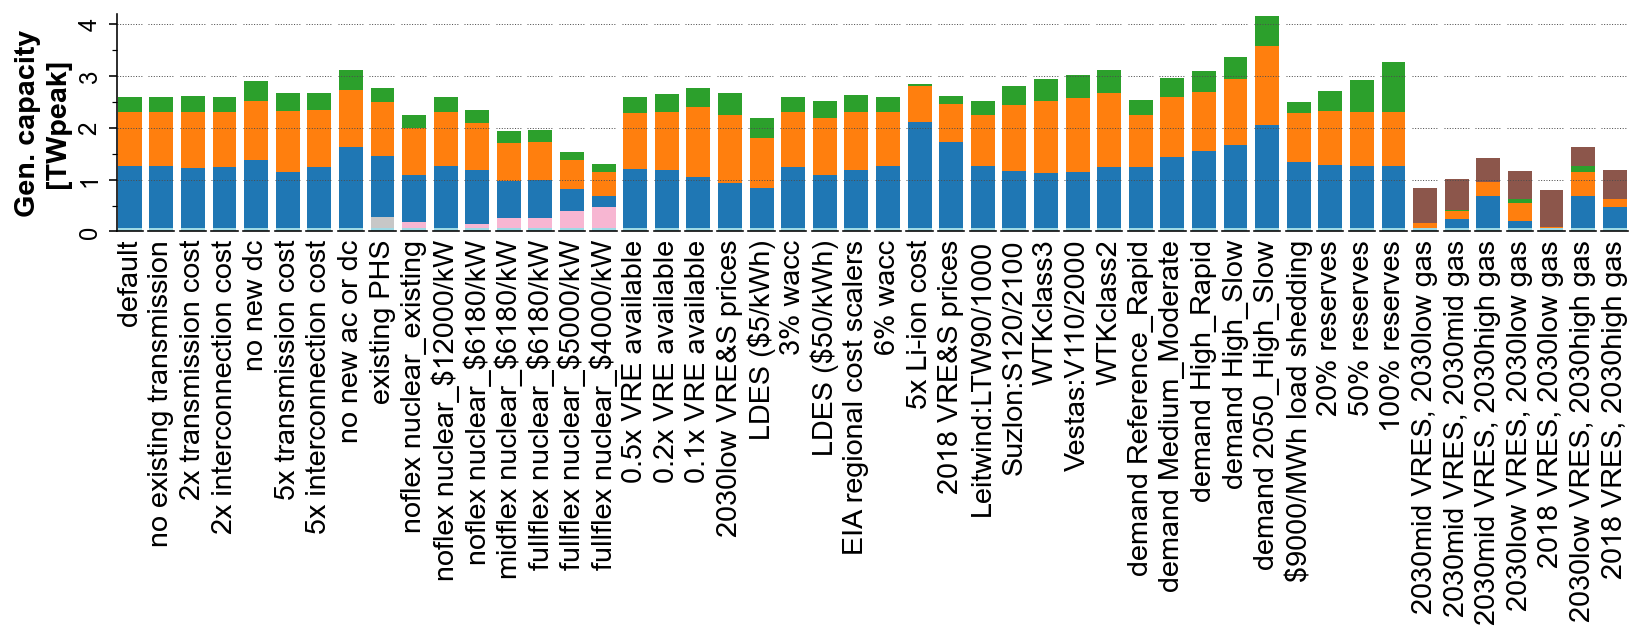

In [19]:
years = list(range(2007,2014))
frameon = False
color = 'C7'
alpha = 1

plt.close()
f,ax=plt.subplots(1,len(labels), figsize=figsize, sharex=True, sharey='row')
for col, label in enumerate(labels):
    case = barindex[label]
    gens = dictout[case]['cap'].index.values
    dfplot = pd.Series({
                '{}{}'.format(*gen): 
                dictout[case]['cap'][
                    [c for c in gens if c.startswith(gen[0]) and c.endswith(gen[1])]
                ].sum()
                for gen in colors
            }) / 1000
    ax[col].bar(
        x=[2010]*len(dfplot), 
        height=dfplot.values, 
        bottom=dfplot.cumsum().shift(1).fillna(0),
        width=7, color=colorlist,
    )
    ### Log
#     print('{}: {:.2f}'.format(label, dfplot.sum()))
#     print('{:–<30}: {:.1f}'.format(label, dfplot[['Wind','PV']].sum()*1000))
    print('{:>30}: {:>7.1f} GW PV, {:>7.1f} GW wind, {:>7.1f} GW nuclear'.format(
        label, dfplot['PV']*1000, dfplot['Wind']*1000, dfplot['Nuclear_new'] * 1000))

### Formatting
for col, label in enumerate(labels):
    ax[col].set_xticks([])
    ax[col].set_xticklabels([])
    ax[col].set_xlabel(label, rotation=90, weight='normal')
    ax[col].grid(which='major', axis='y', c='0.3', ls=':', lw=0.5)
    
ax[0].yaxis.set_major_locator(MultipleLocator(1))
ax[0].yaxis.set_minor_locator(AutoMinorLocator(2))
l = np.arange(0,6,1) ### or 0.5
ax[0].set_yticks(l)
ax[0].set_yticklabels(l, rotation=90, va='center')
ax[0].set_ylabel('Gen. capacity\n[TWpeak]')
ax[0].set_ylim(0,4.2)
for col in range(1,len(labels)):
    zephyr.plots.despine(ax[col],left=False)
zephyr.plots.despine(ax[0])
if save:
    savename = 'sensitivity-capacity-7yearbar'
    plt.savefig(figpath+savename+'.png')
    plt.savefig(figpath+savename+'.pdf')
plt.show()

### Side cases

default–––––––––––––––––––––––: 0.0 GW
noflex nuclear_existing–––––––: 0.0 GW
inflex nuclear_existing–––––––: 0.0 GW
noflex nuclear_$12000/kW––––––: 0.0 GW
inflex nuclear_$12000/kW––––––: 0.0 GW
midflex nuclear_$12000/kW–––––: 0.0 GW
fullflex nuclear_$12000/kW––––: 0.0 GW
superflex nuclear_$12000/kW–––: 0.0 GW
noflex nuclear_$6180/kW–––––––: 70.3 GW
inflex nuclear_$6180/kW–––––––: 125.6 GW
midflex nuclear_$6180/kW––––––: 192.2 GW
fullflex nuclear_$6180/kW–––––: 190.4 GW
superflex nuclear_$6180/kW––––: 190.4 GW
noflex nuclear_$5000/kW–––––––: 314.2 GW
inflex nuclear_$5000/kW–––––––: 343.1 GW
midflex nuclear_$5000/kW––––––: 340.4 GW
fullflex nuclear_$5000/kW–––––: 315.3 GW
superflex nuclear_$5000/kW––––: 315.2 GW
noflex nuclear_$4000/kW–––––––: 400.3 GW
inflex nuclear_$4000/kW–––––––: 421.4 GW
midflex nuclear_$4000/kW––––––: 416.2 GW
fullflex nuclear_$4000/kW–––––: 402.5 GW
superflex nuclear_$4000/kW––––: 402.6 GW


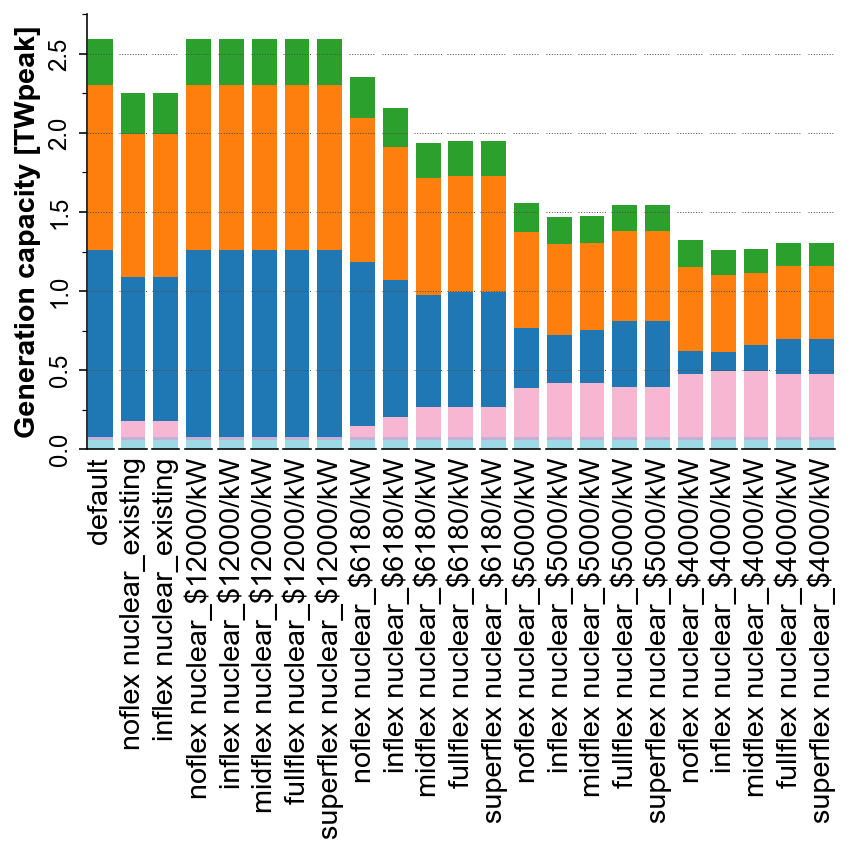

In [20]:
###### Subset of cases
colors = {
    ('Hydro_Res',''): plt.cm.tab20(19),
    ('Hydro_ROR',''): plt.cm.tab20(9),
    ('PHS',''): plt.cm.tab20(15),
    ('Nuclear','_old'): plt.cm.tab20(13),
    ('Nuclear','_new'): plt.cm.tab20(13),
    ('Wind',''): plt.cm.tab20(0),
    ('PV',''): plt.cm.tab20(2),
    ('Stor','_P'): plt.cm.tab20(4),
    ('CCGT',''): plt.cm.tab20(10),
    ('OCGT',''): plt.cm.tab20(16),
}
colorlist = [colors[c] for c in colors]
plotlabels = [
    'default', 'noflex nuclear_existing', 'inflex nuclear_existing',
    'noflex nuclear_$12000/kW', 'inflex nuclear_$12000/kW', 'midflex nuclear_$12000/kW', 
    'fullflex nuclear_$12000/kW', 'superflex nuclear_$12000/kW',
    'noflex nuclear_$6180/kW', 'inflex nuclear_$6180/kW','midflex nuclear_$6180/kW', 'fullflex nuclear_$6180/kW', 
    'superflex nuclear_$6180/kW',
    'noflex nuclear_$5000/kW', 'inflex nuclear_$5000/kW','midflex nuclear_$5000/kW', 'fullflex nuclear_$5000/kW', 
    'superflex nuclear_$5000/kW',
    'noflex nuclear_$4000/kW', 'inflex nuclear_$4000/kW','midflex nuclear_$4000/kW', 'fullflex nuclear_$4000/kW', 
    'superflex nuclear_$4000/kW',
]

years = list(range(2007,2014))
frameon = False
color = 'C7'
alpha = 1

plt.close()
f,ax=plt.subplots(1,len(plotlabels), figsize=(14/48*len(plotlabels),4), sharex=True, sharey='row')
for col, label in enumerate(plotlabels):
    ### Formatting
    ax[col].set_xticks([])
    ax[col].set_xticklabels([])
    ax[col].set_xlabel(label, rotation=90, weight='normal')
    ax[col].grid(which='major', axis='y', c='0.3', ls=':', lw=0.5)
    ### Plot it
    case = barindex[label]
    gens = dictout[case]['cap'].index.values
    dfplot = pd.Series({
            '{}{}'.format(*gen): 
            dictout[case]['cap'][
                [c for c in gens if c.startswith(gen[0]) and c.endswith(gen[1])]
            ].sum()
            for gen in colors
        }) / 1000
    ax[col].bar(
        x=[2010]*len(dfplot), 
        height=dfplot.values, 
        bottom=dfplot.cumsum().shift(1).fillna(0),
        width=7, color=colorlist,
    )
    ### Log
    print('{:–<30}: {:.1f} GW'.format(label, dfplot['Nuclear_new']*1000))
    
### Formatting
ax[0].yaxis.set_minor_locator(AutoMinorLocator(2))
l = np.arange(0,4.001,0.5)
ax[0].set_yticks(l)
ax[0].set_yticklabels(l, rotation=90, va='center')
ax[0].set_ylabel('Generation capacity [TWpeak]')
ax[0].set_ylim(0,2.75)
for col in range(1,len(plotlabels)):
    zephyr.plots.despine(ax[col],left=False)
zephyr.plots.despine(ax[0])
if save:
    savename = 'sensitivity-capacity-7yearbar-special-nuclear'
    plt.savefig(figpath+savename+'.png')
    plt.savefig(figpath+savename+'.pdf')
plt.show()

# SCOE components

In [21]:
colors = {
    ('Hydro_Res','',''): plt.cm.tab20(19),
    ('Hydro_ROR','',''): plt.cm.tab20(9),
    ('PHS','',''): plt.cm.tab20(14),
    ('Lostload','',''): plt.cm.tab20(15),
    ('Nuclear','','_old'): plt.cm.tab20(13),
    ('Nuclear','','_new'): plt.cm.tab20(13),
    ('Wind','',''): plt.cm.tab20(0),
    ('PV','',''): plt.cm.tab20(2),
    ('Stor','',''): plt.cm.tab20(4),
    ('CCGT','',''): plt.cm.tab20(10),
    ('OCGT','',''): plt.cm.tab20(16),
    ('','|',''): plt.cm.binary(1000),
}
colorlist = [colors[c] for c in colors]
legendcolors = {
    'Hydro (Res)': plt.cm.tab20(19),
    'Hydro (ROR)': plt.cm.tab20(9),
    'PHS': plt.cm.tab20(14),
    'Curtailed load': plt.cm.tab20(15),
    'Nuclear': plt.cm.tab20(13),
    'Wind': plt.cm.tab20(0),
    'PV': plt.cm.tab20(2),
    'Storage': plt.cm.tab20(4),
    'CCGT': plt.cm.tab20(10),
    'Transmission': 'k',
}

## Differentiate VRE generator capex from interconnection cost, to compare to inter-zone transmission

In [22]:
######### Load the interconnection costs
pvbins = [0]
windbins = list(range(5))
### Site CF info
unitlevel = 'ba'
distancepath = os.path.join(projpath,'io','cf-2007_2013','1x','')
pv_sites = {
    node: pd.read_csv(
        (distancepath+'{}/pv/track-0t-180az/mean-nsrdb,icomesh9-track-0t-180az-'
         +'1.30dcac-86USDperkWacyr-{}_{}.csv'
        ).format(unitlevel, unitlevel, node))
    for node in bas
}
wind_sites = {
    node: pd.read_csv(
        (distancepath+'{}/wind/Gamesa|G126_2500_low/mean-wtkhsds,every2,offset0,onshore-'
         +'Gamesa|G126_2500_low-100m-19pctloss-121USDperkWacyr-{}_{}.csv'
        ).format(unitlevel, unitlevel, node))
    for node in bas
}
###### Create dicts with area-weighted costs
### PV
pv_trans_cost = {}
for node in bas:
    for jbin in pvbins:
        df = pv_sites[node].loc[pv_sites[node]['binlcoe_5']==jbin].copy()
        pv_trans_cost[(node,jbin)] = (df.km2 * df.cost_trans_annual).sum() / df.km2.sum()
### Wind
wind_trans_cost = {}
for node in bas:
    for jbin in windbins:
        df = wind_sites[node].loc[wind_sites[node]['binlcoe_5']==jbin].copy()
        wind_trans_cost[(node,jbin)] = (df.km2 * df.cost_trans_annual).sum() / df.km2.sum()
        
###### Get intra-zone transcost_adder
transcost_adder = pd.read_csv(
    os.path.join(projpath,'io','transmission','transmission-adder-ba-base_case303.csv'),
    index_col=0)['transcost_adder_MUSD_per_GW_yr'].to_dict()

In [23]:
colors = {
    ('Hydro_Res','',''): plt.cm.tab20(19),
    ('Hydro_ROR','',''): plt.cm.tab20(9),
    ('PHS','',''): plt.cm.tab20(14),
    ('Lostload','',''): plt.cm.tab20(15),
    ('Nuclear','','_old'): plt.cm.tab20(13),
    ('Nuclear','','_new'): plt.cm.tab20(13),
    ('Wind','gen',''): plt.cm.tab20(0),
    ('Wind','interconnection',''): '0.4',
    ('Wind','interstate',''): 'k',
    ('PV','gen',''): plt.cm.tab20(2),
    ('PV','interconnection',''): '0.4',
    ('PV','interstate',''): 'k',
    ('Stor','',''): plt.cm.tab20(4),
    ('CCGT','',''): plt.cm.tab20(10),
    ('OCGT','',''): plt.cm.tab20(16),
    ('','|',''): 'k',
}

plotorder = [
    'Hydro_Res','Hydro_ROR',
    'PHS','Lostload','Nuclear_old','Nuclear_new',
    'Wind_gen','PV_gen',
    'Stor',
    'CCGT','OCGT',
    'Wind_interconnection','PV_interconnection',
    'Wind_interstate','PV_interstate',
    'Inter-zone trans.',
]

colorlist = [colors[c] for c in [
    ('Hydro_Res','',''),('Hydro_ROR','',''),
    ('PHS','',''),('Lostload','',''),('Nuclear','','_old'),('Nuclear','','_new'),
    ('Wind','gen',''),('PV','gen',''),
    ('Stor','',''),
    ('CCGT','',''),('OCGT','',''),
    ('Wind','interconnection',''),('PV','interconnection',''),
    ('Wind','interstate',''),('PV','interstate',''),
    ('','|',''),
]]

legendcolors = {
    'Hydro (Res)': plt.cm.tab20(19),
    'Hydro (ROR)': plt.cm.tab20(9),
    'PHS': plt.cm.tab20(14),
    'Curtailed load': plt.cm.tab20(15),
    'Nuclear': plt.cm.tab20(13),
    'Wind': plt.cm.tab20(0),
    'PV': plt.cm.tab20(2),
    'Storage': plt.cm.tab20(4),
    'CCGT': plt.cm.tab20(10),
    'Interconnection': '0.4',
#     'Regional trans.': 'k',
    'Inter-state trans.': 'k',
}

### Horizontal legend

In [24]:
legendcolors = {
    'Hydro (Res)': plt.cm.tab20(19),
    'Hydro (ROR)': plt.cm.tab20(9),
    'PHS': plt.cm.tab20(14),
    'Curtailed load': plt.cm.tab20(15),
    'Wind': plt.cm.tab20(0),
    'PV': plt.cm.tab20(2),
    'Storage': plt.cm.tab20(4),
    'Nuclear': plt.cm.tab20(13),
    'Interconnection': '0.4',
    'Inter-state trans.': 'k',
    'CCGT': plt.cm.tab20(10),
}

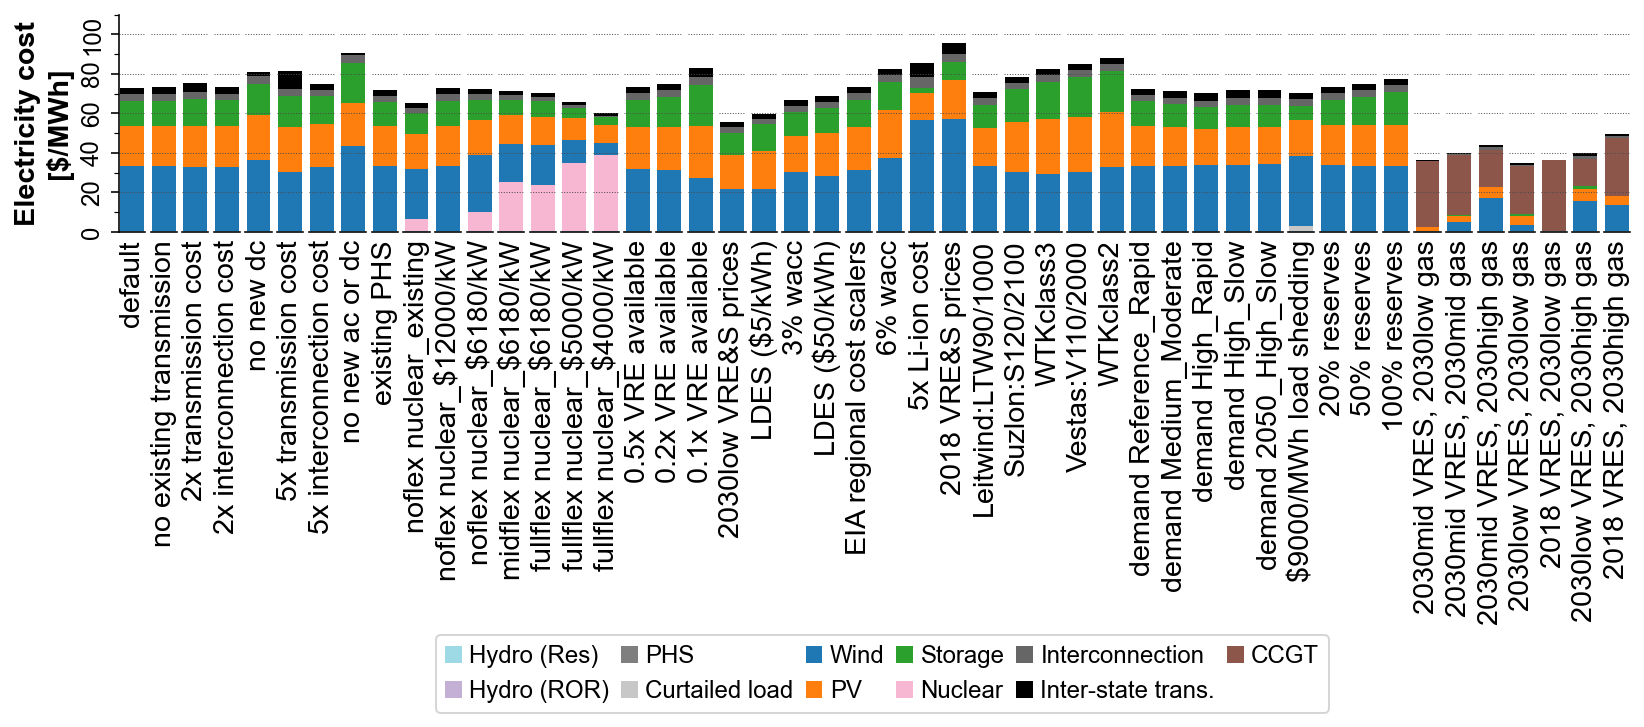

In [25]:
frameon = False
color = 'C7'
alpha = 1

plt.close()
f,ax=plt.subplots(1,len(labels), figsize=figsize, sharex=True, sharey='row')
for col, label in enumerate(labels):
    ###### Get the interconnection costs
    if label in ['2x interconnection cost', '5x interconnection cost']:
        ### Site CF info
        distancepath = os.path.join(projpath,'io','cf-2007_2013','1x','')
        pv_sites = {
            node: pd.read_csv(
                (distancepath+'{}/pv/track-0t-180az/mean-nsrdb,icomesh9-track-0t-180az-'
                 +'1.30dcac-86USDperkWacyr-{}_{}.csv'
                ).format(unitlevel, unitlevel, node))
            for node in bas
        }
        wind_sites = {
            node: pd.read_csv(
                (distancepath+'{}/wind/Gamesa|G126_2500_low/mean-wtkhsds,every2,offset0,onshore-'
                 +'Gamesa|G126_2500_low-100m-19pctloss-121USDperkWacyr-{}_{}.csv'
                ).format(unitlevel, unitlevel, node))
            for node in bas
        }
        ###### Create dicts with area-weighted costs
        ### PV
        pv_trans_cost_adder = {}
        for node in bas:
            for jbin in pvbins:
                df = pv_sites[node].loc[pv_sites[node]['binlcoe_5']==jbin].copy()
                pv_trans_cost_adder[(node,jbin)] = (df.km2 * df.cost_trans_annual).sum() / df.km2.sum()
        ### Wind
        wind_trans_cost_adder = {}
        for node in bas:
            for jbin in windbins:
                df = wind_sites[node].loc[wind_sites[node]['binlcoe_5']==jbin].copy()
                wind_trans_cost_adder[(node,jbin)] = (df.km2 * df.cost_trans_annual).sum() / df.km2.sum()
    else:
        pv_trans_cost_adder = pv_trans_cost
        wind_trans_cost_adder = wind_trans_cost
    if label in ['2x transmission cost','5x transmission cost']:
        scaler = int(label[0])
    else:
        scaler = 1
        
    ###### Continue
    case = barindex[label]
    dictplot = {}
    gens = dictout[case]['cost'].index.values
    dfplot = pd.Series({
        '{}{}{}'.format(*gen): 
        dictout[case]['cost'][
            [c for c in gens if (
                c.startswith(gen[0]) and (gen[1] in c) and c.endswith(gen[2]))]
        ].sum() / dictout[case]['values']['loadsum'] * 1000
        for gen in colors
    })
    ### Rewrite the components
    ### Unchanged components
    for gen in ['Hydro_Res','Hydro_ROR','Stor','Lostload','Nuclear_old','Nuclear_new','CCGT','OCGT','PHS']:
        if gen in dfplot.index:
            dictplot[gen] = dfplot[gen]
        else:
            pass
    dictplot['Inter-zone trans.'] = dfplot['|']
    ###### PV, wind
    gens = dictout[case]['cap'].index.values
    ### PV
    foo = defaults.params_generators[cases.loc[case,'pv']]
    dictplot['PV_gen'] = sum([
        dictout[case]['cap']['PV_{}_{}'.format(ba,pvbin)] * 7 * (
            foo['cost_capex'] * (
                zephyr.cpm.crf(cases.loc[case,'wacc_gen'],foo['lifetime'])
                if not np.isnan(cases.loc[case,'wacc_gen']) else foo['CRF'])
         + foo['cost_fom'])
        for ba in bas for pvbin in pvbins
    ]) / dictout[case]['values']['loadsum'] * 1000
    dictplot['PV_interconnection'] = sum([
        dictout[case]['cap']['PV_{}_{}'.format(ba,pvbin)] * pv_trans_cost_adder[ba,pvbin] * 7
        for ba in bas for pvbin in pvbins
    ]) / dictout[case]['values']['loadsum'] * 1000
    dictplot['PV_interstate'] = sum([
        dictout[case]['cap']['PV_{}_{}'.format(ba,pvbin)] * transcost_adder[ba] * 7 * scaler
        for ba in bas for pvbin in pvbins
    ]) / dictout[case]['values']['loadsum'] * 1000
    ### Wind
    foo = defaults.params_generators[cases.loc[case,'wind']]
    dictplot['Wind_gen'] = sum([
        dictout[case]['cap']['Wind_{}_{}'.format(ba,windbin)] * 7 * (
            foo['cost_capex'] * (
                zephyr.cpm.crf(cases.loc[case,'wacc_gen'],foo['lifetime'])
                if not np.isnan(cases.loc[case,'wacc_gen']) else foo['CRF'])
         + foo['cost_fom'])
        for ba in bas for windbin in windbins
    ]) / dictout[case]['values']['loadsum'] * 1000
    dictplot['Wind_interconnection'] = sum([
        dictout[case]['cap']['Wind_{}_{}'.format(ba,windbin)] * wind_trans_cost_adder[ba,windbin] * 7
        for ba in bas for windbin in windbins
    ]) / dictout[case]['values']['loadsum'] * 1000
    dictplot['Wind_interstate'] = sum([
        dictout[case]['cap']['Wind_{}_{}'.format(ba,windbin)] * transcost_adder[ba] * 7 * scaler
        for ba in bas for windbin in windbins
    ]) / dictout[case]['values']['loadsum'] * 1000
    
    dfframe = pd.Series(dictplot)[plotorder]
    
    ### Plot it
    ax[col].bar(
        x=[2010]*len(dfframe), 
        height=dfframe.values, 
        bottom=dfframe.cumsum().shift(1).fillna(0),
        width=7, color=colorlist,
    )
    
### Formatting
for col, label in enumerate(labels):
    ax[col].set_xticks([])
    ax[col].set_xticklabels([])
    ax[col].set_xlabel(label, rotation=90, weight='normal')
    ax[col].grid(which='major', axis='y', c='0.3', ls=':', lw=0.5)
### Formatting
ax[0].yaxis.set_major_locator(MultipleLocator(20))
ax[0].yaxis.set_minor_locator(AutoMinorLocator(2))
l = np.arange(0,201,20)
ax[0].set_yticks(l)
ax[0].set_yticklabels(l, rotation=90, va='center')
ax[0].set_ylabel('Electricity cost\n[$/MWh]')
ax[0].set_ylim(0,110)
for col in range(1,len(labels)):
    zephyr.plots.despine(ax[col],left=False)
zephyr.plots.despine(ax[0])
### Legend (by hand)
handles = [
    mpl.patches.Patch(facecolor=legendcolors[i], edgecolor='none', label=i)
    for i in legendcolors
]
leg = ax[-1].legend(
    handles=handles,loc='upper right',bbox_to_anchor=(-10,-1.8),fontsize='large',
    frameon=True, handletextpad=0.3, handlelength=0.7,#0.7
    columnspacing=0.5, ncol=6, 
)
if save:
    savename = 'sensitivity-SCOEbreakdown,trans-7yearbar-horlegend'
    plt.savefig(figpath+savename+'.png')
    plt.savefig(figpath+savename+'.pdf')
plt.show()

### Individual cases

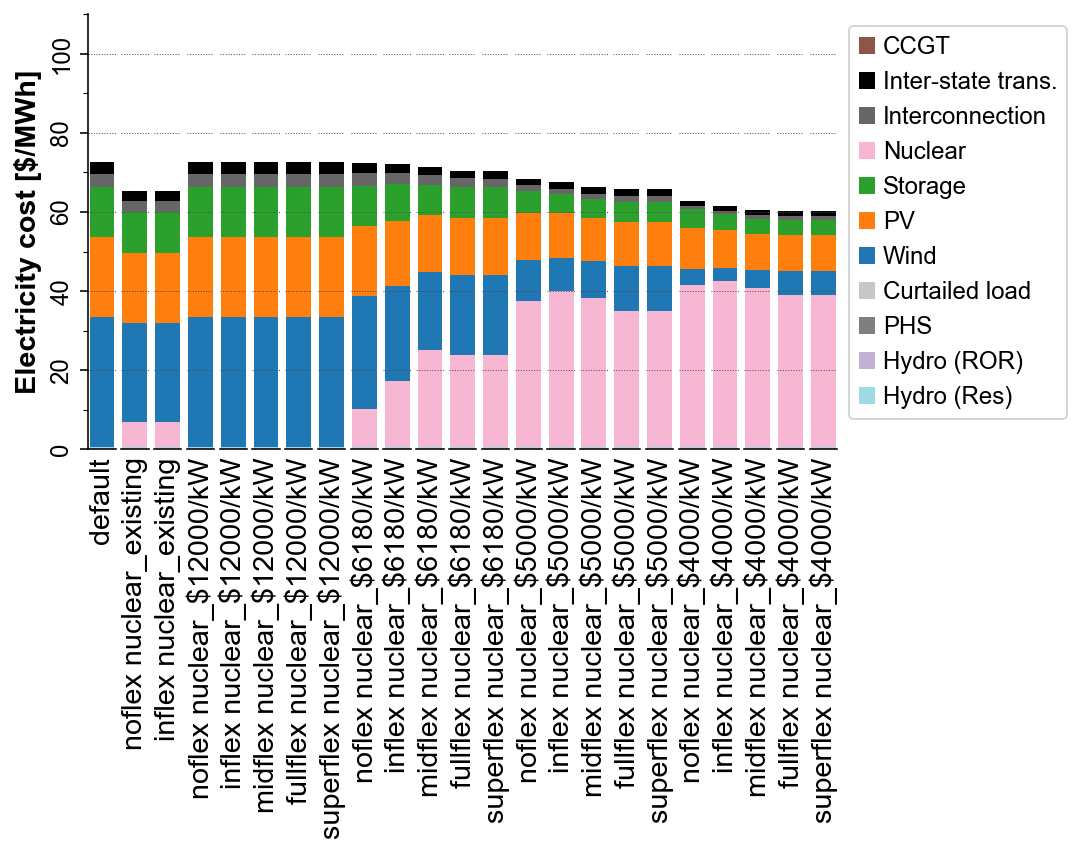

In [26]:
plotlabels = [
    'default', 'noflex nuclear_existing', 'inflex nuclear_existing',
    'noflex nuclear_$12000/kW', 'inflex nuclear_$12000/kW', 'midflex nuclear_$12000/kW', 
    'fullflex nuclear_$12000/kW', 'superflex nuclear_$12000/kW',
    'noflex nuclear_$6180/kW', 'inflex nuclear_$6180/kW','midflex nuclear_$6180/kW', 'fullflex nuclear_$6180/kW', 
    'superflex nuclear_$6180/kW',
    'noflex nuclear_$5000/kW', 'inflex nuclear_$5000/kW','midflex nuclear_$5000/kW', 'fullflex nuclear_$5000/kW', 
    'superflex nuclear_$5000/kW',
    'noflex nuclear_$4000/kW', 'inflex nuclear_$4000/kW','midflex nuclear_$4000/kW', 'fullflex nuclear_$4000/kW', 
    'superflex nuclear_$4000/kW',
]

alpha = 1

plt.close()
f,ax=plt.subplots(1,len(plotlabels), figsize=(14/48*len(plotlabels),4), sharex=True, sharey='row')
# for col, label in enumerate(['inflex nuclear_$4000/kW']):
for col, label in enumerate(plotlabels):
    ###### Get the interconnection costs
    if label in ['2x interconnection cost', '5x interconnection cost']:
        ### Site CF info
        distancepath = os.path.join(projpath,'io','cf-2007_2013','1x','')
        pv_sites = {
            node: pd.read_csv(
                (distancepath+'{}/pv/track-0t-180az/mean-nsrdb,icomesh9-track-0t-180az-'
                 +'1.30dcac-86USDperkWacyr-{}_{}.csv'
                ).format(unitlevel, unitlevel, node))
            for node in bas
        }
        wind_sites = {
            node: pd.read_csv(
                (distancepath+'{}/wind/Gamesa|G126_2500_low/mean-wtkhsds,every2,offset0,onshore-'
                 +'Gamesa|G126_2500_low-100m-19pctloss-121USDperkWacyr-{}_{}.csv'
                ).format(unitlevel, unitlevel, node))
            for node in bas
        }
        ###### Create dicts with area-weighted costs
        ### PV
        pv_trans_cost_adder = {}
        for node in bas:
            for jbin in pvbins:
                df = pv_sites[node].loc[pv_sites[node]['binlcoe_5']==jbin].copy()
                pv_trans_cost_adder[(node,jbin)] = (df.km2 * df.cost_trans_annual).sum() / df.km2.sum()
        ### Wind
        wind_trans_cost_adder = {}
        for node in bas:
            for jbin in windbins:
                df = wind_sites[node].loc[wind_sites[node]['binlcoe_5']==jbin].copy()
                wind_trans_cost_adder[(node,jbin)] = (df.km2 * df.cost_trans_annual).sum() / df.km2.sum()
    else:
        pv_trans_cost_adder = pv_trans_cost
        wind_trans_cost_adder = wind_trans_cost
    if label in ['2x transmission cost','5x transmission cost']:
        scaler = int(label[0])
    else:
        scaler = 1
        
    ###### Continue
    case = barindex[label]
    dictplot = {}
    gens = dictout[case]['cost'].index.values
    dfplot = pd.Series({
        '{}{}{}'.format(*gen): 
        dictout[case]['cost'][
            [c for c in gens if (
                c.startswith(gen[0]) and (gen[1] in c) and c.endswith(gen[2]))]
        ].sum() / dictout[case]['values']['loadsum'] * 1000
        for gen in colors
    })
    ### Rewrite the components
    ### Unchanged components
    for gen in ['Hydro_Res','Hydro_ROR','Stor','Lostload','Nuclear_old','Nuclear_new','CCGT','OCGT','PHS']:
        if gen in dfplot.index:
            dictplot[gen] = dfplot[gen]
        else:
            pass
    dictplot['Inter-zone trans.'] = dfplot['|']
    ###### PV, wind
    gens = dictout[case]['cap'].index.values
    ### PV
    foo = defaults.params_generators[cases.loc[case,'pv']]
    dictplot['PV_gen'] = sum([
        dictout[case]['cap']['PV_{}_{}'.format(ba,pvbin)] * 7 * (
            foo['cost_capex'] * (
                zephyr.cpm.crf(cases.loc[case,'wacc_gen'],foo['lifetime'])
                if not np.isnan(cases.loc[case,'wacc_gen']) else foo['CRF'])
         + foo['cost_fom'])
        for ba in bas for pvbin in pvbins
    ]) / dictout[case]['values']['loadsum'] * 1000
    dictplot['PV_interconnection'] = sum([
        dictout[case]['cap']['PV_{}_{}'.format(ba,pvbin)] * pv_trans_cost_adder[ba,pvbin] * 7
        for ba in bas for pvbin in pvbins
    ]) / dictout[case]['values']['loadsum'] * 1000
    dictplot['PV_interstate'] = sum([
        dictout[case]['cap']['PV_{}_{}'.format(ba,pvbin)] * transcost_adder[ba] * 7 * scaler
        for ba in bas for pvbin in pvbins
    ]) / dictout[case]['values']['loadsum'] * 1000
    ### Wind
    foo = defaults.params_generators[cases.loc[case,'wind']]
    dictplot['Wind_gen'] = sum([
        dictout[case]['cap']['Wind_{}_{}'.format(ba,windbin)] * 7 * (
            foo['cost_capex'] * (
                zephyr.cpm.crf(cases.loc[case,'wacc_gen'],foo['lifetime'])
                if not np.isnan(cases.loc[case,'wacc_gen']) else foo['CRF'])
         + foo['cost_fom'])
        for ba in bas for windbin in windbins
    ]) / dictout[case]['values']['loadsum'] * 1000
    dictplot['Wind_interconnection'] = sum([
        dictout[case]['cap']['Wind_{}_{}'.format(ba,windbin)] * wind_trans_cost_adder[ba,windbin] * 7
        for ba in bas for windbin in windbins
    ]) / dictout[case]['values']['loadsum'] * 1000
    dictplot['Wind_interstate'] = sum([
        dictout[case]['cap']['Wind_{}_{}'.format(ba,windbin)] * transcost_adder[ba] * 7 * scaler
        for ba in bas for windbin in windbins
    ]) / dictout[case]['values']['loadsum'] * 1000
    
    dfframe = pd.Series(dictplot)[plotorder]
    
    ### Plot it
    ax[col].bar(
        x=[2010]*len(dfframe), 
        height=dfframe.values, 
        bottom=dfframe.cumsum().shift(1).fillna(0),
        width=7, color=colorlist,
    )
    ### Log
#     print('{}: {}'.format(label, ))
    
### Formatting
for col, label in enumerate(plotlabels):
    ax[col].set_xticks([])
    ax[col].set_xticklabels([])
    ax[col].set_xlabel(label, rotation=90, weight='normal')
    ax[col].grid(which='major', axis='y', c='0.3', ls=':', lw=0.5)
### Formatting
ax[0].yaxis.set_major_locator(MultipleLocator(20))
ax[0].yaxis.set_minor_locator(AutoMinorLocator(2))
l = np.arange(0,201,20)
ax[0].set_yticks(l)
ax[0].set_yticklabels(l, rotation=90, va='center')
ax[0].set_ylabel('Electricity cost [$/MWh]')
ax[0].set_ylim(0,110) ### used to be 150
for col in range(1,len(plotlabels)):
    zephyr.plots.despine(ax[col],left=False)
zephyr.plots.despine(ax[0])
### Legend (by hand)
handles = [
    mpl.patches.Patch(facecolor=legendcolors[i], edgecolor='none', label=i)
    for i in legendcolors
]
leg = ax[-1].legend(
    handles=handles[::-1],loc='upper left',bbox_to_anchor=(1,1),fontsize='large',
    frameon=True, handletextpad=0.3, handlelength=0.7,#0.7
)
if save:
    savename = 'sensitivity-SCOEbreakdown-special-nuclear'
    plt.savefig(figpath+savename+'.png')
    plt.savefig(figpath+savename+'.pdf')
plt.show()

# Energy
* CF for PV, wind
* spill + gen for hydro
* nameplate for nuclear, gas
* - charge, + discharge for storage

## Load VRE capacity factors

In [27]:
#########################
### PV yearly
def pvfile(zone,bins): 
    pvpath = os.path.join(projpath,'io','cf-2007_2013','1x','ba','pv','track-0t-180az','binned','')
    return '{}cf-nsrdb,icomesh9-track-0t-180az-1.30dcac-86USDperkWacyr-ba_{}-{}lcoebins.csv'.format(
        pvpath, zone, bins)

cfpvyear = {}
cfpv = {}
for ba in tqdm(bas):
    numbins_pv = dfregion.loc[ba,'numbins_pv']
    bins_pv = dfregion.loc[ba,'bins_pv'].split(',')
    dfpv = pd.read_csv(
        pvfile(ba,numbins_pv), index_col=0, parse_dates=True
    )[bins_pv].tz_convert(tz)
    dfpv = (
        dfpv.drop(dfpv.loc['2008-02-29'].index)
        .drop(dfpv.loc['2012-02-29'].index)
        .drop(dfpv.loc['2013-12-31'].index)
    )
    cfpv[ba] = dfpv.copy()
    for year in years:
        cfpvyear[ba,str(year)] = float(dfpv.loc[str(year)].mean())

In [28]:
#################
### Wind yearly
def windfile(zone,bins,model='Gamesa:G126/2500_low'): 
    modelsave = model.replace(':','|').replace('/','_').replace(' ','')
    windpath = '{}io/cf-2007_2013/1x/ba/wind/{}/binned/'.format(
        projpath, modelsave)
    return ('{}cf-wtkhsds,every2,offset0,onshore-{}-100m-'
            '19pctloss-121USDperkWacyr-ba_{}-{}lcoebins.csv').format(
        windpath, modelsave, zone, bins)

cfwindyear = {}
cfwind = {}
models = ['Gamesa:G126/2500_low','WTKclass3',
          'Leitwind:LTW90/1000','Suzlon:S120/2100','Vestas:V110/2000',
          'WTKclass2',]
for ba in tqdm(bas):
    for model in models:
        numbins_wind = dfregion.loc[ba,'numbins_wind']
        bins_wind = dfregion.loc[ba,'bins_wind'].split(',')
        dfwind = pd.read_csv(
            windfile(ba,numbins_wind,model), index_col=0, parse_dates=True
        )[bins_wind].tz_convert(tz)
        dfwind = (
            dfwind.drop(dfwind.loc['2008-02-29'].index)
            .drop(dfwind.loc['2012-02-29'].index)
            .drop(dfwind.loc['2013-12-31'].index)
        )
        cfwind[ba,model] = dfwind.copy()
        for year in years:
            # cfwindyear[ba,model,str(year)] = float(dfwind.mean()) ### original, only one bin
            cfwindyear[ba,model,str(year)] = dfwind.loc[str(year)].mean()

## Available energy

### All cases

In [29]:
colors = {
    ('Stor','_P'): plt.cm.tab20(4),
    ('PHS',''): plt.cm.tab20(15),
    # ('PHS',''): plt.cm.binary(1000),
    ('HydroROR',''): plt.cm.tab20(9),
    ('HydroRes',''): plt.cm.tab20(19),
    ('Nuclear','_old'): plt.cm.tab20(13),
    ('Nuclear','_new'): plt.cm.tab20(13),
    ('Wind',''): plt.cm.tab20(0),
    ('PV',''): plt.cm.tab20(2),
    ('CCGT',''): plt.cm.tab20(10),
    ('OCGT',''): plt.cm.tab20(16),
}
colorlist = [colors[c] for c in colors]

windbins = [0,1,2,3,4]

                                 default 1.566
                no existing transmission 1.567
                    2x transmission cost 1.559
                 2x interconnection cost 1.569
                               no new dc 1.736
                    5x transmission cost 1.535
                 5x interconnection cost 1.581
                         no new ac or dc 1.908
                            existing PHS 1.566
                 noflex nuclear_existing 1.455
                noflex nuclear_$12000/kW 1.566
                 noflex nuclear_$6180/kW 1.499
                midflex nuclear_$6180/kW 1.381
               fullflex nuclear_$6180/kW 1.392
               fullflex nuclear_$5000/kW 1.333
               fullflex nuclear_$4000/kW 1.299
                      0.5x VRE available 1.538
                      0.2x VRE available 1.530
                      0.1x VRE available 1.494
                    2030low VRE&S prices 1.469
                           LDES ($5/kWh) 1.213
             

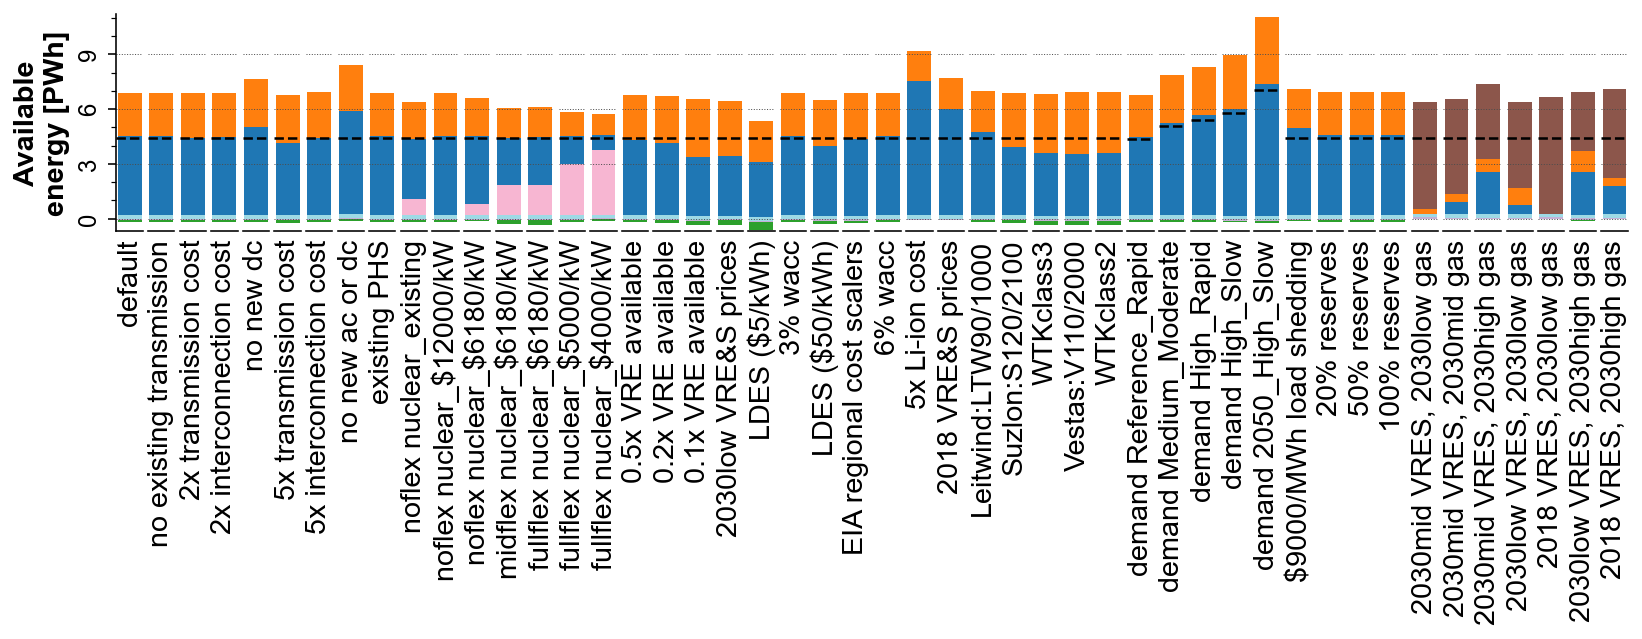

In [30]:
plt.close()
f,ax=plt.subplots(1,len(labels), figsize=figsize, sharex=True, sharey='row')
for col, label in enumerate(labels):
    barcase = barindex[label]
    gens = dictout[barcase]['cap'].index.values
    loadsum = dictout[barcase]['values']['loadsum'] / 7E6
    ### Plot the total load
    ax[col].axhline(loadsum, c='k', lw=1.27, ls='--')
    ### Continue
    df = dictout[barcase]['energy']
    gencols = [c for c in df.index if (('|' not in c) and ('Load' not in c))]
    ### Make generator-specific cols (gross)
    plotcols = {
        'Stor_charge': [c for c in gencols if c.startswith('Stor') and c.endswith('_charge')],
        'PHS_charge': [c for c in gencols if c.startswith('PHS') and c.endswith('_charge')],
        'Stor_discharge': [c for c in gencols if c.startswith('Stor') and c.endswith('_discharge')],
        'PHS_discharge': [c for c in gencols if c.startswith('PHS') and c.endswith('_discharge')],
        'HydroROR': [c for c in gencols if c.startswith('Hydro_ROR')],
        'HydroRes': [c for c in gencols if c.startswith('Hydro_Res')],
        'NuclearOld': [c for c in gencols if c.startswith('Nuclear') and c.endswith('_old')],
        'NuclearNew': [c for c in gencols if c.startswith('Nuclear') and c.endswith('_new')],
        'Wind': ['Wind_all'],
        'PV': ['PV_all'],
        'CCGT': [c for c in gencols if c.startswith('CCGT')],
        'OCGT': [c for c in gencols if c.startswith('OCGT')],
    }
    dfplot = pd.Series(
        {c: df[plotcols[c]].sum() for c in plotcols}
    ) / len(years)
    ### Replace dispatchable columns with capacity * CF
    dfplot['PV'] = sum([
        dictout[barcase]['cap']['PV_{}_0'.format(ba)] * casehours[case] * cfpvyear[ba,caseyear[case]] 
        for ba in bas for case in yearindices[label]]) / len(years)
    dfplot['Wind'] = sum(
        [
            (dictout[barcase]['cap']['Wind_{}_{}'.format(ba,windbin)] * casehours[case]
             * cfwindyear[ba,cases.loc[case,'wind_model'],caseyear[case]][windbin]
            )
            for windbin in windbins for ba in bas for case in yearindices[label]
        ]
    ) / len(years)
    if dfplot['NuclearOld'] > 0:
        dfplot['NuclearOld'] = sum([
            dictout[barcase]['cap']['Nuclear_{}_old'.format(ba)] * casehours[case] * 1
            for ba in bas for case in yearindices[label]]) / len(years)
    if dfplot['NuclearNew'] > 0:
        dfplot['NuclearNew'] = sum([
            dictout[barcase]['cap']['Nuclear_{}_new'.format(ba)] * casehours[case] * 1
            for ba in bas for case in yearindices[label]]) / len(years)
    for g in ['CCGT','OCGT']:
        if dfplot[g] > 0:
            dfplot[g] = sum([
                dictout[barcase]['cap'].loc['{}_{}'.format(g,ba)] * casehours[case] * 1
                for ba in bas for case in yearindices[label]]) / len(years)

    ### Convert to PWh
    dfplot = dfplot / 1E6
    ### Calculate transmission losses
    tcols = [c for c in dictout[barcase]['energy'].index if '|' in c]
    translosses = []
    for c in tcols:
        node1 = c.split('|')[0]
        node2 = c.split('|')[1].split('_')[0]
        linetype = c.split('_')[1]
        translosses.append(
            abs(dictout[barcase]['energy'].fillna(0)[c]) 
            * dfdistance.loc[node1,node2] * loss_distance[linetype]
        )
    translosses = sum(translosses) / 1E6 / len(years)
    ### Continue
    start = dfplot[['Stor_charge','PHS_charge']].sum() - translosses
    height = dfplot.loc['Stor_discharge':]
    bottom = height.cumsum() + start
    ### Plot it
    ax[col].bar(
        x=[2010]*len(bottom), 
        bottom=bottom.values, 
        height=-height.values,
        width=7, color=colorlist,
    )
    ### Log
    print('{:>40} {:.3f}'.format(
        label, 
        # (1 - loadsum / (dfplot.sum() - translosses)) ### curtailment
        (dfplot.sum() - translosses) / loadsum
    ))
    
### Formatting
for col, label in enumerate(labels):
    ax[col].set_xticks([])
    ax[col].set_xticklabels([])
    ax[col].set_xlabel(label, rotation=90, weight='normal')
    ax[col].grid(which='major', axis='y', c='0.3', ls=':', lw=0.5)
    
### Formatting
ax[0].yaxis.set_major_locator(MultipleLocator(3))
ax[0].yaxis.set_minor_locator(AutoMinorLocator(3))
l = np.arange(-3,31,3)
ax[0].set_yticks(l)
ax[0].set_yticklabels(l, rotation=90, va='center')
ax[0].set_ylabel('Available\nenergy [PWh]')
ax[0].set_ylim(-0.7,11.2)
ax[0].set_xlim(2006.15, 2013.85)
for col in range(1,len(labels)):
    zephyr.plots.despine(ax[col],left=False)
zephyr.plots.despine(ax[0])
if save:
    savename = 'sensitivity-energy_available-7yearbar'
    plt.savefig(figpath+savename+'.png')
    plt.savefig(figpath+savename+'.pdf')
plt.show()

## Dispatched energy

                                 default: 1.0000
                no existing transmission: 1.0000
                    2x transmission cost: 1.0000
                 2x interconnection cost: 1.0000
                               no new dc: 1.0000
                    5x transmission cost: 1.0000
                 5x interconnection cost: 1.0000
                         no new ac or dc: 1.0000
                            existing PHS: 1.0000
                 noflex nuclear_existing: 1.0000
                noflex nuclear_$12000/kW: 1.0000
                 noflex nuclear_$6180/kW: 1.0000
                midflex nuclear_$6180/kW: 1.0000
               fullflex nuclear_$6180/kW: 1.0000
               fullflex nuclear_$5000/kW: 1.0000
               fullflex nuclear_$4000/kW: 1.0000
                      0.5x VRE available: 1.0000
                      0.2x VRE available: 1.0000
                      0.1x VRE available: 1.0000
                    2030low VRE&S prices: 1.0000
                    

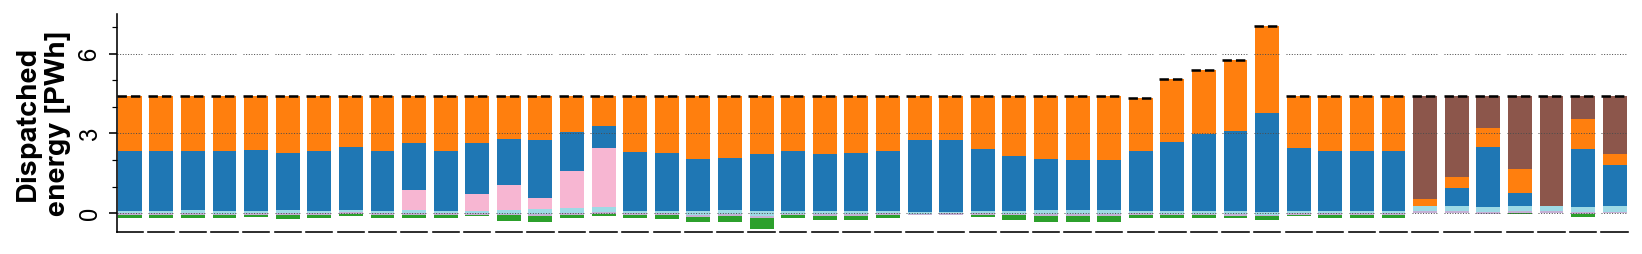

In [31]:
plt.close()
f,ax=plt.subplots(1,len(labels), figsize=figsize, sharex=True, sharey='row')
for col, label in enumerate(labels):
    ### Use this version while some are not yet done
    case = barindex[label]
    gens = dictout[case]['cap'].index.values
    loadsum = dictout[case]['values']['loadsum'] / 7E6
    ### Plot the total load
    ax[col].axhline(loadsum, c='k', lw=1.27, ls='--')
    ### Aggregate the generation
    df = dictout[case]['energy']
    gencols = [c for c in df.index if (('|' not in c) and ('Load' not in c))]
    ### Make generator-specific cols (gross)
    plotcols = {
        'Stor_charge': [c for c in gencols if c.startswith('Stor') and c.endswith('_charge')],
        'PHS_charge': [c for c in gencols if c.startswith('PHS') and c.endswith('_charge')],
        'Stor_discharge': [c for c in gencols if c.startswith('Stor') and c.endswith('_discharge')],
        'PHS_discharge': [c for c in gencols if c.startswith('PHS') and c.endswith('_discharge')],
        'HydroROR': [c for c in gencols if c.startswith('Hydro_ROR')],
        # 'HydroRes': [c for c in gencols if c.startswith('Hydro_Res')],
        'HydroRes': [c for c in gencols if c.startswith('Hydro_Res') and c.endswith('_power')],
        'NuclearOld': [c for c in gencols if c.startswith('Nuclear') and c.endswith('_old')],
        'NuclearNew': [c for c in gencols if c.startswith('Nuclear') and c.endswith('_new')],
        # 'Wind': ['Wind_all'],
        'Wind': [c for c in gencols if c.startswith('Wind') and ('_all' not in c)],
        'PV': ['PV_all'],
        'CCGT': [c for c in gencols if c.startswith('CCGT')],
        'OCGT': [c for c in gencols if c.startswith('OCGT')],
    }
    dfplot = pd.Series(
        {c: df[plotcols[c]].sum() for c in plotcols}
    ) / 1E6 / len(years) ### convert to PWh, correct for number of years

    ### Calculate transmission losses
    tcols = [c for c in dictout[case]['energy'].index if '|' in c]
    translosses = []
    for c in tcols:
        node1 = c.split('|')[0]
        node2 = c.split('|')[1].split('_')[0]
        linetype = c.split('_')[1]
        translosses.append(
            abs(dictout[case]['energy'].fillna(0)[c]) 
            * dfdistance.loc[node1,node2] * loss_distance[linetype]
        )
    translosses = sum(translosses) / 7E6
    ### Continue
    start = dfplot[['Stor_charge','PHS_charge']].sum() - translosses
    height = dfplot.loc['Stor_discharge':]
    bottom = height.cumsum() + start
    ### Plot it
    ax[col].bar(
        x=[2010]*len(bottom), 
        bottom=bottom.values, 
        height=-height.values,
        width=7, color=colorlist,
    )
    ### Log
    print('{:>40}: {:.4f}'.format(
        label, 1 - (dfplot[['CCGT','OCGT']].sum() / loadsum)))

### Formatting
for col, label in enumerate(labels):
    ax[col].set_xticks([])
    ax[col].set_xticklabels([])
    # ax[col].set_xlabel(label, rotation=90, weight='normal', labelpad=5)
    ax[col].grid(which='major', axis='y', c='0.3', ls=':', lw=0.5)
    
### Formatting
ax[0].yaxis.set_major_locator(MultipleLocator(3))
ax[0].yaxis.set_minor_locator(AutoMinorLocator(3))
l = np.arange(-3,31,3)
ax[0].set_yticks(l)
ax[0].set_yticklabels(l, rotation=90, va='center')
ax[0].set_ylabel('Dispatched\nenergy [PWh]')
ax[0].set_ylim(-0.7,7.5)
ax[0].set_xlim(2006.15, 2013.85)
for col in range(1,len(labels)):
    zephyr.plots.despine(ax[col],left=False)
zephyr.plots.despine(ax[0])
if save:
    savename = 'sensitivity-energy_dispatched-7yearbar'
    plt.savefig(figpath+savename+'.png')
    plt.savefig(figpath+savename+'.pdf')
plt.show()

### Extra cases

In [32]:
colors = {
    ('Stor','_P'): plt.cm.tab20(4),
    ('PHS',''): plt.cm.tab20(15),
    # ('PHS',''): plt.cm.binary(1000),
    ('HydroROR',''): plt.cm.tab20(9),
    ('HydroRes',''): plt.cm.tab20(19),
    ('Nuclear','_old'): plt.cm.tab20(13),
    ('Nuclear','_new'): plt.cm.tab20(13),
    ('Wind',''): plt.cm.tab20(0),
    ('PV',''): plt.cm.tab20(2),
    ('CCGT',''): plt.cm.tab20(10),
    ('OCGT',''): plt.cm.tab20(16),
}
colorlist = [colors[c] for c in colors]

                                 default: 1.0000
                 noflex nuclear_existing: 1.0000
                 inflex nuclear_existing: 1.0000
                noflex nuclear_$12000/kW: 1.0000
                inflex nuclear_$12000/kW: 1.0000
               midflex nuclear_$12000/kW: 1.0000
              fullflex nuclear_$12000/kW: 1.0000
             superflex nuclear_$12000/kW: 1.0000
                 noflex nuclear_$6180/kW: 1.0000
                 inflex nuclear_$6180/kW: 1.0000
                midflex nuclear_$6180/kW: 1.0000
               fullflex nuclear_$6180/kW: 1.0000
              superflex nuclear_$6180/kW: 1.0000
                 noflex nuclear_$5000/kW: 1.0000
                 inflex nuclear_$5000/kW: 1.0000
                midflex nuclear_$5000/kW: 1.0000
               fullflex nuclear_$5000/kW: 1.0000
              superflex nuclear_$5000/kW: 1.0000
                 noflex nuclear_$4000/kW: 1.0000
                 inflex nuclear_$4000/kW: 1.0000
                midf

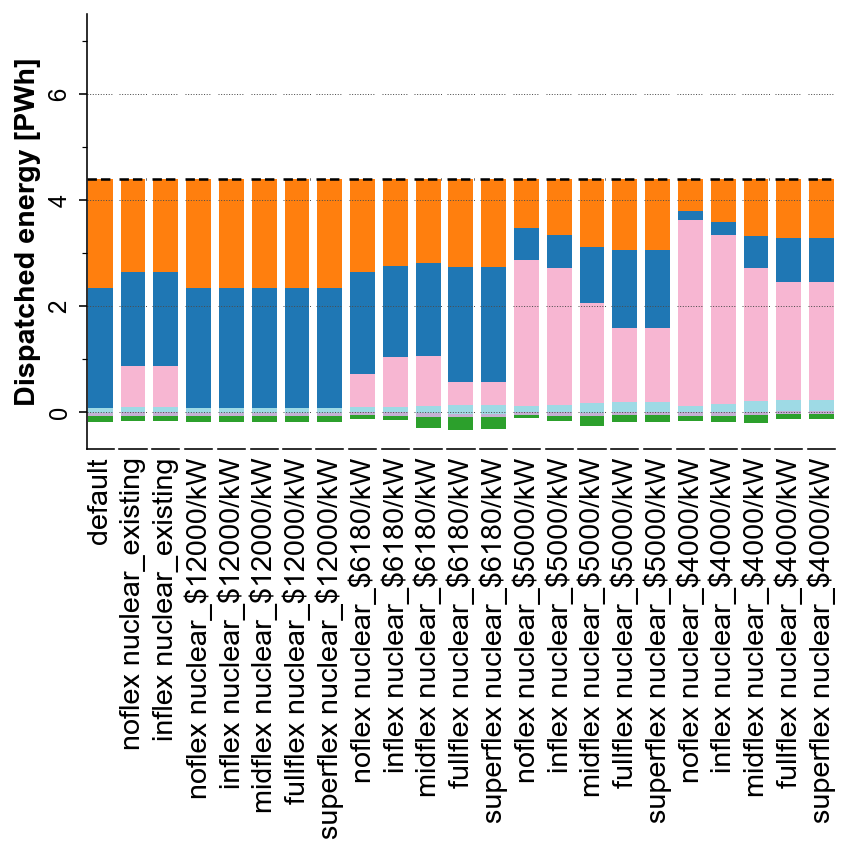

In [33]:
plotlabels = [
    'default', 'noflex nuclear_existing', 'inflex nuclear_existing',
    'noflex nuclear_$12000/kW', 'inflex nuclear_$12000/kW', 'midflex nuclear_$12000/kW', 
    'fullflex nuclear_$12000/kW', 'superflex nuclear_$12000/kW',
    'noflex nuclear_$6180/kW', 'inflex nuclear_$6180/kW','midflex nuclear_$6180/kW', 'fullflex nuclear_$6180/kW', 
    'superflex nuclear_$6180/kW',
    'noflex nuclear_$5000/kW', 'inflex nuclear_$5000/kW','midflex nuclear_$5000/kW', 'fullflex nuclear_$5000/kW', 
    'superflex nuclear_$5000/kW',
    'noflex nuclear_$4000/kW', 'inflex nuclear_$4000/kW','midflex nuclear_$4000/kW', 'fullflex nuclear_$4000/kW', 
    'superflex nuclear_$4000/kW',
]

plt.close()
f,ax=plt.subplots(1,len(plotlabels), figsize=(14/48*len(plotlabels),4), sharex=True, sharey='row')
for col, label in enumerate(plotlabels):
    ### Use this version while some are not yet done
    case = barindex[label]
    gens = dictout[case]['cap'].index.values
    loadsum = dictout[case]['values']['loadsum'] / 7E6
    ### Plot the total load
    ax[col].axhline(loadsum, c='k', lw=1.27, ls='--')
    ### Aggregate the generation
    df = dictout[case]['energy']
    gencols = [c for c in df.index if (('|' not in c) and ('Load' not in c))]
    ### Make generator-specific cols (gross)
    plotcols = {
        'Stor_charge': [c for c in gencols if c.startswith('Stor') and c.endswith('_charge')],
        'PHS_charge': [c for c in gencols if c.startswith('PHS') and c.endswith('_charge')],
        'Stor_discharge': [c for c in gencols if c.startswith('Stor') and c.endswith('_discharge')],
        'PHS_discharge': [c for c in gencols if c.startswith('PHS') and c.endswith('_discharge')],
        'HydroROR': [c for c in gencols if c.startswith('Hydro_ROR')],
        # 'HydroRes': [c for c in gencols if c.startswith('Hydro_Res')],
        'HydroRes': [c for c in gencols if c.startswith('Hydro_Res') and c.endswith('_power')],
        'NuclearOld': [c for c in gencols if c.startswith('Nuclear') and c.endswith('_old')],
        'NuclearNew': [c for c in gencols if c.startswith('Nuclear') and c.endswith('_new')],
        # 'Wind': ['Wind_all'],
        'Wind': [c for c in gencols if c.startswith('Wind') and ('_all' not in c)],
        'PV': ['PV_all'],
        'CCGT': [c for c in gencols if c.startswith('CCGT')],
        'OCGT': [c for c in gencols if c.startswith('OCGT')],
    }
    dfplot = pd.Series(
        {c: df[plotcols[c]].sum() for c in plotcols}
    ) / 1E6 / len(years) ### convert to PWh, correct for number of years

    ### Calculate transmission losses
    tcols = [c for c in dictout[case]['energy'].index if '|' in c]
    translosses = []
    for c in tcols:
        node1 = c.split('|')[0]
        node2 = c.split('|')[1].split('_')[0]
        linetype = c.split('_')[1]
        translosses.append(
            abs(dictout[case]['energy'].fillna(0)[c]) 
            * dfdistance.loc[node1,node2] * loss_distance[linetype]
        )
    translosses = sum(translosses) / 7E6
    ### Continue
    start = dfplot[['Stor_charge','PHS_charge']].sum() - translosses
    height = dfplot.loc['Stor_discharge':]
    bottom = height.cumsum() + start
    ### Plot it
    ax[col].bar(
        x=[2010]*len(bottom), 
        bottom=bottom.values, 
        height=-height.values,
        width=7, color=colorlist,
    )
    ### Log
    print('{:>40}: {:.4f}'.format(
        label, 1 - (dfplot[['CCGT','OCGT']].sum() / loadsum)))

### Formatting
for col, label in enumerate(plotlabels):
    ax[col].set_xticks([])
    ax[col].set_xticklabels([])
    ax[col].set_xlabel(label, rotation=90, weight='normal')#, labelpad=5)
    ax[col].grid(which='major', axis='y', c='0.3', ls=':', lw=0.5)
    
### Formatting
ax[0].yaxis.set_major_locator(MultipleLocator(2))
ax[0].yaxis.set_minor_locator(AutoMinorLocator(2))
l = np.arange(-2,20,2)
ax[0].set_yticks(l)
ax[0].set_yticklabels(l, rotation=90, va='center')
ax[0].set_ylabel('Dispatched energy [PWh]')
ax[0].set_ylim(-0.7,7.5)
ax[0].set_xlim(2006.15, 2013.85)
for col in range(1,len(plotlabels)):
    zephyr.plots.despine(ax[col],left=False)
zephyr.plots.despine(ax[0])
if save:
    savename = 'sensitivity-energy_dispatched-special-nuclear'
    plt.savefig(figpath+savename+'.png')
    plt.savefig(figpath+savename+'.pdf')
plt.show()

# BA capacity

In [34]:
colors = {
    ('Hydro_Res',''): plt.cm.tab20(19),
    ('Hydro_ROR',''): plt.cm.tab20(9),
    ('PHS',''): plt.cm.tab20(15),
    ('Nuclear','_old'): plt.cm.tab20(13),
    #('Nuclear','_new'): plt.cm.tab20(12),
    ('Nuclear','_new'): plt.cm.tab20(13),
    ('Wind','_0'): plt.cm.tab20(0),
    ('PV','_0'): plt.cm.tab20(2),
    ('Stor','_P'): plt.cm.tab20(4),
    ('CCGT',''): plt.cm.tab20(10),
    ('OCGT',''): plt.cm.tab20(16),
}
colorlist = [colors[c] for c in colors]

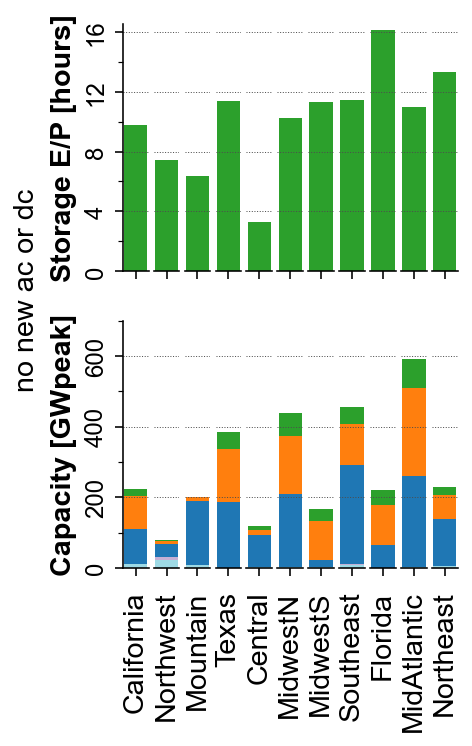

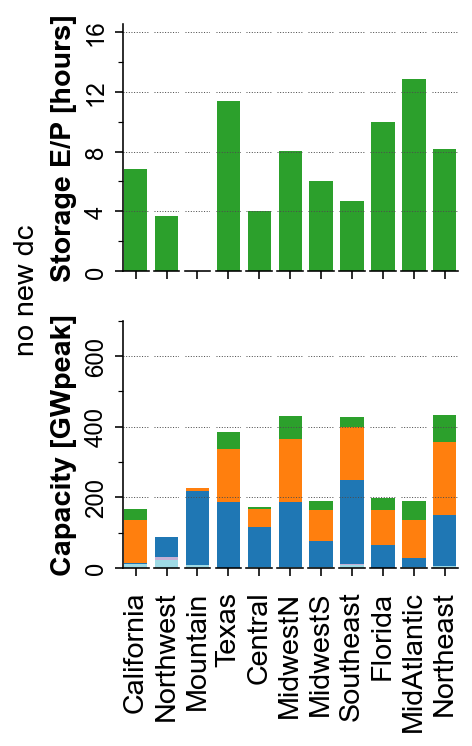

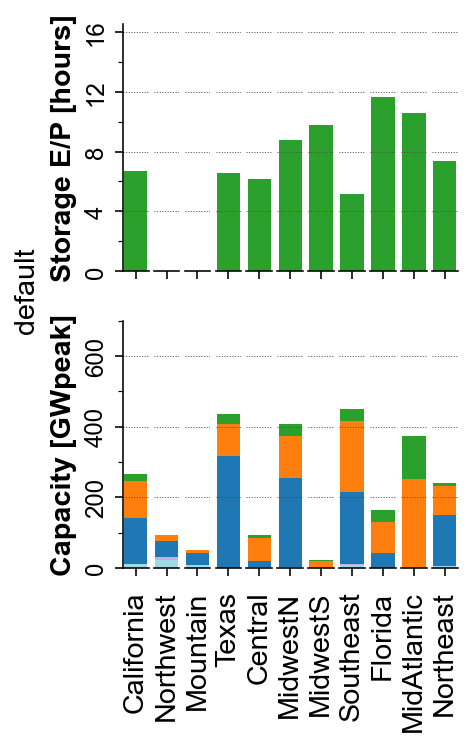

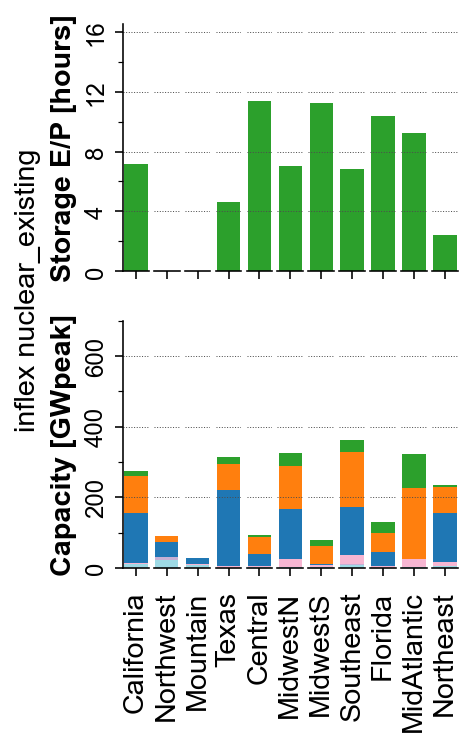

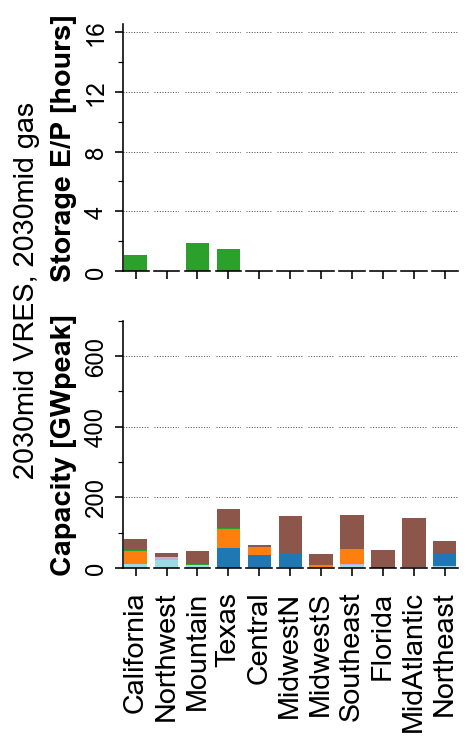

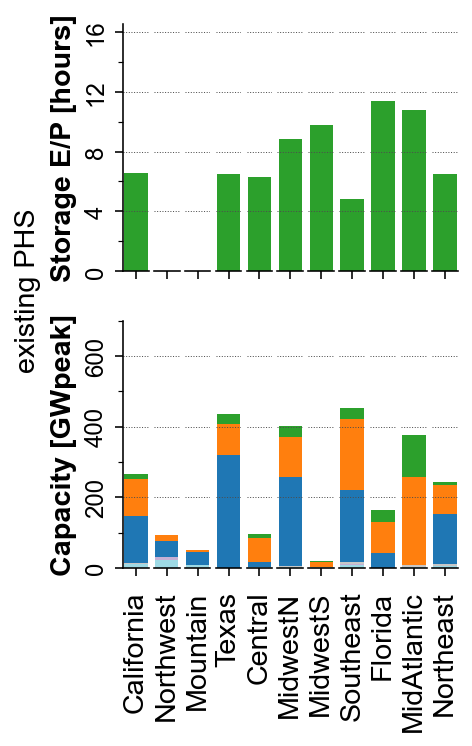

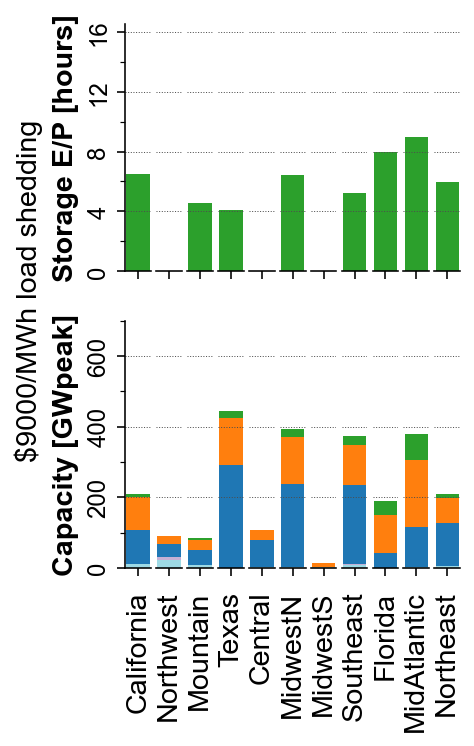

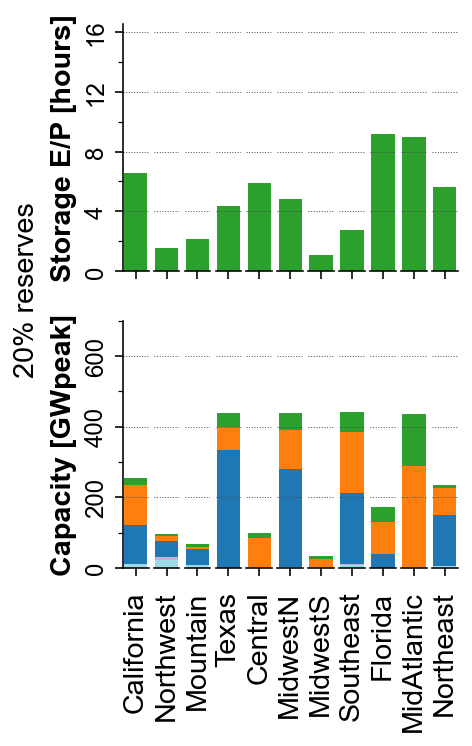

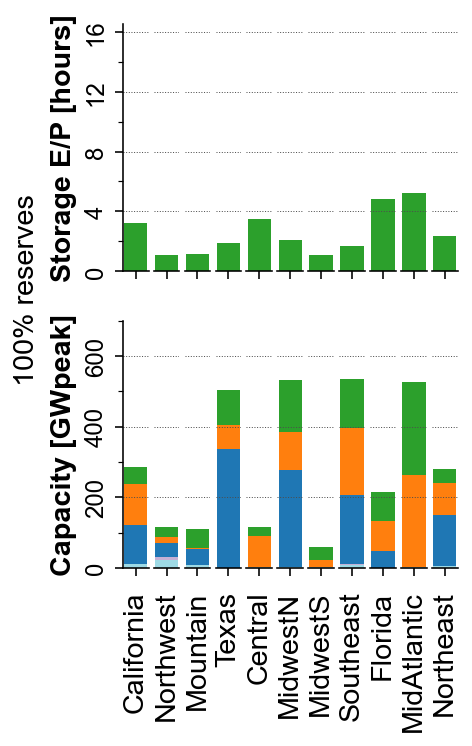

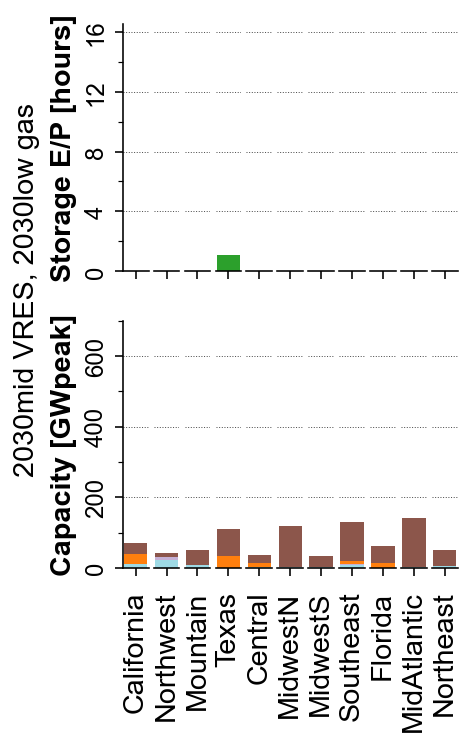

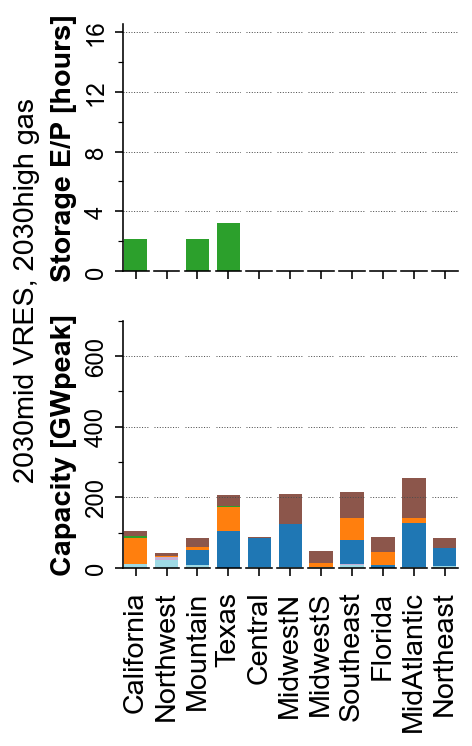

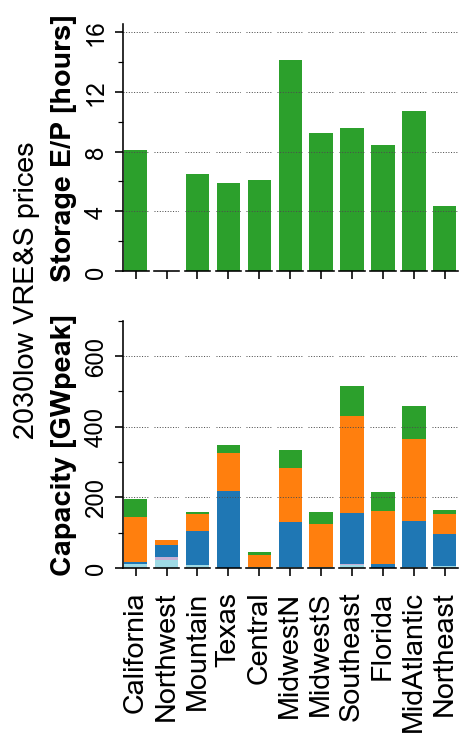

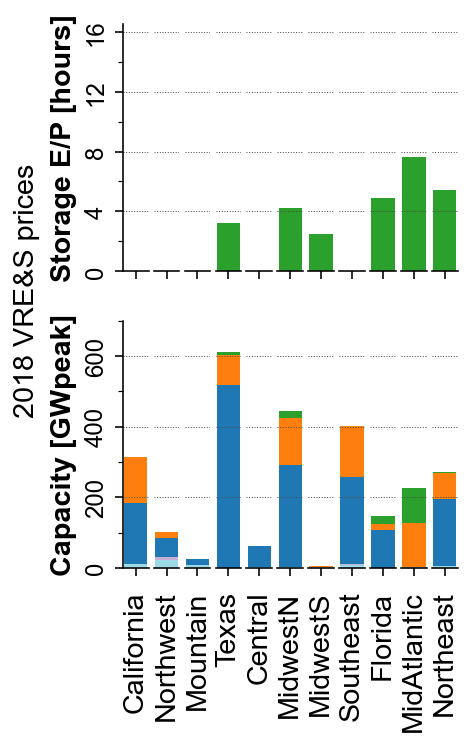

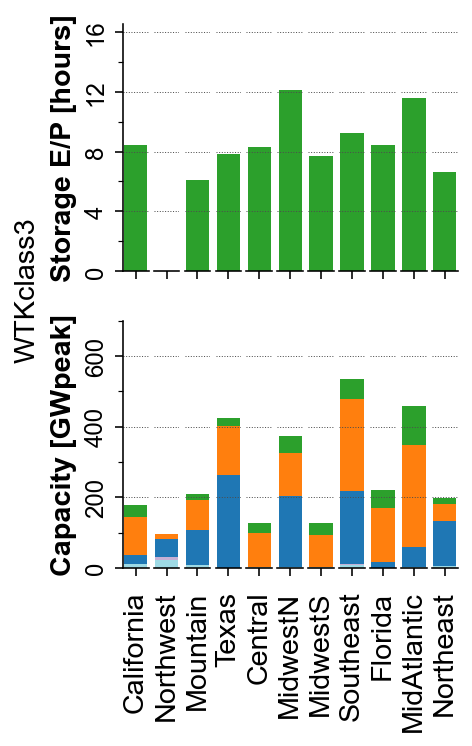

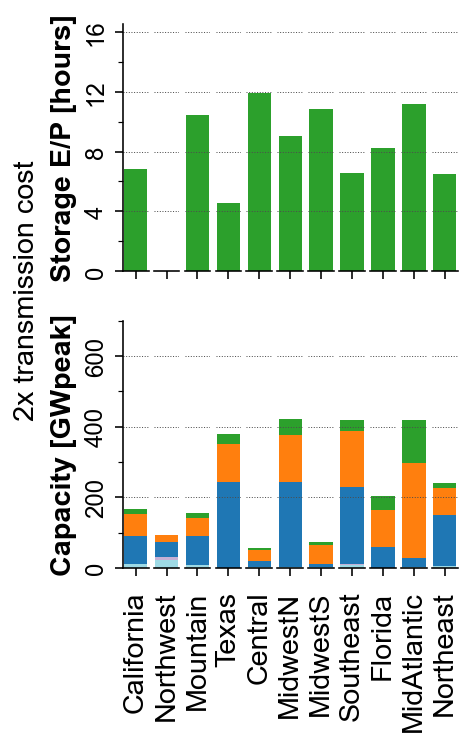

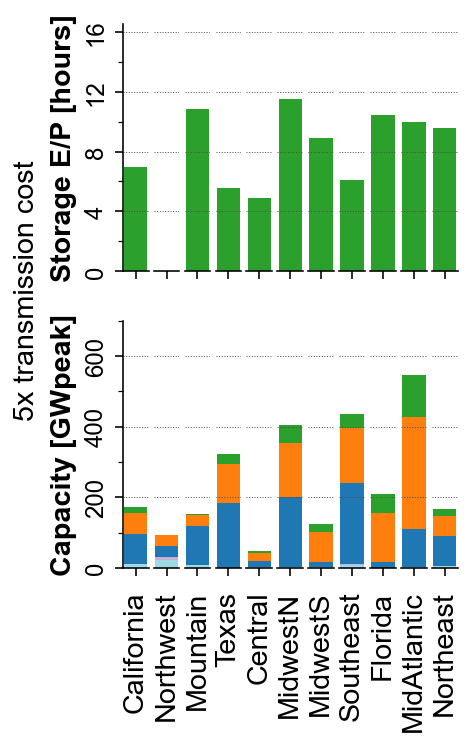

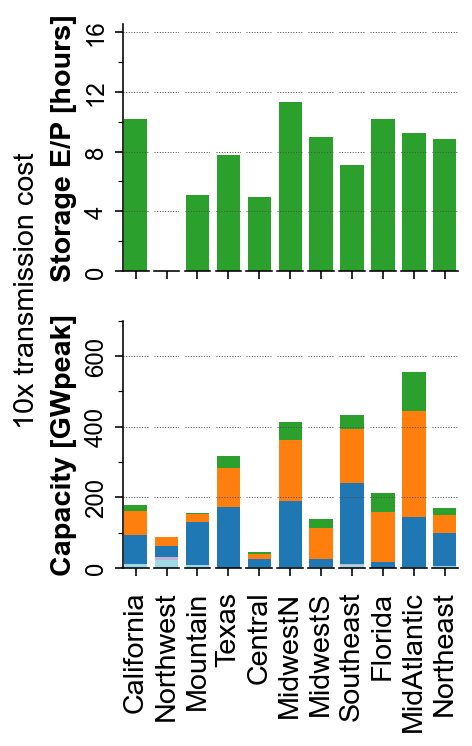

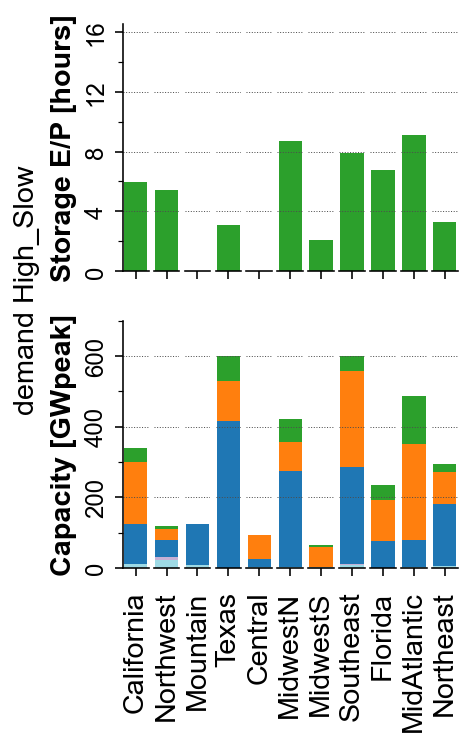

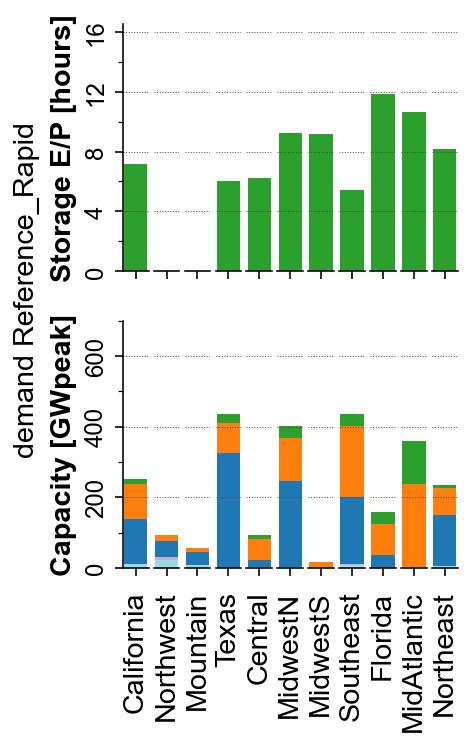

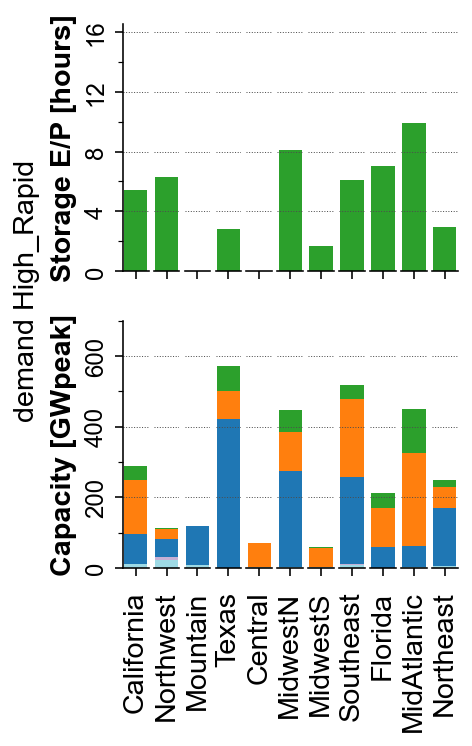

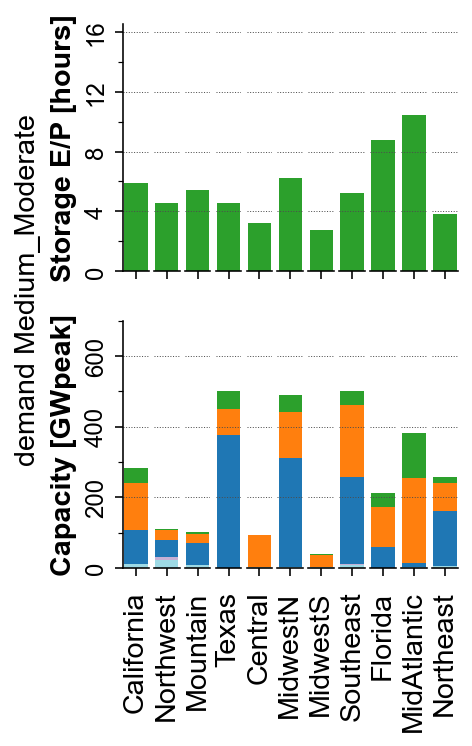

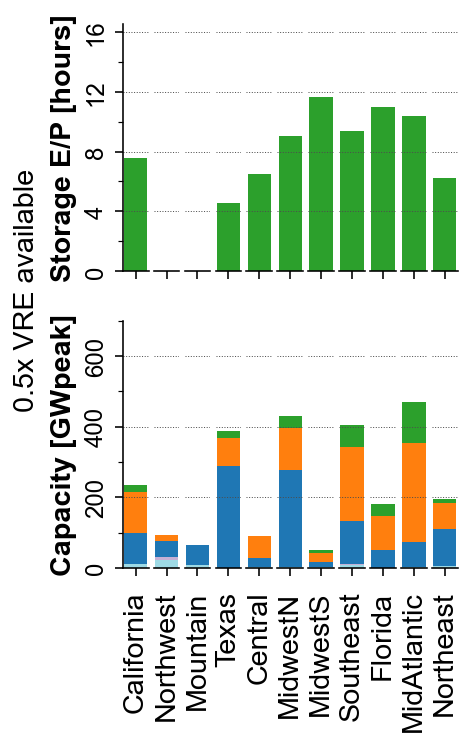

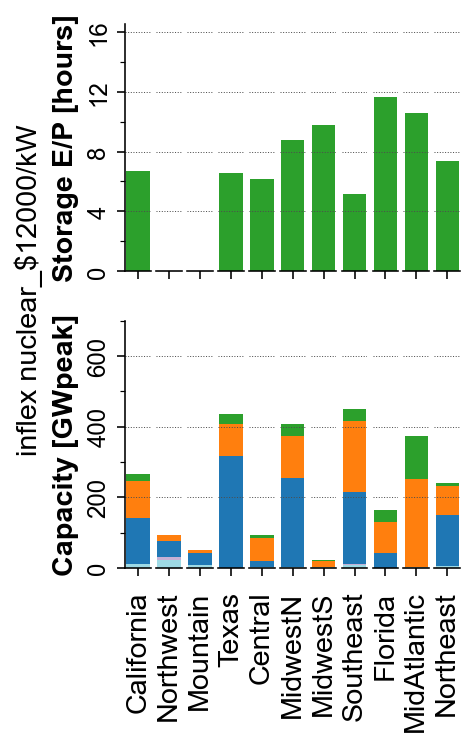

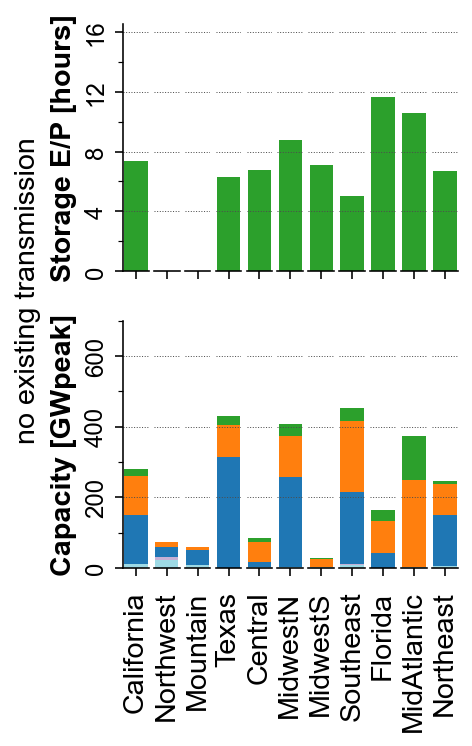

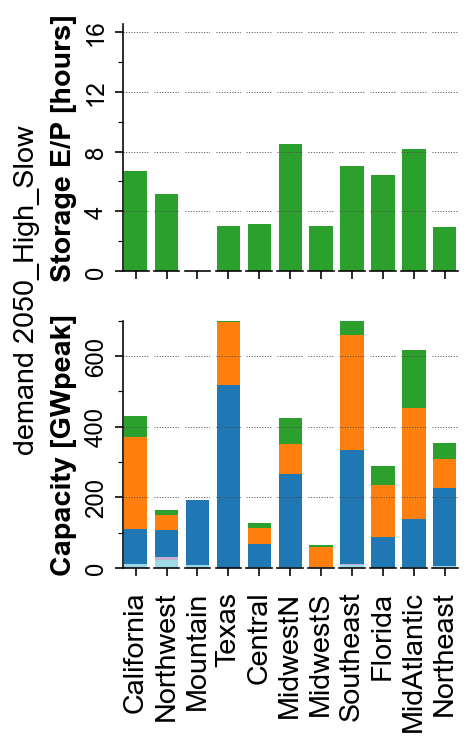

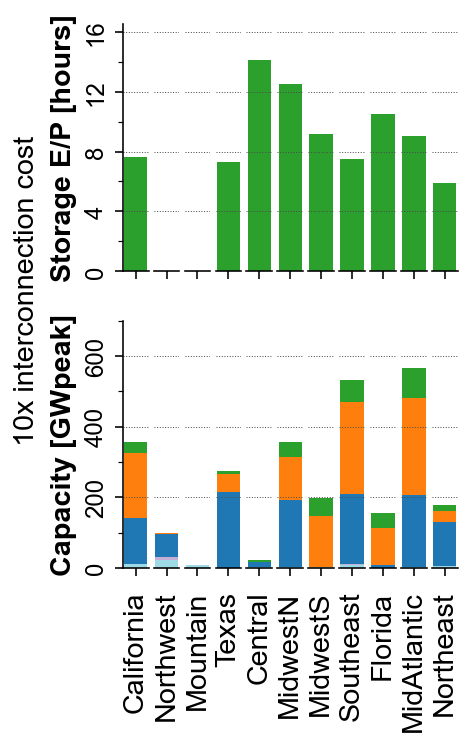

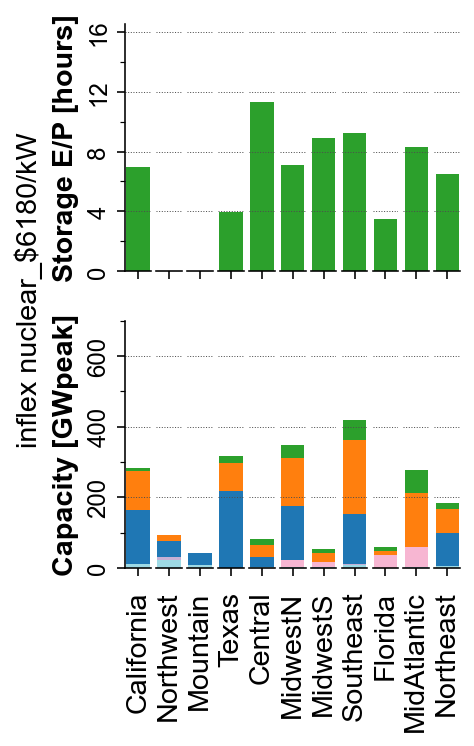

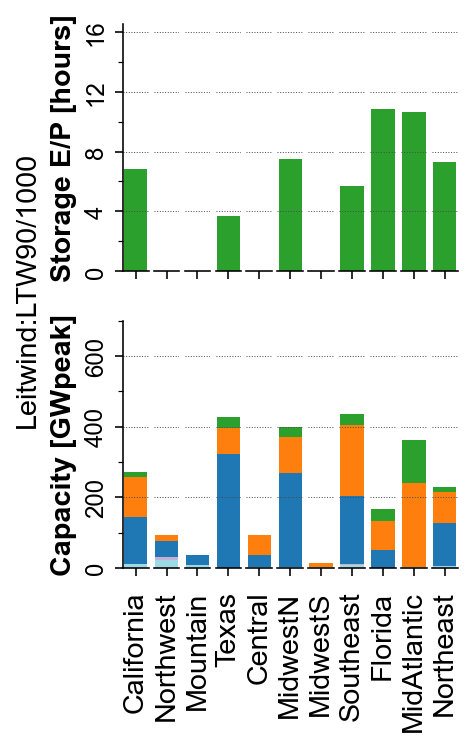

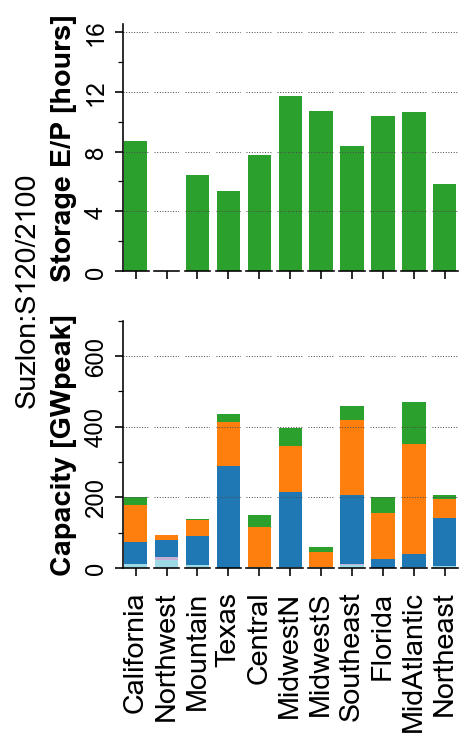

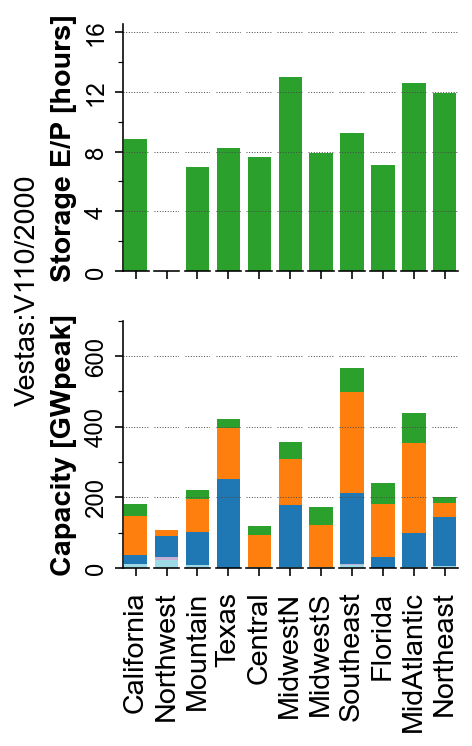

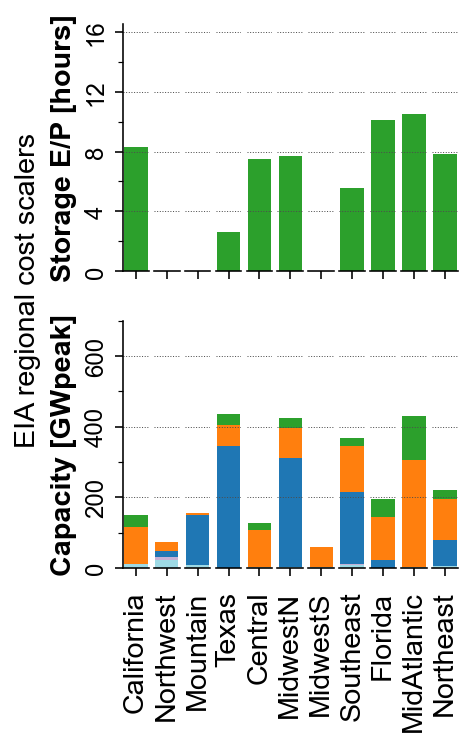

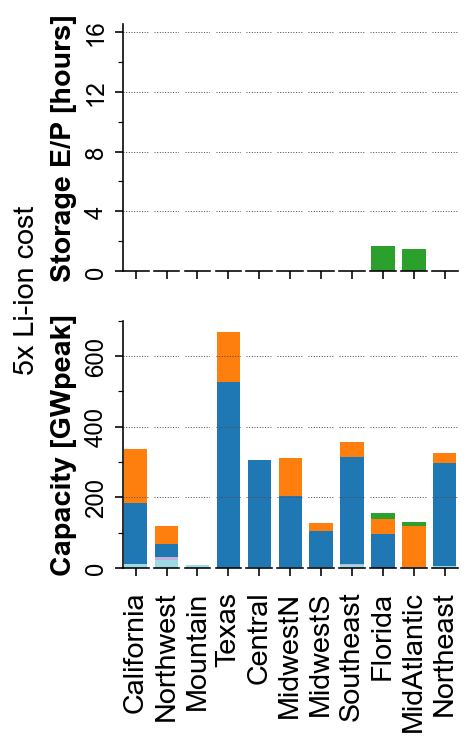

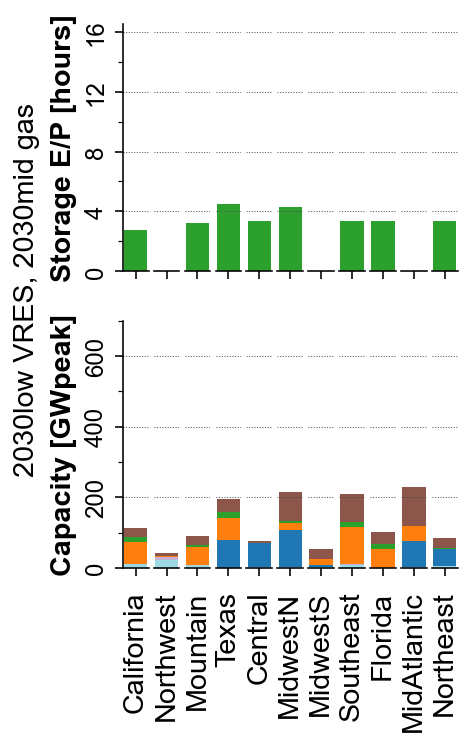

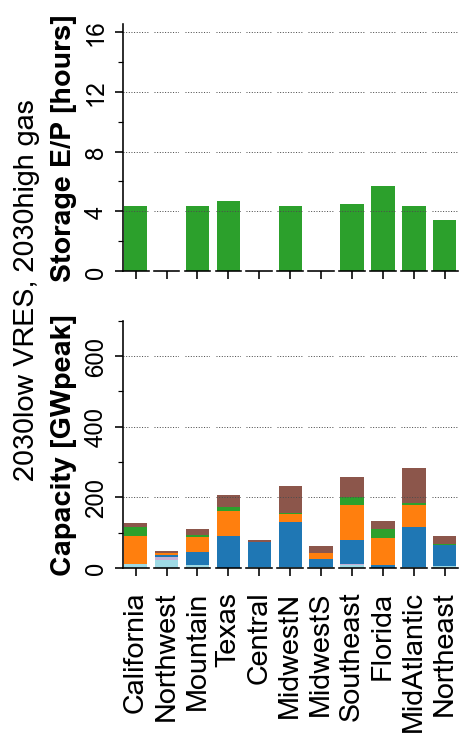

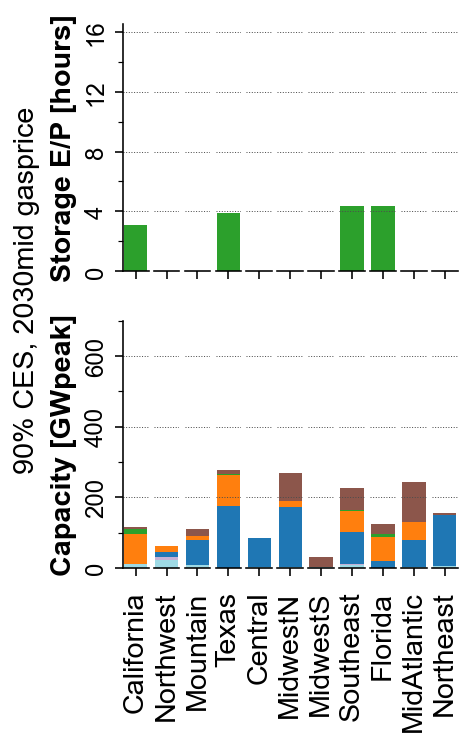

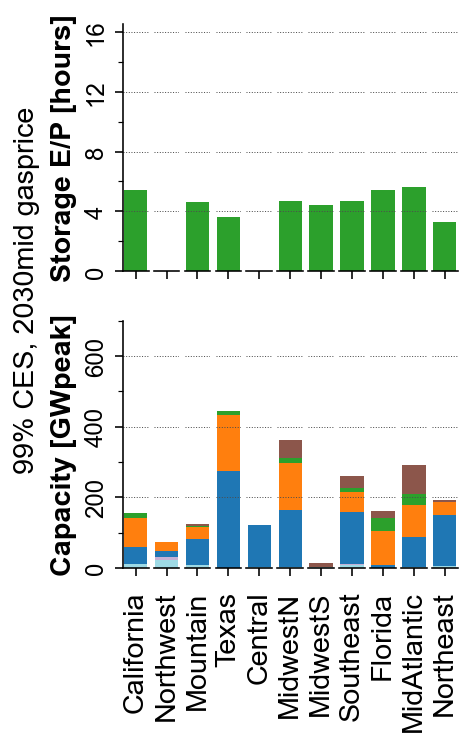

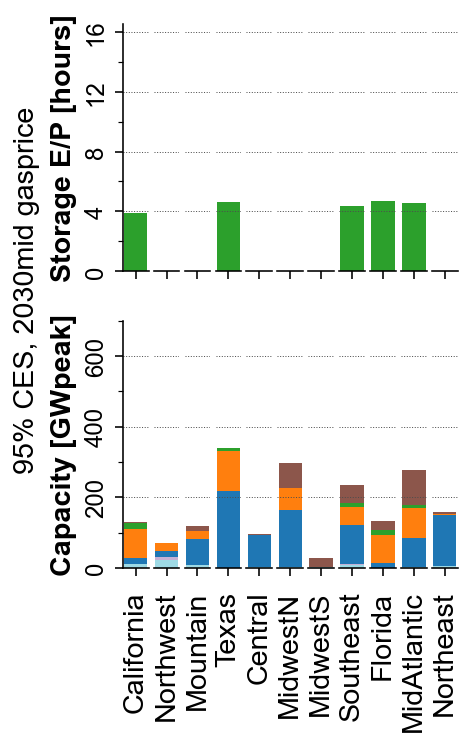

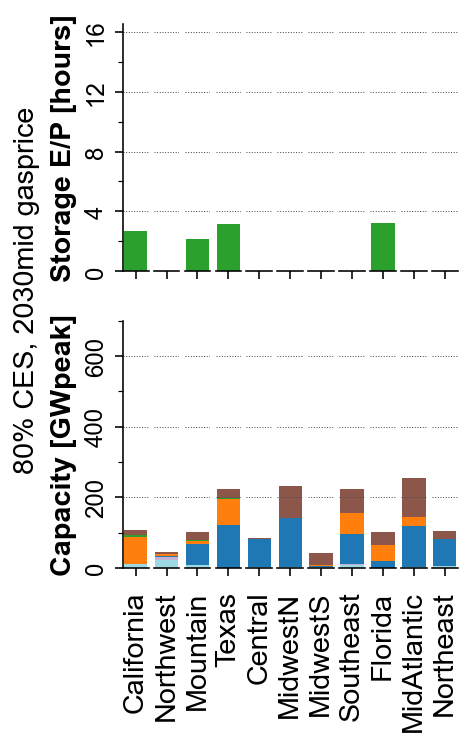

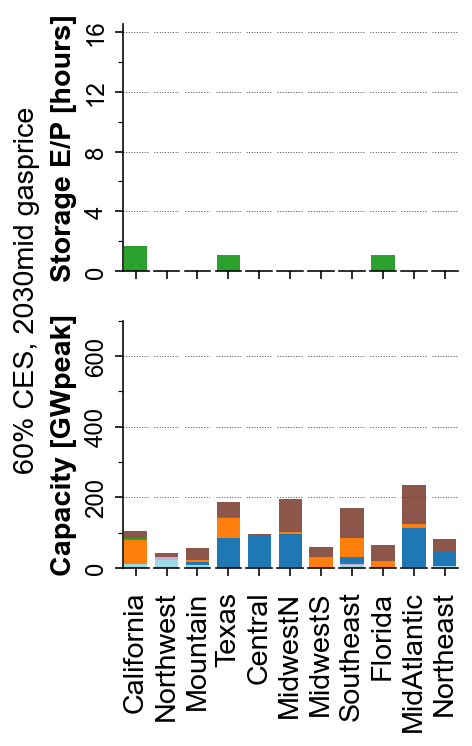

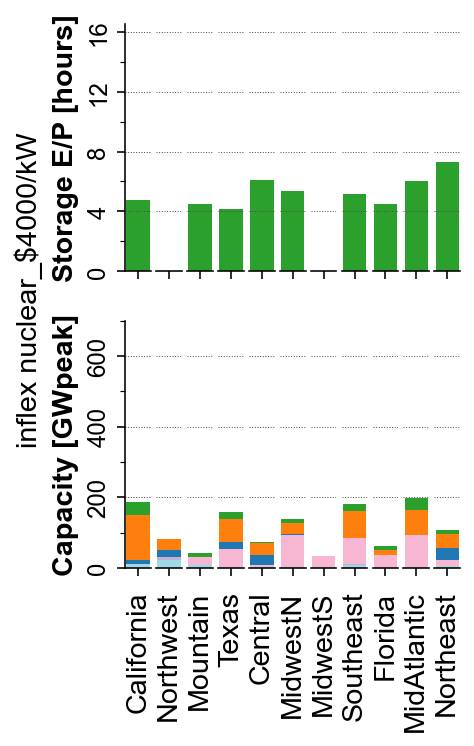

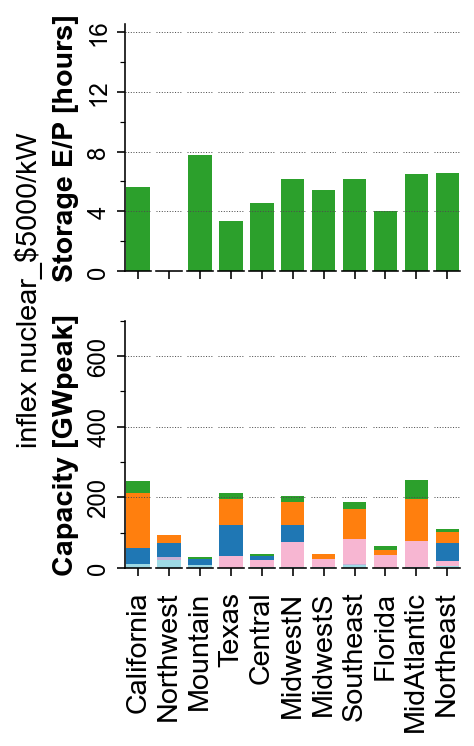

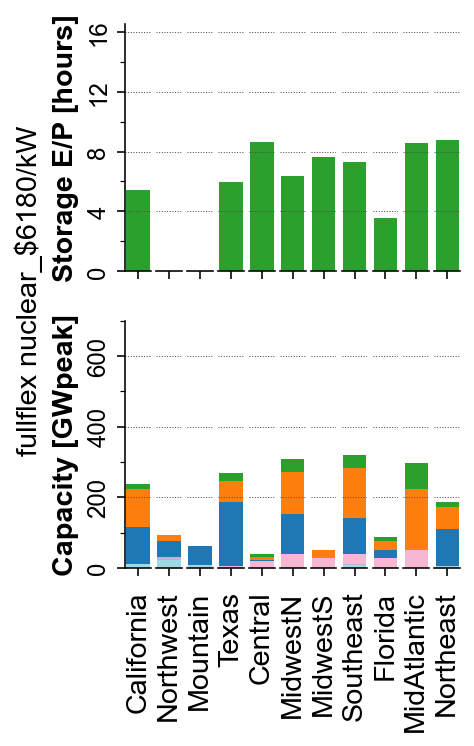

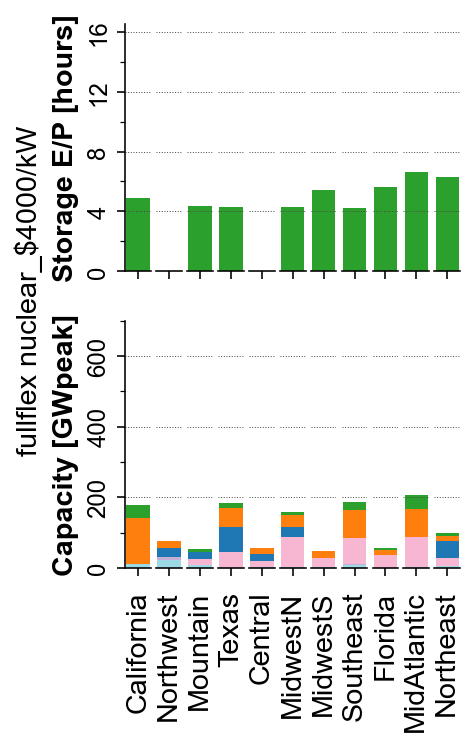

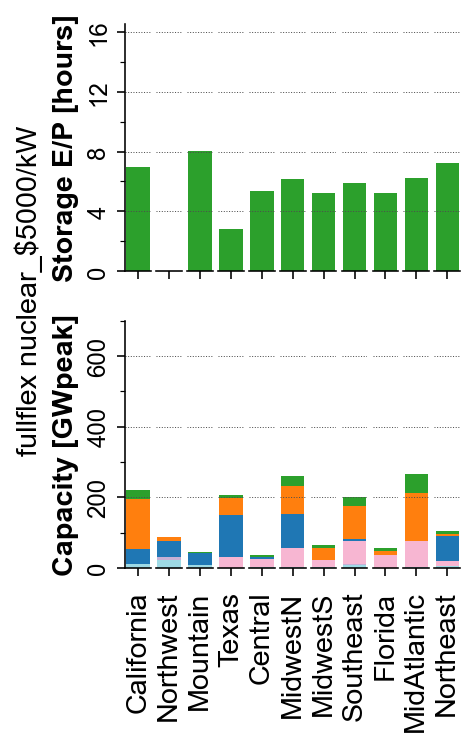

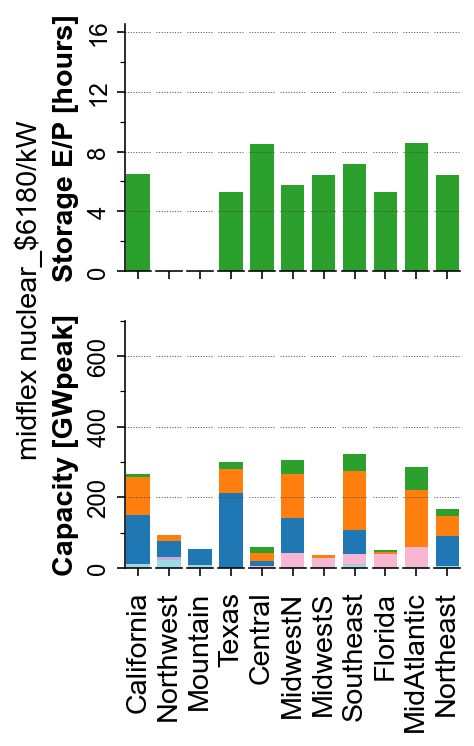

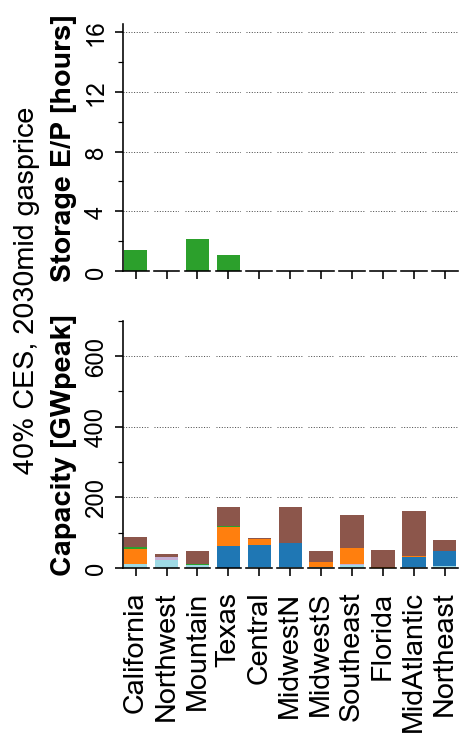

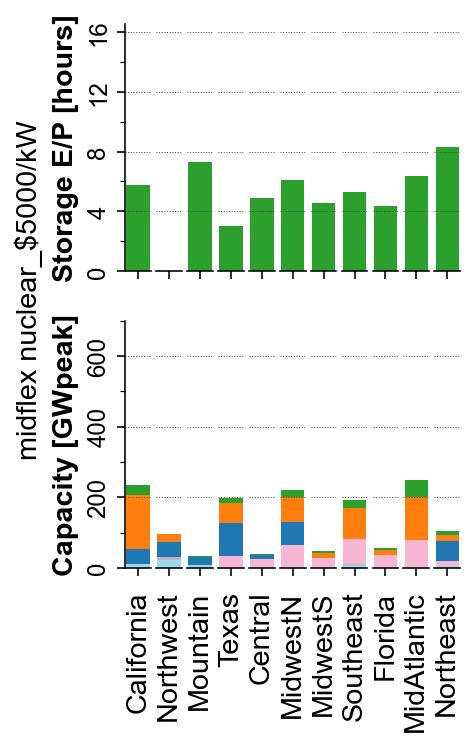

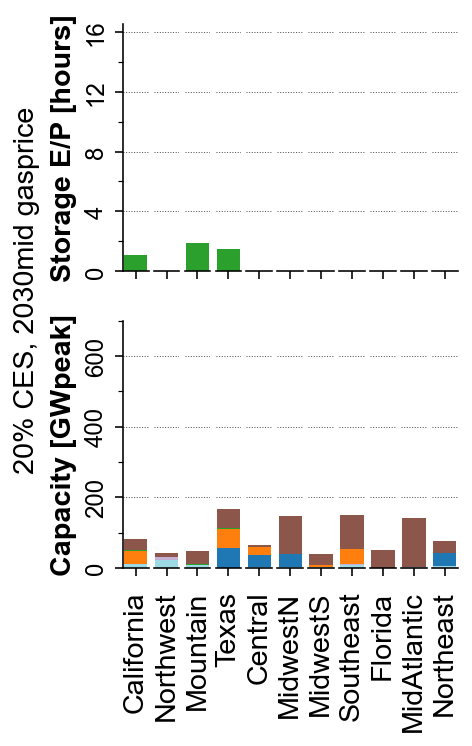

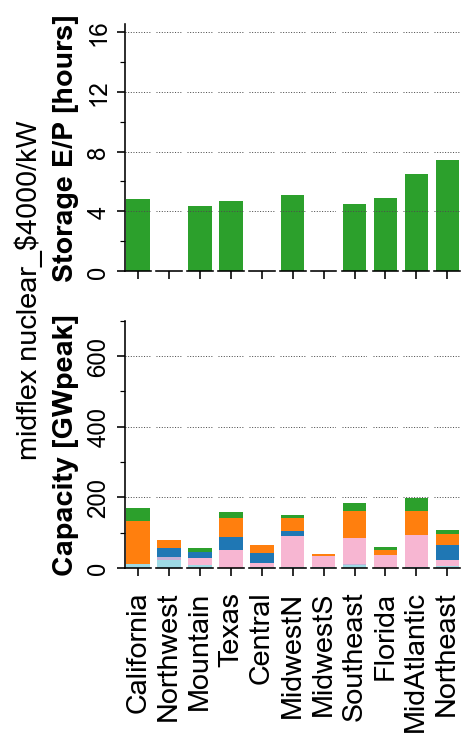

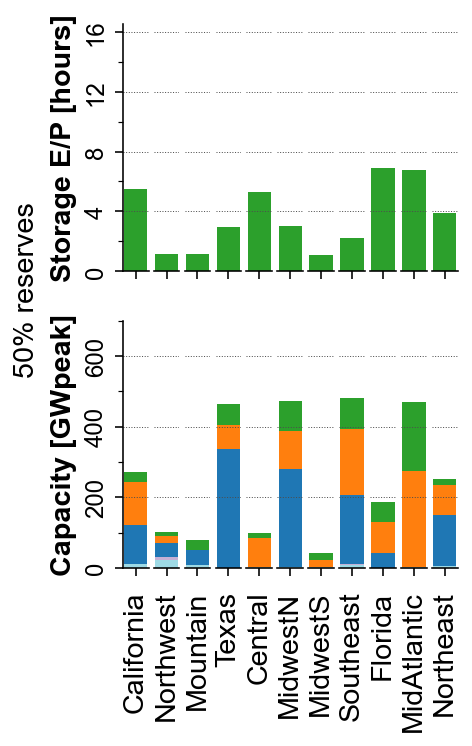

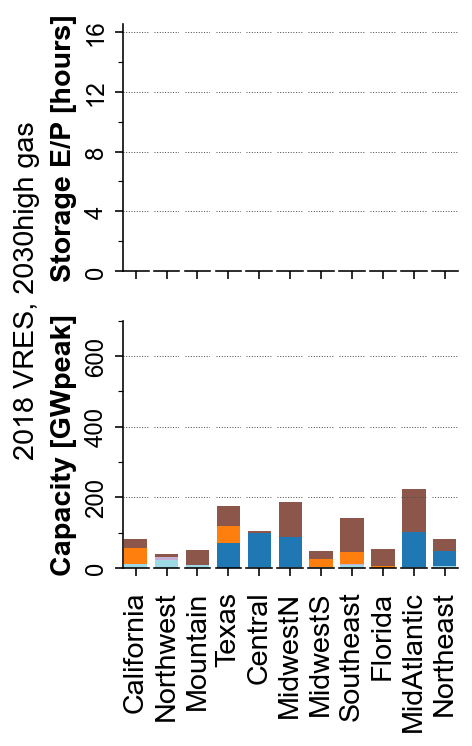

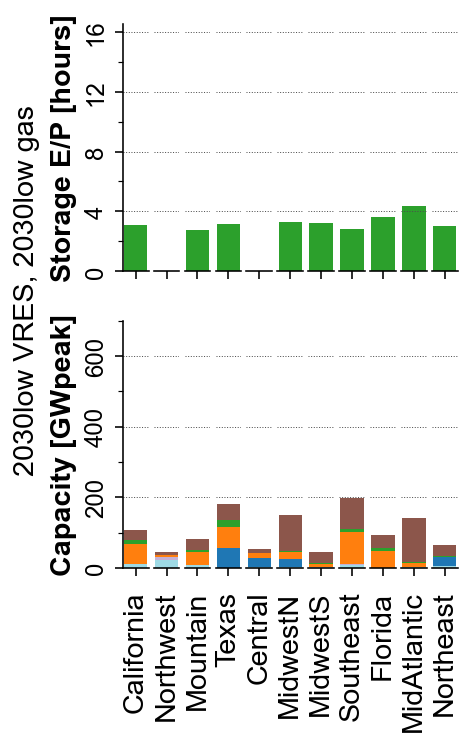

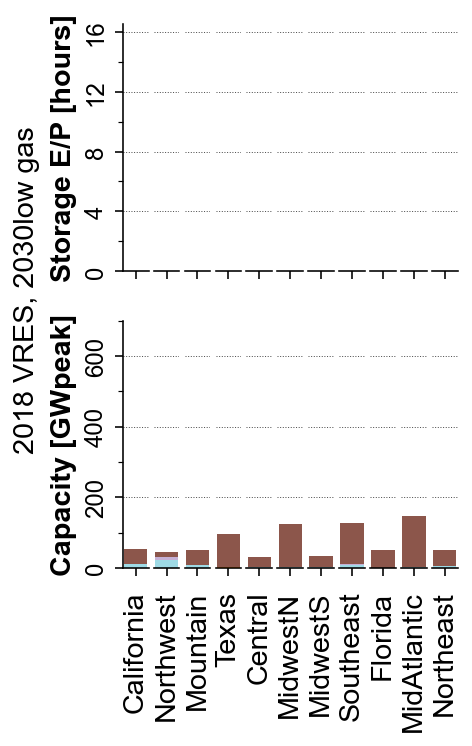

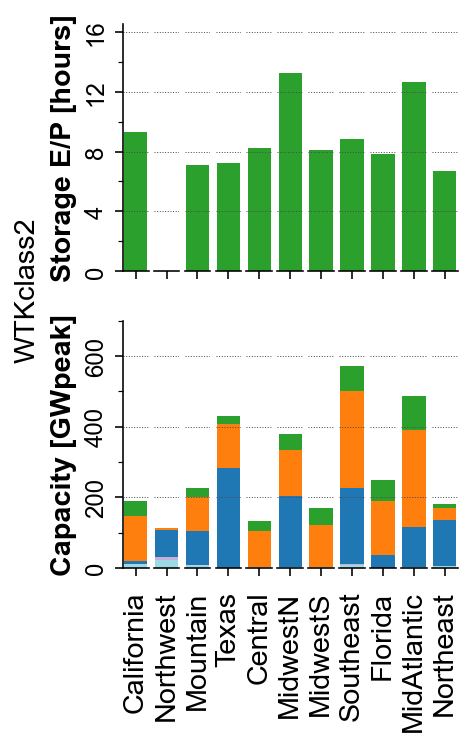

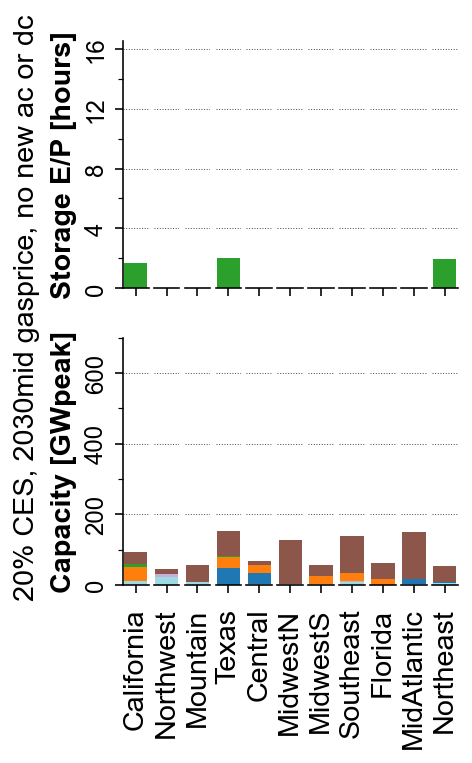

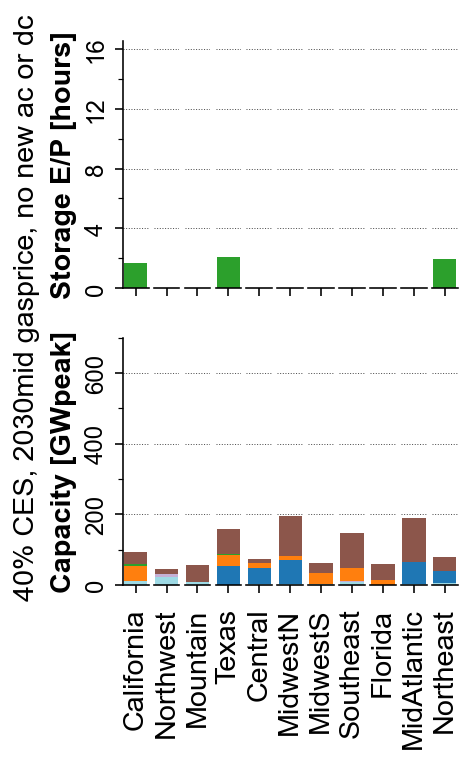

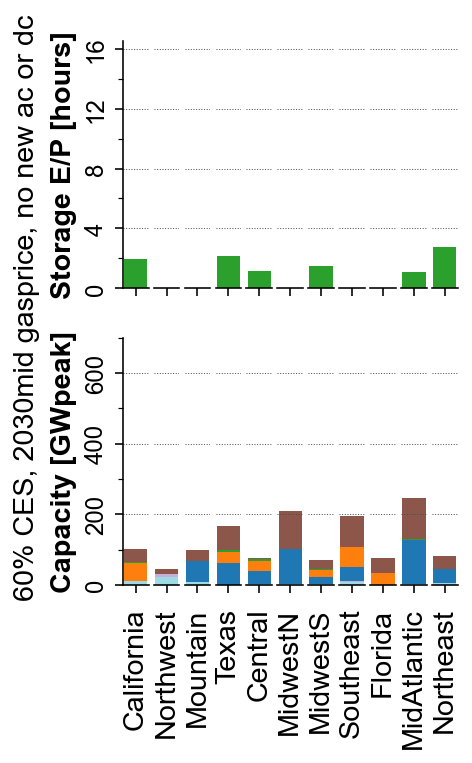

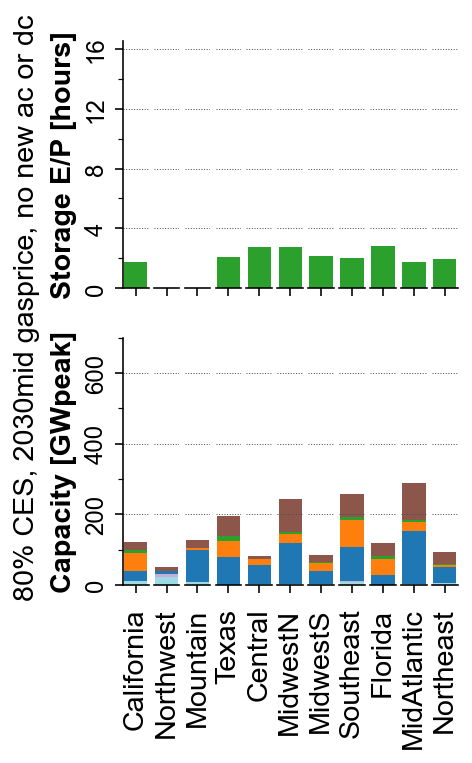

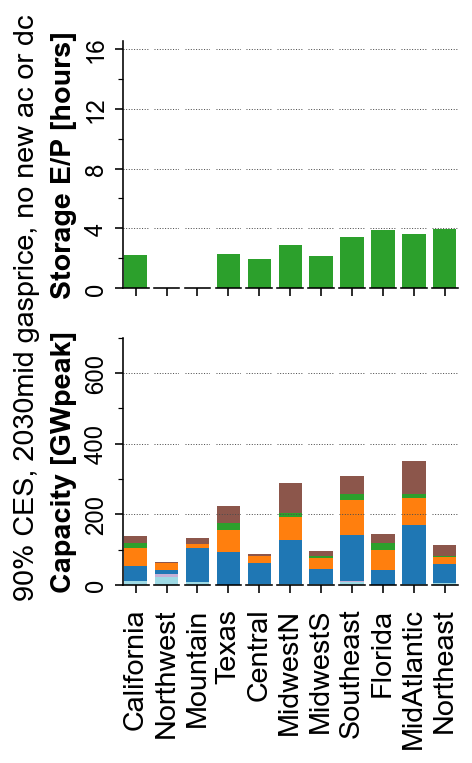

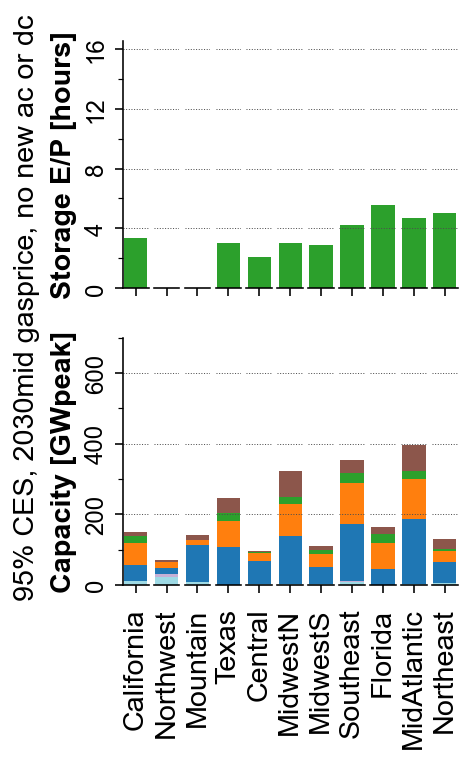

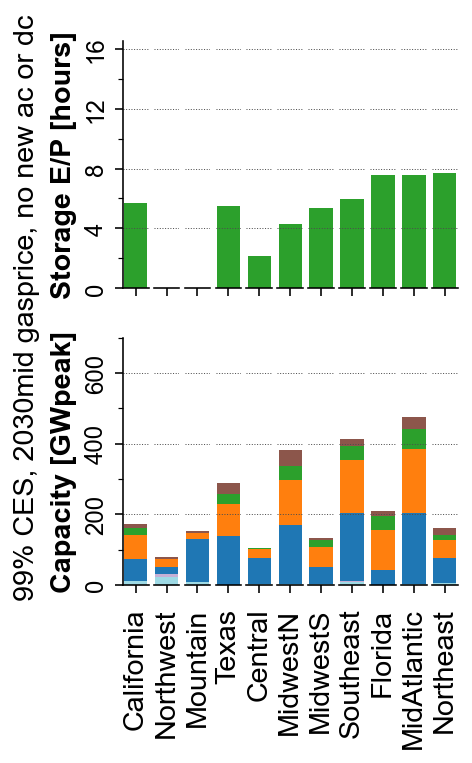

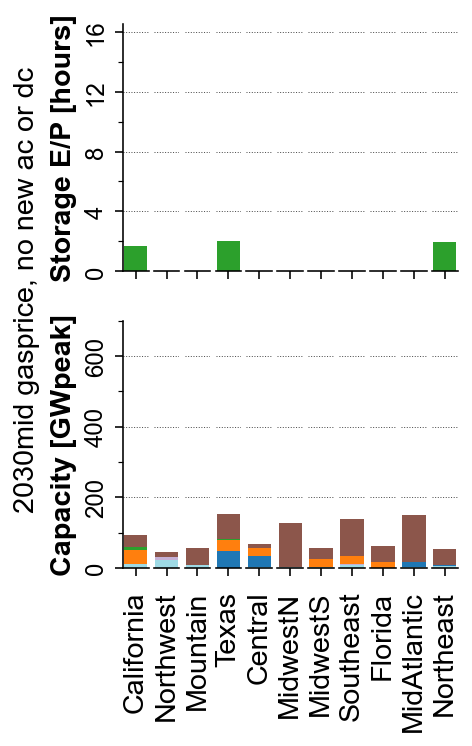

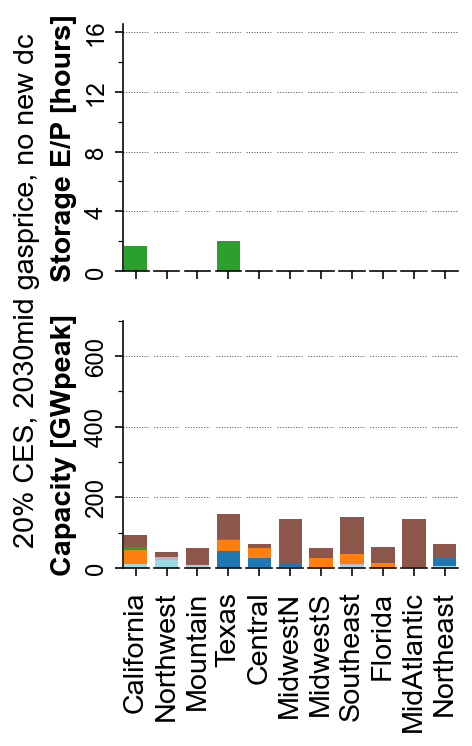

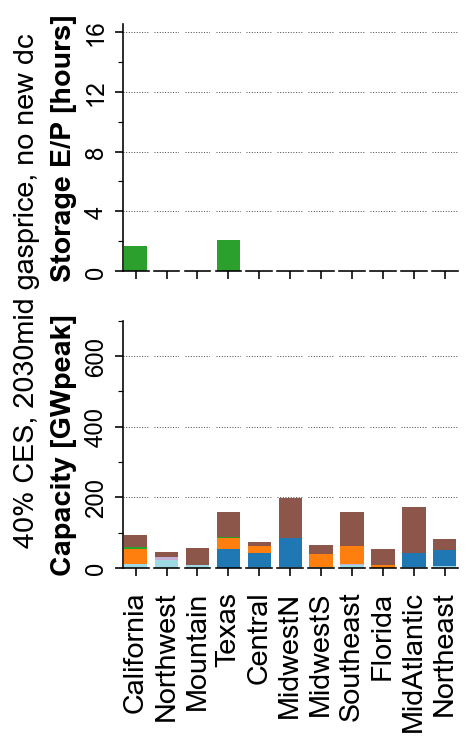

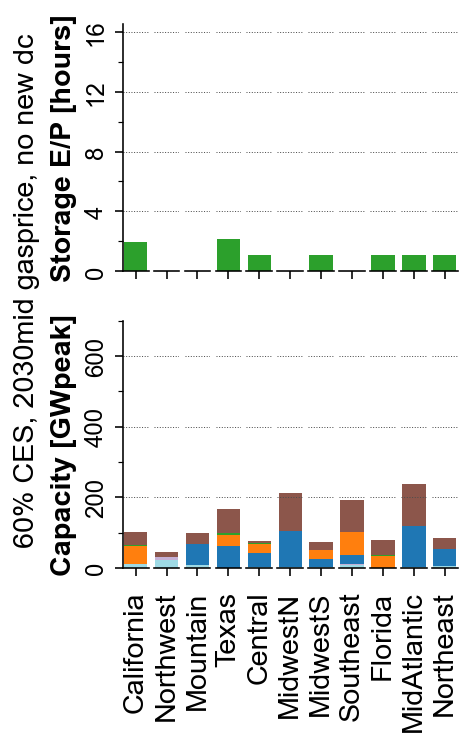

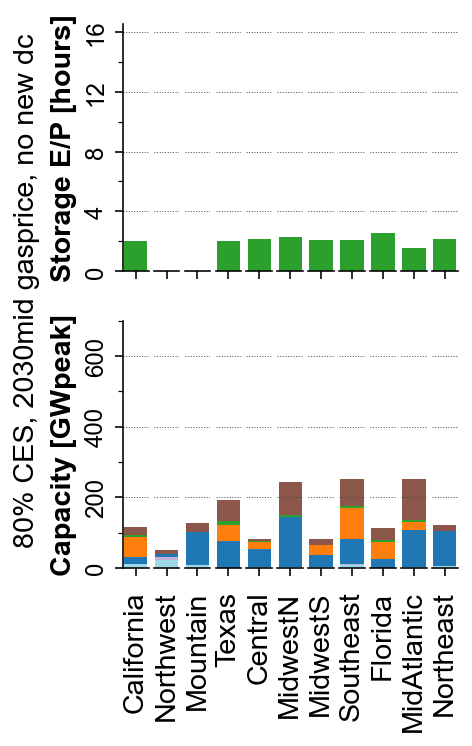

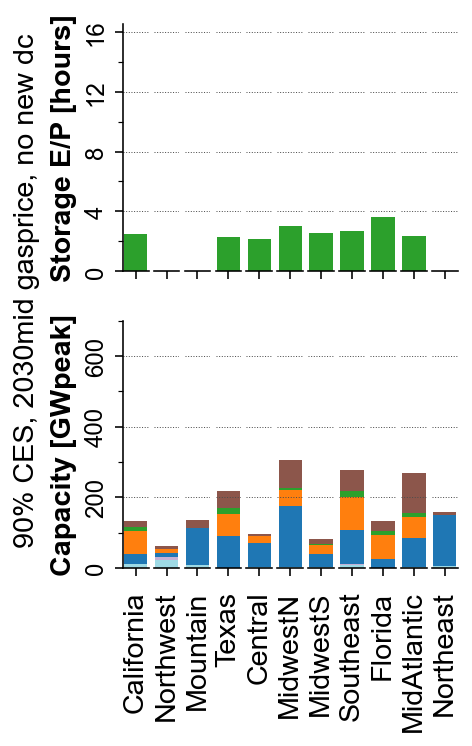

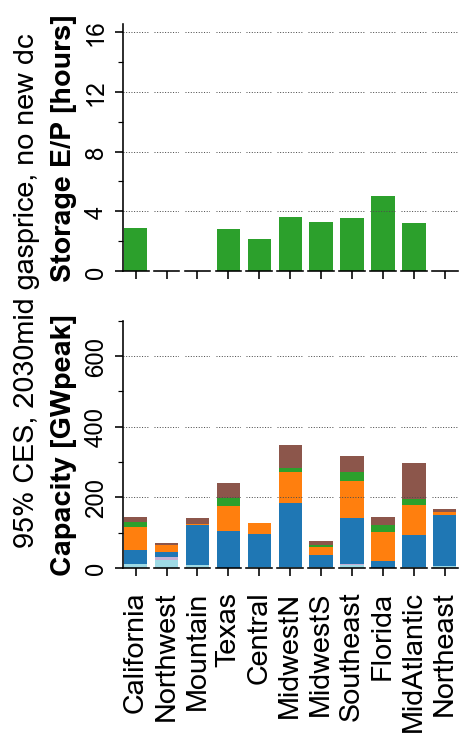

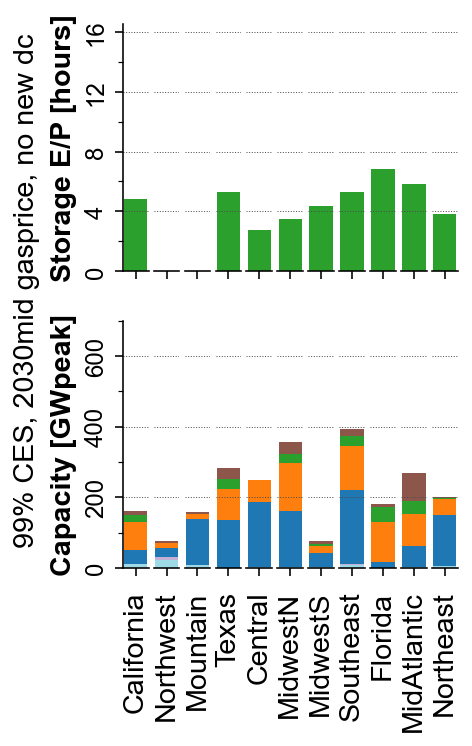

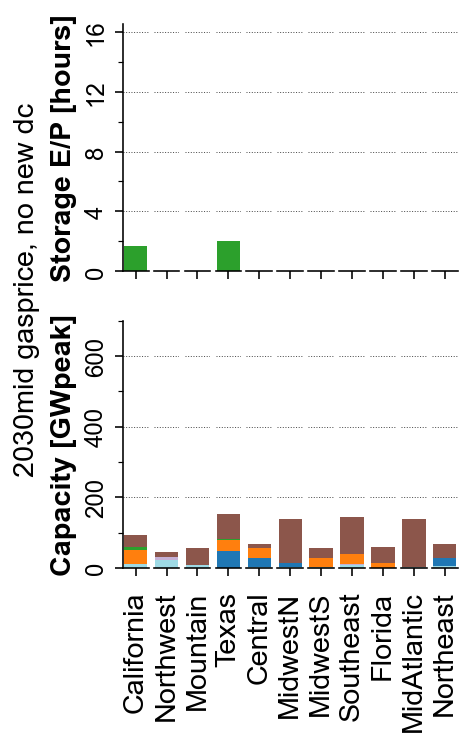

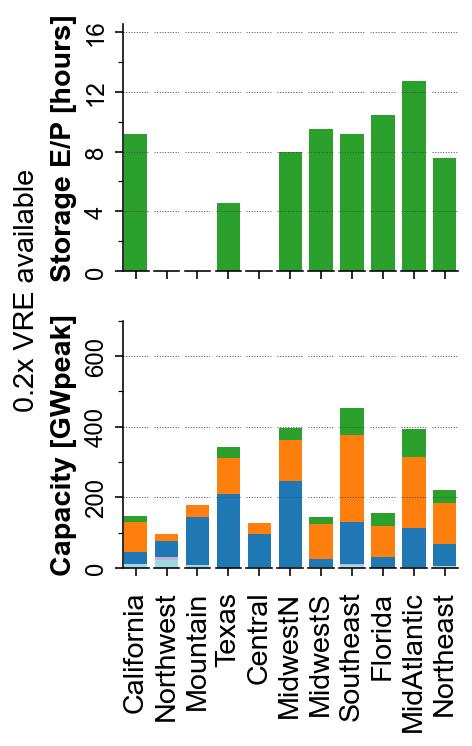

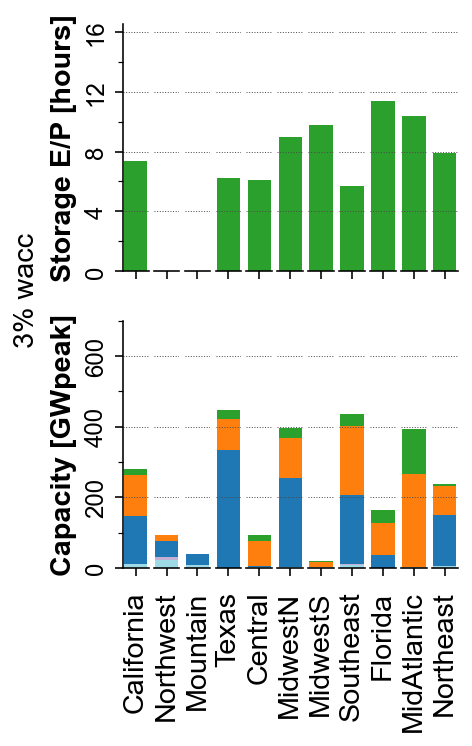

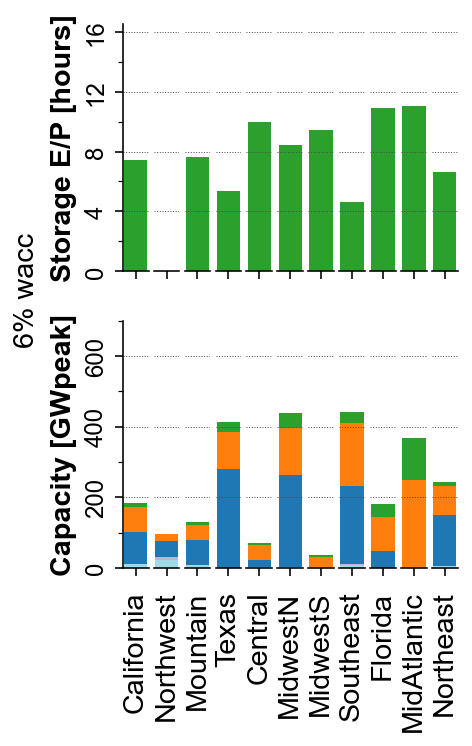

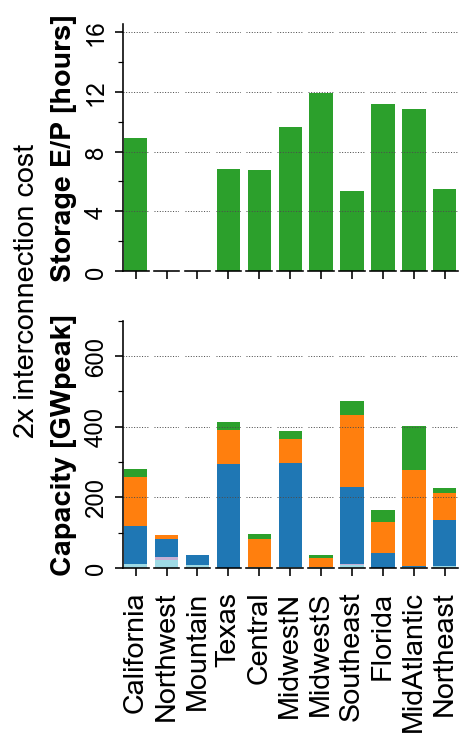

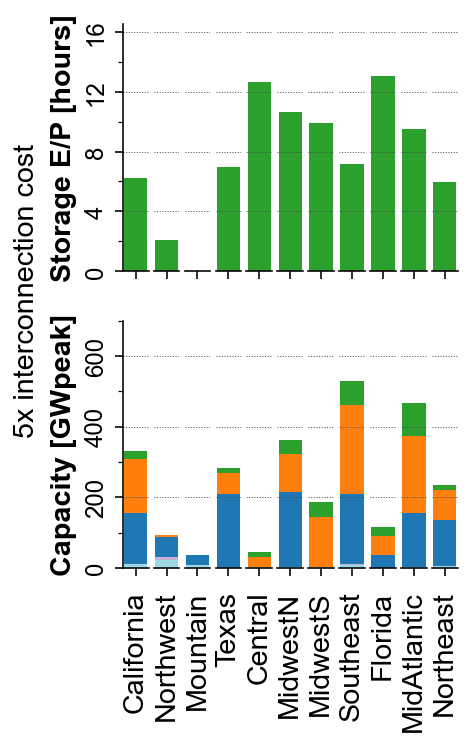

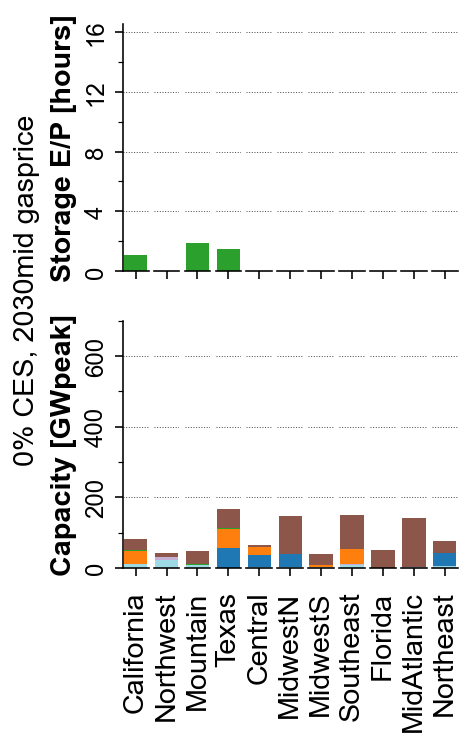

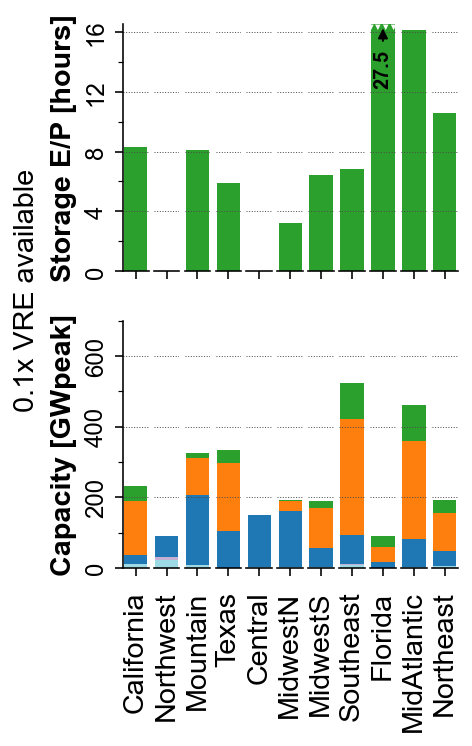

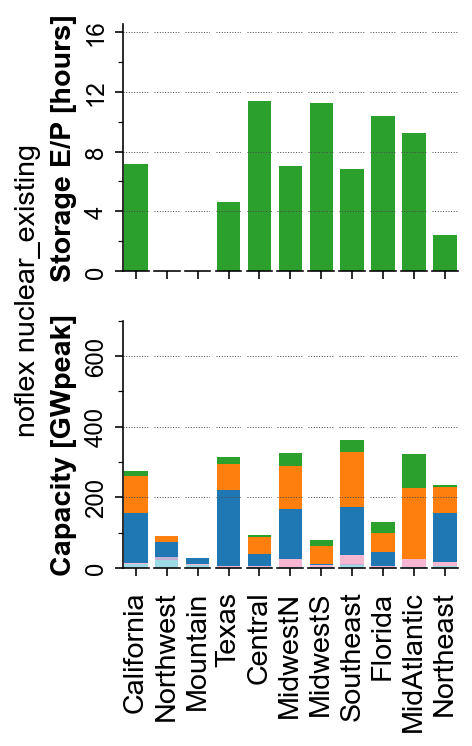

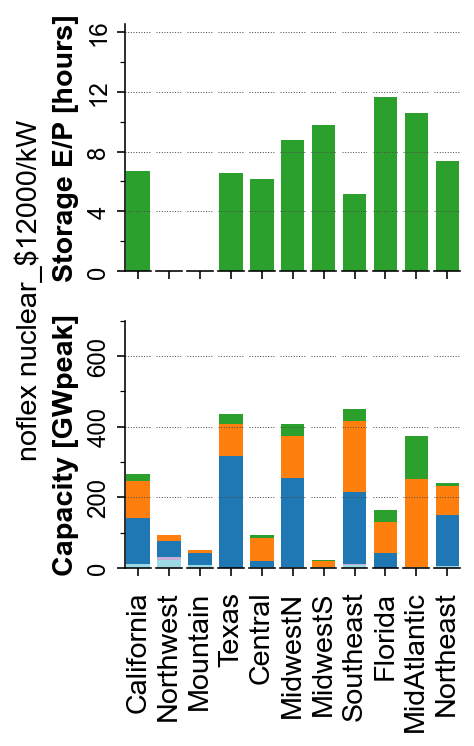

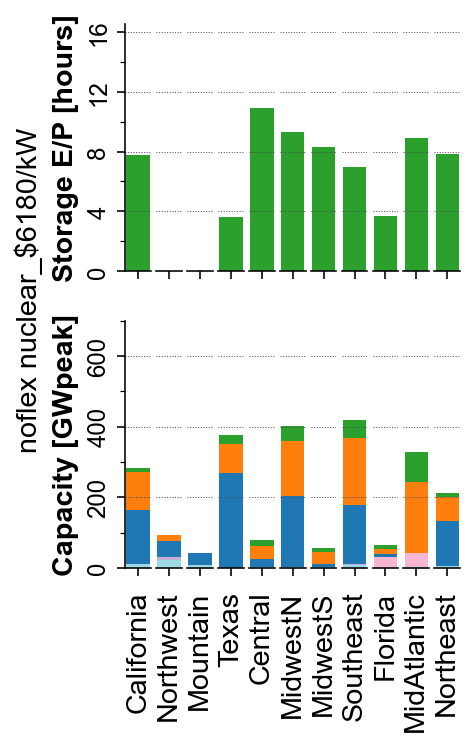

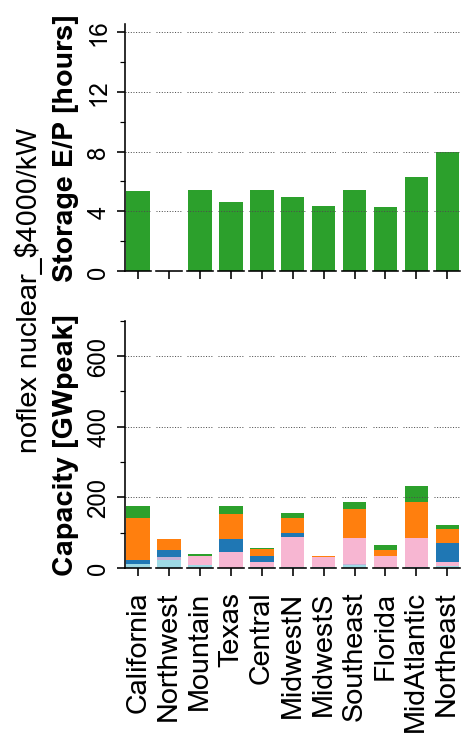

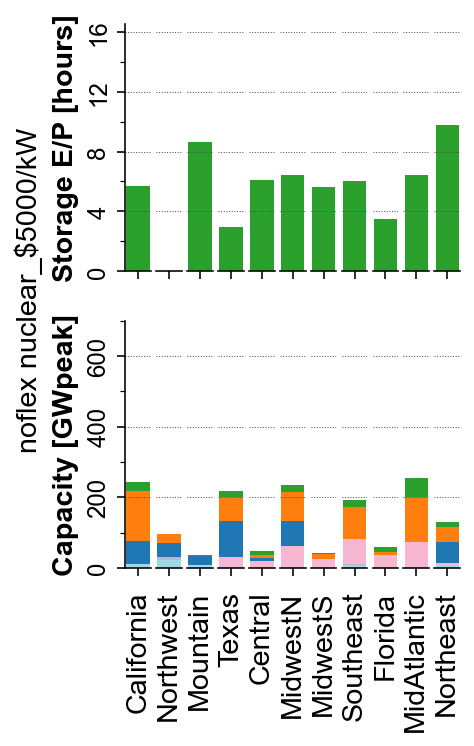

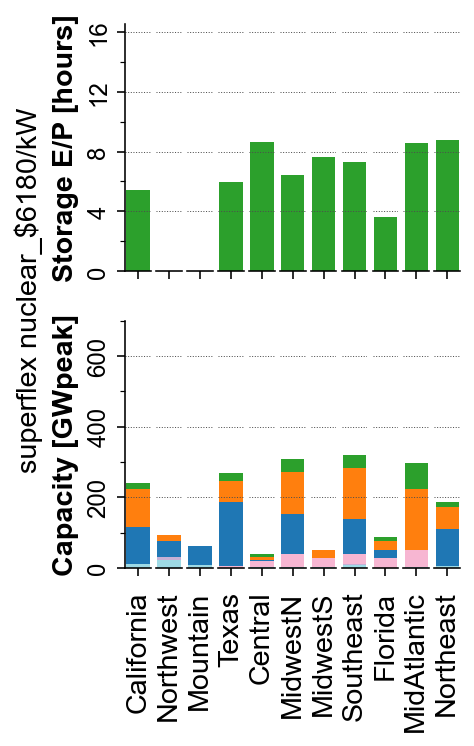

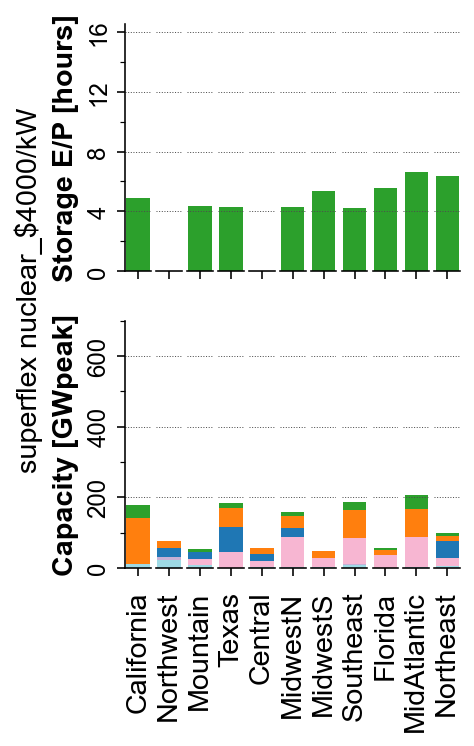

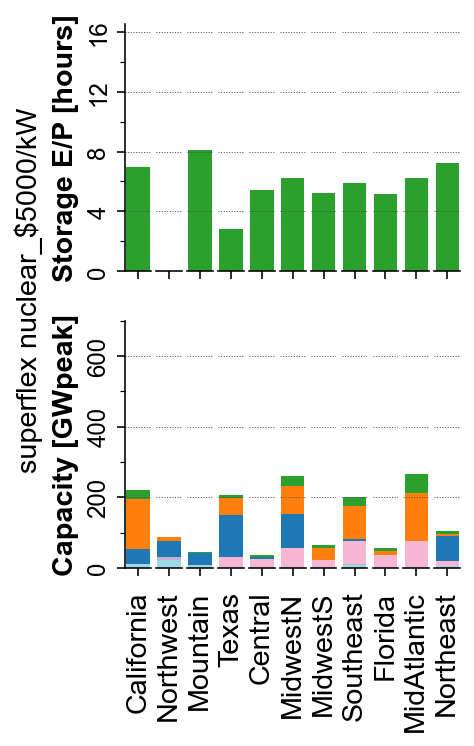

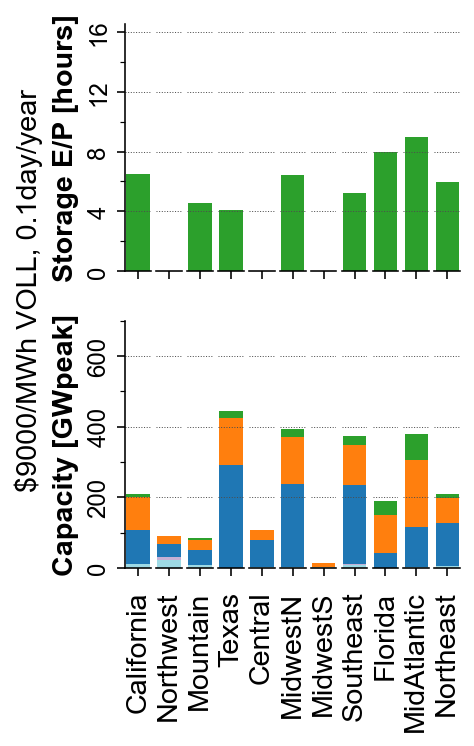

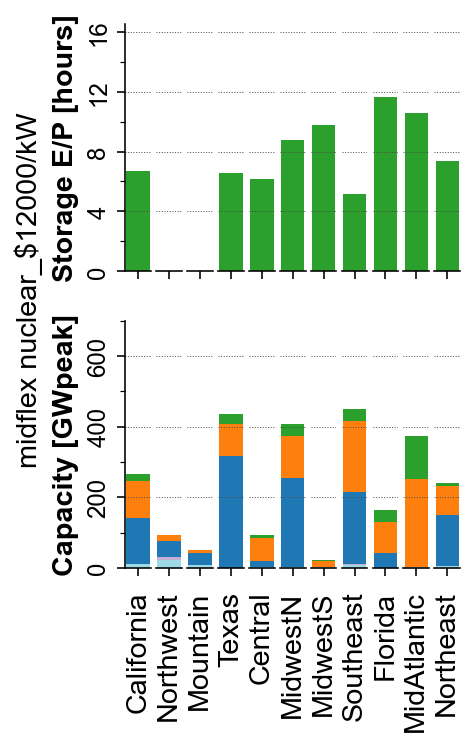

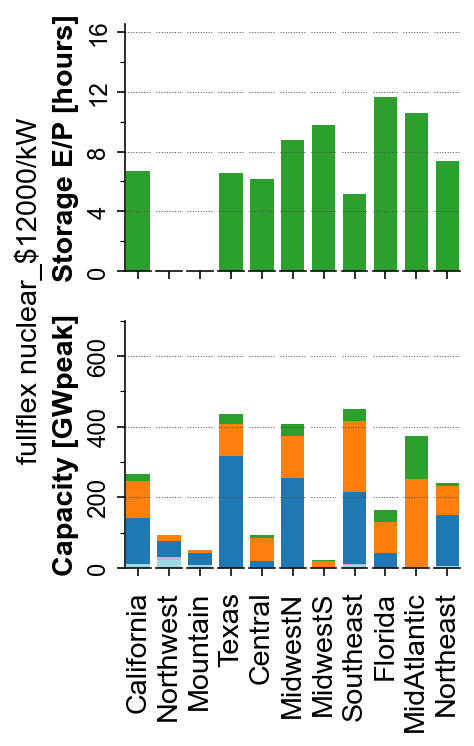

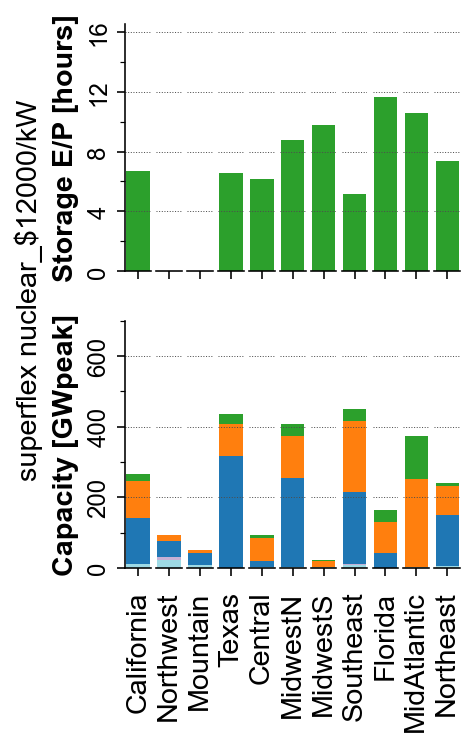

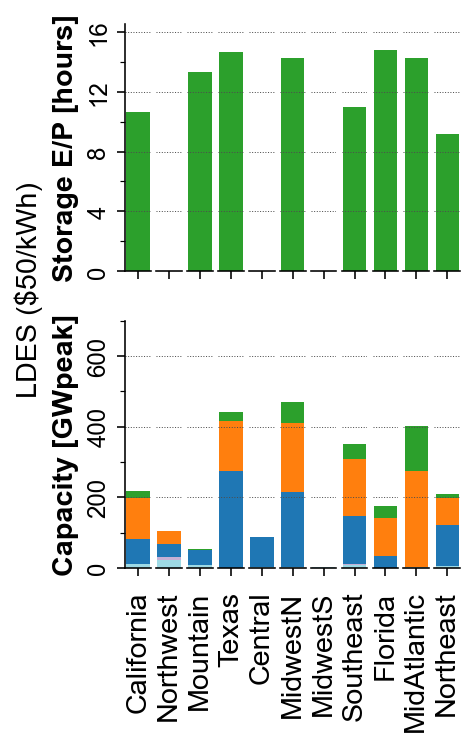

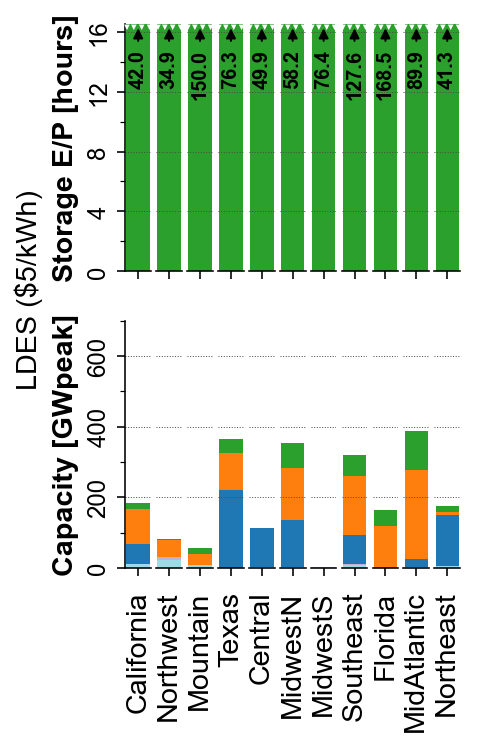

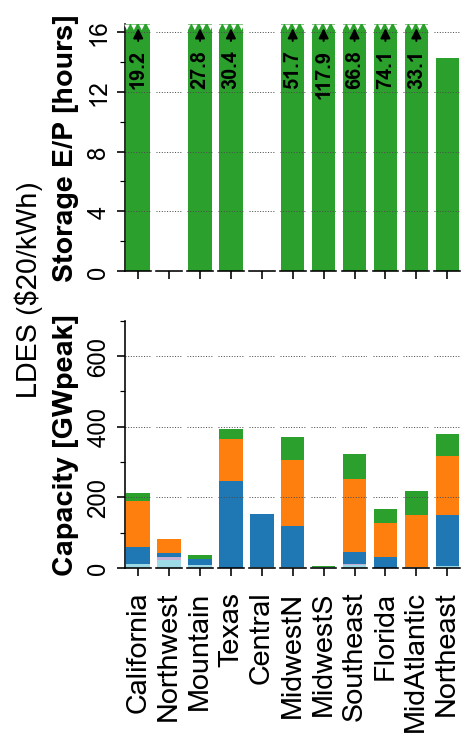

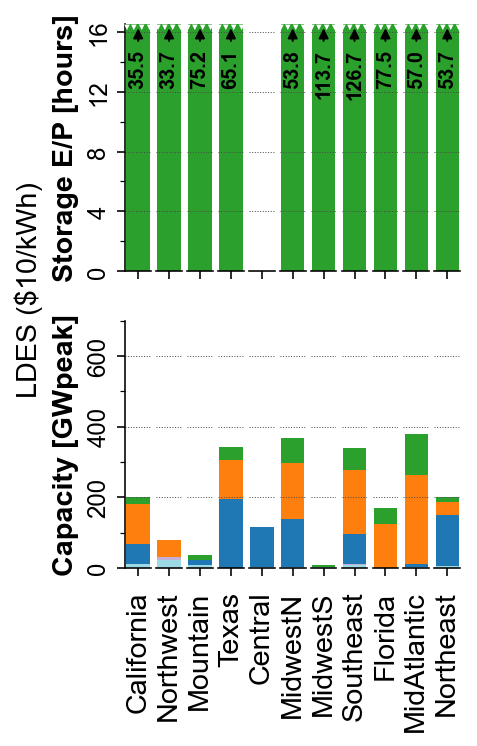

In [35]:
ylim = 16.5
### Plot everything
for case in barindex.values():
    ###### Power capacity
    frameon = False
    alpha = 1

    plt.close()
    f,ax=plt.subplots(2,len(bas), figsize=(3,5), sharex=True, sharey='row')
    ###### Capacity
    dfplot = pd.concat(
        [
            pd.DataFrame(
                {
                    'Hydro_Res': (float(dictout[case]['cap']['Hydro_Res_{}'.format(ba)])
                                  if 'Hydro_Res_{}'.format(ba) in dictout[case]['cap'].index else 0),
                    'Hydro_ROR': (float(dictout[case]['cap']['Hydro_ROR_{}'.format(ba)])
                                  if 'Hydro_ROR_{}'.format(ba) in dictout[case]['cap'].index else 0),
                    'PHS': (float(dictout[case]['cap']['PHS_{}_P'.format(ba)])
                            if 'PHS_{}_P'.format(ba) in dictout[case]['cap'].index else 0),
                    'Nuclear_old': (float(dictout[case]['cap']['Nuclear_{}_old'.format(ba)])
                                    if 'Nuclear_{}_old'.format(ba) in dictout[case]['cap'].index else 0),
                    'Nuclear_new': (float(dictout[case]['cap']['Nuclear_{}_new'.format(ba)])
                                    if 'Nuclear_{}_new'.format(ba) in dictout[case]['cap'].index else 0),
                    'Wind': sum([float(dictout[case]['cap']['Wind_{}_{}'.format(ba,windbin)])
                                 for windbin in windbins]),
                    'PV': float(dictout[case]['cap']['PV_{}_0'.format(ba)]),
                    'Stor': float(dictout[case]['cap']['Stor_{}_P'.format(ba)]),
                    'CCGT': (float(dictout[case]['cap']['CCGT_{}'.format(ba)])
                             if 'CCGT_{}'.format(ba) in dictout[case]['cap'].index else 0),
                    'OCGT': (float(dictout[case]['cap']['OCGT_{}'.format(ba)])
                             if 'OCGT_{}'.format(ba) in dictout[case]['cap'].index else 0),
                }, index=[ba]
            ).T
            for ba in bas
        ], axis=1
    ).fillna(0)

    for col, ba in enumerate(bas):
        ax[1,col].bar(
            x=[0], 
            height=dfplot[ba].values, 
            bottom=dfplot[ba].cumsum().shift(1).fillna(0),
            width=1, color=colorlist,
        )

    ###### Storage energy
    dfplot = pd.DataFrame(
        {ba: 
         (float(dictout[case]['cap']['Stor_{}_E'.format(ba)])
          / float(dictout[case]['cap']['Stor_{}_P'.format(ba)])
          if float(dictout[case]['cap']['Stor_{}_P'.format(ba)]) > 0 else 0)
         for ba in bas
        }, index=['Stor']
    )

    for col, ba in enumerate(bas):
        val = dfplot.loc['Stor',ba]
        ax[0,col].bar(
            x=[0], 
            height=[val], 
            # bottom=dfplot[ba].cumsum().shift(1).fillna(0),
            width=1, color=colors[('Stor', '_P')],
        )
        
        ### Out-of-scale labels
        if val > ylim:
            ax[0,col].annotate(
                '▼▼▼▼',#'/\\/\\/\\',#'|||||||', 
                xy=(0.5,1.0015), xycoords='axes fraction', ha='center', va='top',
                color='w', fontsize=4)
            ax[0,col].annotate(
                '{:.1f}'.format(val), xy=(0.5,1), xytext=(0.5,0.9),
                xycoords='axes fraction', weight='bold',
                ha='center', va='top', rotation=90,
                arrowprops={'arrowstyle':'-|>', 'color':'k'}, 
            )

    ### Formatting
    for col, ba in enumerate(bas):
        ax[1,col].set_xticks([0])
        ax[1,col].set_xticklabels([''])
        ax[1,col].set_xlabel(ba, rotation=90, weight='normal')
    for row in range(2):
        for col in range(len(bas)):
            ax[row,col].grid(which='major', axis='y', c='0.3', ls=':', lw=0.5)
        for col in range(1,len(bas)):
            zephyr.plots.despine(ax[row,col],left=False)
        zephyr.plots.despine(ax[row,0])

    ax[0,0].yaxis.set_major_locator(MultipleLocator(4))
    ax[0,0].yaxis.set_minor_locator(AutoMinorLocator(2))
    l = np.arange(0,48,4)
    ax[0,0].set_yticks(l)
    ax[0,0].set_yticklabels(l, rotation=90, va='center')
    ax[0,0].set_ylim(0,ylim)
    # ax[0,0].set_ylabel('Storage E/P [GWh/GWac]')
    ax[0,0].set_ylabel('Storage E/P [hours]')
    # ax[0,5].set_title('{} ({})'.format(cases.loc[case,'notes'],case), pad=15)
    ax[0,0].annotate(
        #'{} ({})'.format(cases.loc[case,'notes'],case),
        cases.loc[case,'notes'].replace('RPS','CES'),
        xy=(-3.2,-0.075), xycoords='axes fraction', rotation=90, 
        ha='right', va='center', fontsize='x-large',
    )

    ###### Formatting
    ax[1,0].yaxis.set_major_locator(MultipleLocator(200))
    ax[1,0].yaxis.set_minor_locator(AutoMinorLocator(2))
    l = np.arange(0,1001,200)
    ax[1,0].set_yticks(l)
    ax[1,0].set_yticklabels(l, rotation=90, va='center')
    ax[1,0].set_ylim(0,700)
    ax[1,0].set_ylabel('Capacity [GWpeak]')
    for col in range(1,len(bas)):
        zephyr.plots.despine(ax[1,col],left=False)
    if save:
        os.makedirs(os.path.join(figpath,'ba-capacity',''),exist_ok=True)
        savename = 'ba-capacity/ba-capacity-7yearbar-mainscale-{}'.format(case)
        plt.savefig(figpath+savename+'.png')
        plt.savefig(figpath+savename+'.pdf')
    plt.show()

# Escalating CES

In [36]:
colors = {
    'Hydro_Res': plt.cm.tab20(19),
    'Hydro_ROR': plt.cm.tab20(9),
    'PHS': plt.cm.tab20(15),
    'Nuclear': plt.cm.tab20(13),
    'Wind': plt.cm.tab20(0),
    'PV': plt.cm.tab20(2),
    'Stor': plt.cm.tab20(4),
    'CCGT': plt.cm.tab20(10),
    'OCGT': plt.cm.tab20(16),
}

In [37]:
plotlabels = [
    '2030mid VRES, 2030mid gas',
    '20% RPS, 2030mid gasprice', '40% RPS, 2030mid gasprice', '60% RPS, 2030mid gasprice',
    '80% RPS, 2030mid gasprice', '90% RPS, 2030mid gasprice', '95% RPS, 2030mid gasprice', 
    '99% RPS, 2030mid gasprice', 'default',
]
rpss = [0,0.2,0.4,0.6,0.8,0.9,0.95,0.99,1]

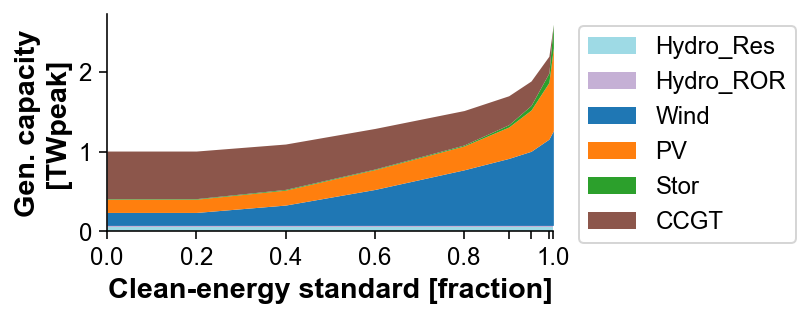

In [38]:
###### Generation capacity
plotcols = ['Hydro_Res','Hydro_ROR','CCGT','Wind','PV','Stor']
plotcols = ['Hydro_Res','Hydro_ROR','Wind','PV','Stor','CCGT',]
colorlist = [colors[i] for i in plotcols]

dfplot = {}
for i, label in enumerate(plotlabels):
    gens = dictout[barindex[label]]['cap'].index.values
    dfplot[rpss[i]] = pd.Series({
        gen: 
        dictout[barindex[plotlabels[i]]]['cap'][
            [c for c in gens if (c.startswith(gen) and not c.endswith('_E'))]
        ].sum()
        for gen in colors
    }) / 1000
dfplot = pd.DataFrame(dfplot).T

plt.close()
f,ax=plt.subplots(figsize=(4,2))
dfplot[plotcols].plot.area(ax=ax, color=colorlist, lw=0)
ax.set_xticks(rpss)
ax.set_xticklabels([0.0,0.2,0.4,0.6,0.8,'','','',1.0])
ax.set_ylabel('Gen. capacity\n[TWpeak]')
ax.set_xlabel('Clean-energy standard [fraction]')
ax.legend(loc='upper left', bbox_to_anchor=(1.03,1), fontsize='large')
ax.set_xlim(0,1)
zephyr.plots.despine(ax)
if save:
    savename = 'CES/{}-gencapacity'.format(case)
    plt.savefig(figpath+savename+'.png')
    plt.savefig(figpath+savename+'.pdf')
plt.show()

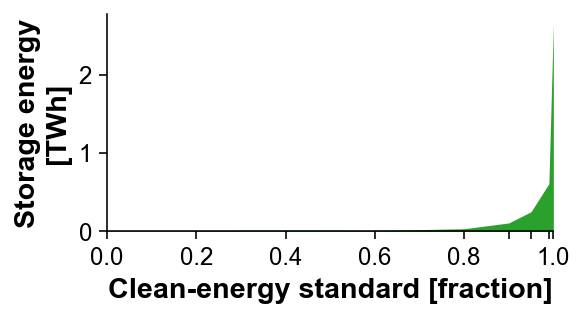

In [39]:
###### Storage capacity
dfplot = {}
dfplot = pd.Series({
    rpss[i]:
    dictout[barindex[plotlabels[i]]]['cap'][
        ['Stor_{}_E'.format(ba) for ba in bas]
    ].sum()
    for i in range(len(plotlabels))
}).rename('Storage') / 1000

plt.close()
f,ax=plt.subplots(figsize=(4,2))
dfplot.plot.area(ax=ax, color='C2', lw=0)
ax.set_xticks(rpss)
ax.set_xticklabels([0.0,0.2,0.4,0.6,0.8,'','','',1.0])
ax.set_ylabel('Storage energy\n[TWh]')
ax.set_xlabel('Clean-energy standard [fraction]')
ax.set_xlim(0,1)
zephyr.plots.despine(ax)
if save:
    savename = 'CES/{}-storcapacity'.format(case)
    plt.savefig(figpath+savename+'.png')
    plt.savefig(figpath+savename+'.pdf')
plt.show()

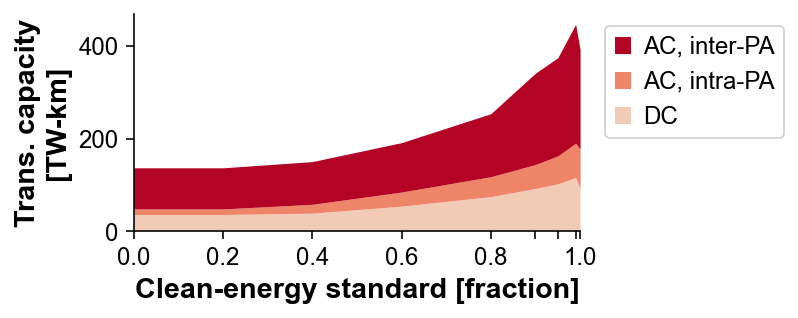

In [40]:
###### Transmission capacity
lines = [c for c in dictout[barindex['default']]['cap'].index.values if '|' in c]
lines = {
    x: [c for c in lines if c.endswith(x)]
    for x in ['dc_old', 'ac_old', 'dc_new', 'ac_new']
}
df = {}
for i, label in enumerate(plotlabels):
    df[rpss[i]] = pd.Series({
        line: 
        (dictout[barindex[label]]['cap'][lines[line]].index.map(
            lambda x: dfdistance.loc[x.split('|')[0], x.split('_')[0].split('|')[1]]
        ).values * dictout[barindex[label]]['cap'][lines[line]]
        ).sum() / 1000
        for line in lines
    })
    df[rpss[i]] = pd.Series({'dc': df[rpss[i]][['dc_old','dc_new']].sum(),
                             'ac_intraba': 0,
                             'ac_interba': df[rpss[i]][['ac_old','ac_new']].sum()})
    ### Intra-BA
    df[rpss[i]]['ac_intraba']= sum(
        [dictout[barindex[label]]['cap'][
            [c for c in dictout[barindex[label]]['cap'].index
             if (c.startswith('PV_{}'.format(ba)) or c.startswith('Wind_{}'.format(ba)))]
        ].sum() * intraba_adder[ba]
        for ba in bas]
    )
dfplot = pd.concat(df,axis=1).T

bc = {'ac_interba': plt.cm.coolwarm(1.0), 'ac_intraba': plt.cm.coolwarm(0.8), 
      'dc': plt.cm.coolwarm(0.6)}
colorlist = [bc[c] for c in ['dc','ac_intraba','ac_interba']]
legendlabels = {'dc': 'DC', 'ac_intraba': 'AC, intra-PA',
                'ac_interba': 'AC, inter-PA'}
plotcols = ['dc','ac_intraba','ac_interba']

plt.close()
f,ax=plt.subplots(figsize=(4,2))
dfplot[plotcols].plot.area(ax=ax, color=colorlist, lw=0)
ax.set_xticks(rpss)
ax.set_xticklabels([0.0,0.2,0.4,0.6,0.8,'','','',1.0])
ax.set_ylabel('Trans. capacity\n[TW-km]')
ax.set_xlabel('Clean-energy standard [fraction]')
ax.set_xlim(0,1)
# ax.legend(loc='upper left', bbox_to_anchor=(1,1))
zephyr.plots.despine(ax)
### Legend (by hand)
handles = [
    mpl.patches.Patch(facecolor=bc[i], edgecolor='none', label=legendlabels[i])
    for i in bc
]
leg = ax.legend(
    handles=handles,loc='upper left',bbox_to_anchor=(1.03,1),fontsize='large',
    frameon=True, handletextpad=0.5, handlelength=0.65,
)
if save:
    savename = 'CES/{}-transcapacity'.format(case)
    plt.savefig(figpath+savename+'.png')
    plt.savefig(figpath+savename+'.pdf')
plt.show()

In [41]:
###### Dispatched energy
plotcols = ['Stor','Hydro_Res','Hydro_ROR','Wind','PV','CCGT',]
colorlist = [colors[i] for i in plotcols]

### Generated energy
dfplot = {}
for i, label in enumerate(plotlabels):
    gens = dictout[barindex[label]]['energy'].index.values
    dfplot[rpss[i]] = pd.Series({
        gen: 
        dictout[barindex[plotlabels[i]]]['energy'][
            [c for c in gens if (c.startswith(gen) and not (
                c.endswith('_charge') or c.endswith('_all') or c.endswith('_spill')
                or (gen == 'Stor' and c.endswith('_power'))
                or c.endswith('_energy')
#                 or c.endswith('_power')
            ))]
        ].sum()
        for gen in plotcols
    }) / 7E6
dfplot = pd.DataFrame(dfplot).T

### Transmission losses
tcols = [c for c in dictout[barindex['default']]['energy'].index if '|' in c]
translosses = {}
for i, label in enumerate(plotlabels):
    tlosses = []
    for c in tcols:
        node1 = c.split('|')[0]
        node2 = c.split('|')[1].split('_')[0]
        linetype = c.split('_')[1]
        tlosses.append(
            abs(dictout[barindex[label]]['energy'][c]) 
            * dfdistance.loc[node1,node2] * loss_distance[linetype]
        )
    translosses[label] = sum(tlosses) / 7E6
translosses = pd.Series(translosses)

storcharge = -pd.Series({
    label: sum(
        [dictout[barindex[label]]['energy']['Stor_{}_charge'.format(ba)] for ba in bas]
    ) / 7E6
    for label in plotlabels
})

negvals = -(translosses + storcharge)
negvals.index = rpss

dfcum = (dfplot.T.cumsum() + negvals).T

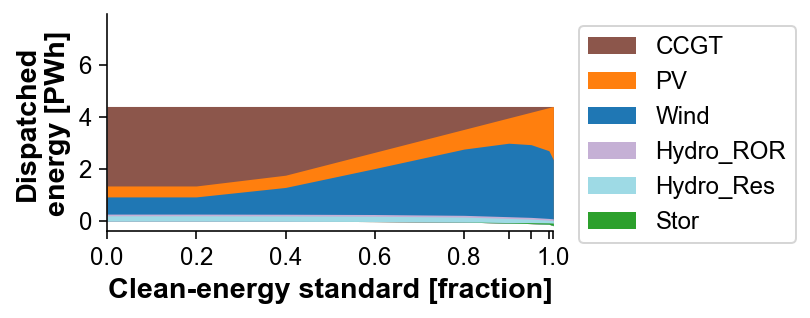

In [42]:
plt.close()
f,ax=plt.subplots(figsize=(4,2))
for col in plotcols[::-1]:
    ax.fill_between(rpss, dfcum[col].values, negvals, color=colors[col], lw=0, label=col)
#     dfcum[plotcols].plot.area(ax=ax, color=colorlist, lw=0)
ax.set_xticks(rpss)
ax.set_xticklabels([0.0,0.2,0.4,0.6,0.8,'','','',1.0])
ax.set_ylabel('Dispatched\nenergy [PWh]')
ax.set_xlabel('Clean-energy standard [fraction]')
ax.set_xlim(0,1)
ax.set_yticks([-2,0,2,4,6,8])
ax.set_ylim(-0.4,7.95)
ax.legend(loc='upper left', bbox_to_anchor=(1.03,1), fontsize='large')
zephyr.plots.despine(ax)
if save:
    savename = 'CES/{}-energydispatch'.format(case)
    plt.savefig(figpath+savename+'.png')
    plt.savefig(figpath+savename+'.pdf')
plt.show()

In [43]:
###### Available energy

plotcols = ['Stor','Hydro_Res','Hydro_ROR','Wind','PV','CCGT',]
colorlist = [colors[i] for i in plotcols]

### Generated energy
dfplot = {}
for i, label in enumerate(plotlabels):
    gens = dictout[barindex[label]]['energy'].index.values
    dfplot[rpss[i]] = pd.Series({
        gen: 
        dictout[barindex[plotlabels[i]]]['energy'][
            [c for c in gens if (c.startswith(gen) and not (
                c.endswith('_charge') or c.endswith('_all')
                or (gen == 'Stor' and c.endswith('_power'))
                or c.endswith('_energy')
#                 or c.endswith('_power')
            ))]
        ].sum()
        for gen in plotcols
    }) / 7E6
dfplot = pd.DataFrame(dfplot).T

### Transmission losses
tcols = [c for c in dictout[barindex['default']]['energy'].index if '|' in c]
translosses = {}
for i, label in enumerate(plotlabels):
    tlosses = []
    for c in tcols:
        node1 = c.split('|')[0]
        node2 = c.split('|')[1].split('_')[0]
        linetype = c.split('_')[1]
        tlosses.append(
            abs(dictout[barindex[label]]['energy'][c]) 
            * dfdistance.loc[node1,node2] * loss_distance[linetype]
        )
    translosses[label] = sum(tlosses) / 7E6
translosses = pd.Series(translosses)

storcharge = -pd.Series({
    label: sum(
        [dictout[barindex[label]]['energy']['Stor_{}_charge'.format(ba)] for ba in bas]
    ) / 7E6
    for label in plotlabels
})

negvals = -(translosses + storcharge)
negvals.index = rpss

###### Replace dispatchable with capacity * CF
### PV
dfplot['PV'] = [sum([
    dictout[barindex[label]]['cap']['PV_{}_0'.format(ba)] * casehours[case] * cfpvyear[ba,caseyear[case]] 
    for ba in bas for case in yearindices[label]]) / 7E6
 for label in plotlabels]

### Wind
windbins = [0,1,2,3,4]
dfplot['Wind'] = [sum([
    (dictout[barindex[label]]['cap']['Wind_{}_{}'.format(ba,windbin)] * casehours[case] 
     * cfwindyear[ba,cases.loc[case,'wind_model'],caseyear[case]][windbin]
    ) for windbin in windbins for ba in bas for case in yearindices[label]]) / 7E6
 for label in plotlabels]

### Gas
dfplot['CCGT'] = [sum([
    dictout[barindex[label]]['cap']['CCGT_{}'.format(ba)] * casehours[case] * 1
    if label != 'default' else 0
    for ba in bas for case in yearindices[label]]) / 7E6
 for label in plotlabels]

dfcum = (dfplot.T.cumsum() + negvals).T

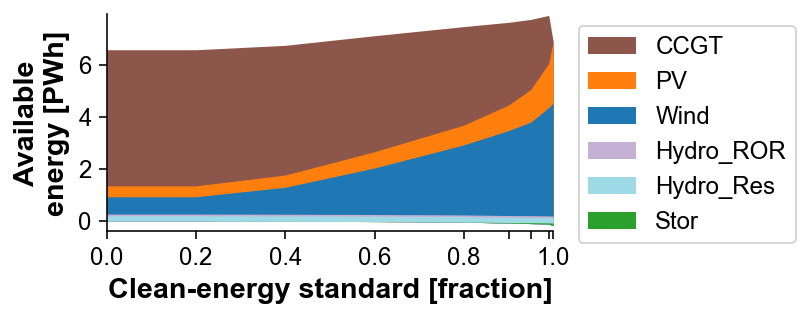

In [44]:
plt.close()
f,ax=plt.subplots(figsize=(4,2))
for col in plotcols[::-1]:
    ax.fill_between(rpss, dfcum[col].values, negvals, color=colors[col], lw=0, label=col)
#     dfcum[plotcols].plot.area(ax=ax, color=colorlist, lw=0)
# ax.plot([1],[dfcum.iloc[-1,-1]],marker=0,lw=0,c='k',ms=5)
ax.set_xticks(rpss)
ax.set_xticklabels([0.0,0.2,0.4,0.6,0.8,'','','',1.0])
ax.set_ylabel('Available\nenergy [PWh]')
ax.set_xlabel('Clean-energy standard [fraction]')
ax.set_xlim(0,1)
ax.set_yticks([-2,0,2,4,6,8])
ax.set_ylim(-0.4,7.95)
ax.legend(loc='upper left', bbox_to_anchor=(1.03,1), fontsize='large')
zephyr.plots.despine(ax)
if save:
    savename = 'CES/{}-energyavailable'.format(case)
    plt.savefig(figpath+savename+'.png')
    plt.savefig(figpath+savename+'.pdf')
plt.show()

In [45]:
colors = {
    ('Hydro_Res','',''): plt.cm.tab20(19),
    ('Hydro_ROR','',''): plt.cm.tab20(9),
    ('PHS','',''): plt.cm.tab20(14),
    ('Lostload','',''): plt.cm.tab20(15),
    ('Nuclear','','_old'): plt.cm.tab20(13),
    ('Nuclear','','_new'): plt.cm.tab20(13),
    ('Wind','gen',''): plt.cm.tab20(0),
    ('Wind','interconnection',''): '0.4',
    ('Wind','interstate',''): 'k',
    ('PV','gen',''): plt.cm.tab20(2),
    ('PV','interconnection',''): '0.4',
    ('PV','interstate',''): 'k',
    ('Stor','',''): plt.cm.tab20(4),
    ('CCGT','',''): plt.cm.tab20(10),
    ('OCGT','',''): plt.cm.tab20(16),
    ('','|',''): 'k',
}

plotorder = [
    'Hydro_Res','Hydro_ROR',
    'Wind_gen','PV_gen',
    'Stor',
    'CCGT',
    'Wind_interconnection','PV_interconnection',
    'Wind_interstate','PV_interstate',
    'Inter-zone trans.',
]

colorlist = [colors[c] for c in [
    ('Hydro_Res','',''),('Hydro_ROR','',''),
    ('Wind','gen',''),('PV','gen',''),
    ('Stor','',''),
    ('CCGT','',''),
    ('Wind','interconnection',''),('PV','interconnection',''),
    ('Wind','interstate',''),('PV','interstate',''),
    ('','|',''),
]]

legendcolors = {
    'Hydro (Res)': plt.cm.tab20(19),
    'Hydro (ROR)': plt.cm.tab20(9),
    'Wind': plt.cm.tab20(0),
    'PV': plt.cm.tab20(2),
    'Storage': plt.cm.tab20(4),
    'CCGT': plt.cm.tab20(10),
    'Interconnection': '0.4',
    'Inter-state trans.': 'k',
}

In [46]:
legendcolors = {
    'Hydro (Res)': plt.cm.tab20(19),
    'Hydro (ROR)': plt.cm.tab20(9),
    'Wind': plt.cm.tab20(0),
    'PV': plt.cm.tab20(2),
    'Storage': plt.cm.tab20(4),
    'CCGT': plt.cm.tab20(10),
    'Interconnection': '0.4',
    'Inter-state trans.': 'k',
}
legendcolors = {
    'Inter-state trans.': 'k',
    'Interconnection': '0.4',
    'CCGT': plt.cm.tab20(10),
    'Storage': plt.cm.tab20(4),
    'PV': plt.cm.tab20(2),
    'Wind': plt.cm.tab20(0),
    'Hydro (ROR)': plt.cm.tab20(9),
    'Hydro (Res)': plt.cm.tab20(19),
}

In [47]:
###### SCOE breakdown
df = {}
for i, label in enumerate(plotlabels):
    ###### Get the interconnection costs
    pv_trans_cost_adder = pv_trans_cost
    wind_trans_cost_adder = wind_trans_cost
    scaler = 1
        
    ###### Continue
    case = barindex[label]
    dictplot = {}
    gens = dictout[case]['cost'].index.values
    dfplot = pd.Series({
        '{}{}{}'.format(*gen): 
        dictout[case]['cost'][
            [c for c in gens if (
                c.startswith(gen[0]) and (gen[1] in c) and c.endswith(gen[2]))]
        ].sum() / dictout[case]['values']['loadsum'] * 1000
        for gen in colors
    })
    ### Rewrite the components
    ### Unchanged components
    for gen in ['Hydro_Res','Hydro_ROR','Stor','Lostload','Nuclear_old','Nuclear_new','CCGT','OCGT','PHS']:
        if gen in dfplot.index:
            dictplot[gen] = dfplot[gen]
        else:
            pass
    dictplot['Inter-zone trans.'] = dfplot['|']
    ###### PV, wind
    gens = dictout[case]['cap'].index.values
    ### PV
    foo = defaults.params_generators[cases.loc[case,'pv']]
    dictplot['PV_gen'] = sum([
        dictout[case]['cap']['PV_{}_{}'.format(ba,pvbin)] * 7 * (
            foo['cost_capex'] * (
                zephyr.capaxl.crf(cases.loc[case,'wacc_gen'],foo['lifetime'])
                if not np.isnan(cases.loc[case,'wacc_gen']) else foo['CRF'])
         + foo['cost_fom'])
        for ba in bas for pvbin in pvbins
    ]) / dictout[case]['values']['loadsum'] * 1000
    dictplot['PV_interconnection'] = sum([
        dictout[case]['cap']['PV_{}_{}'.format(ba,pvbin)] * pv_trans_cost_adder[ba,pvbin] * 7
        for ba in bas for pvbin in pvbins
    ]) / dictout[case]['values']['loadsum'] * 1000
    dictplot['PV_interstate'] = sum([
        dictout[case]['cap']['PV_{}_{}'.format(ba,pvbin)] * transcost_adder[ba] * 7 * scaler
        for ba in bas for pvbin in pvbins
    ]) / dictout[case]['values']['loadsum'] * 1000
    ### Wind
    foo = defaults.params_generators[cases.loc[case,'wind']]
    dictplot['Wind_gen'] = sum([
        dictout[case]['cap']['Wind_{}_{}'.format(ba,windbin)] * 7 * (
            foo['cost_capex'] * (
                zephyr.capaxl.crf(cases.loc[case,'wacc_gen'],foo['lifetime'])
                if not np.isnan(cases.loc[case,'wacc_gen']) else foo['CRF'])
         + foo['cost_fom'])
        for ba in bas for windbin in windbins
    ]) / dictout[case]['values']['loadsum'] * 1000
    dictplot['Wind_interconnection'] = sum([
        dictout[case]['cap']['Wind_{}_{}'.format(ba,windbin)] * wind_trans_cost_adder[ba,windbin] * 7
        for ba in bas for windbin in windbins
    ]) / dictout[case]['values']['loadsum'] * 1000
    dictplot['Wind_interstate'] = sum([
        dictout[case]['cap']['Wind_{}_{}'.format(ba,windbin)] * transcost_adder[ba] * 7 * scaler
        for ba in bas for windbin in windbins
    ]) / dictout[case]['values']['loadsum'] * 1000
    
    dfframe = pd.Series(dictplot)[plotorder]
    df[rpss[i]] = dfframe

outcols = ['Hydro_Res','Hydro_ROR','Wind_gen','PV_gen','Stor','CCGT',
           'Wind_interconnection','PV_interconnection','Wind_interstate','PV_interstate',
           'Inter-zone trans.']
dfplot = pd.DataFrame(df).T[outcols]

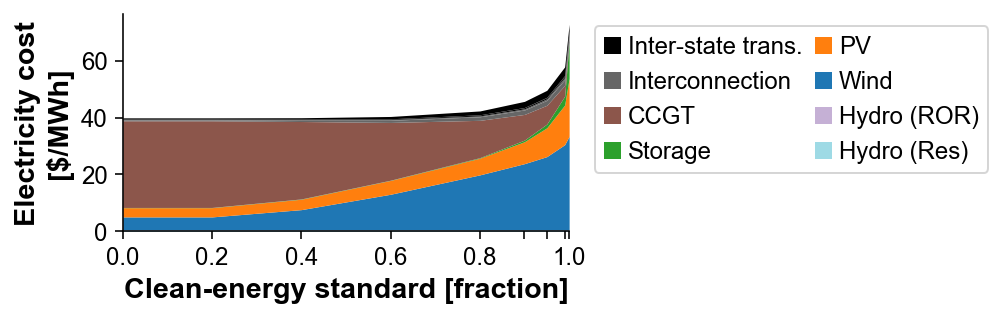

In [48]:
plt.close()
f,ax=plt.subplots(figsize=(4,2))
dfplot[plotorder].plot.area(ax=ax, color=colorlist, lw=0)
ax.set_xticks(rpss)
ax.set_xticklabels([0.0,0.2,0.4,0.6,0.8,'','','',1.0])
ax.set_ylabel('Electricity cost\n[$/MWh]')
ax.set_xlabel('Clean-energy standard [fraction]')
ax.set_xlim(0,1)
# ax.legend(loc='upper left', bbox_to_anchor=(1.03,1), fontsize='large')
### Legend (by hand)
handles = [
    mpl.patches.Patch(facecolor=legendcolors[i], edgecolor='none', label=i)
    for i in legendcolors
]
leg = ax.legend(
    handles=handles,loc='upper left',bbox_to_anchor=(1.03,1),fontsize='large',
    frameon=True, handletextpad=0.3, handlelength=0.7,#0.7
    columnspacing=0.5, ncol=2, 
)
zephyr.plots.despine(ax)
if save:
    savename = 'CES/{}-SCOE'.format(case)
    plt.savefig(figpath+savename+'.png')
    plt.savefig(figpath+savename+'.pdf')
plt.show()

# Operation

In [49]:
# ### Load some 7-year solutions
# inpath = regeopath+'out/capaxl/20200701-transvom025/'
# infiles = sorted(glob(inpath+'results/*'))[::-1]
# infiles = [f for f in infiles if (('WRONG' not in f) and ('gurobipy' not in f))]
# dictops = {}
# for infile in tqdm(infiles):
#     case_state = os.path.basename(infile).split('.')[0]
#     ### Filter out side analyses
#     if (('t002' in case_state) or ('gurobipy' in case_state)):
#         continue
#     case = int(case_state.split('-')[0])
# #     if case not in [7,15,23,919,607,551,527]:
# #     if case not in (list(range(24)) + list(range(520,528)) + list(range(912,920))
# #                     + list(range(600,608)) + list(range(544,552))):
# #         continue
#     region = case_state.split('-')[1]
#     with gzip.open(infile, 'rb') as p:
#         (dictout_cap, dictout_op, dictout_values, system) = pickle.load(p)
    
#     intup = get_dfout(
#         dictout_cap=dictout_cap, dictout_op=dictout_op, dictout_values=dictout_values, 
#         system=system, periods=[0], nodes=bas, years=len(caseyear[case].split(',')))
#     dictops[case] = intup[1][0]

In [50]:
dfops = pd.read_csv(
    os.path.join(projpath,'results','transvom-operation.csv.gz'),
    index_col=[0], header=[0,1], parse_dates=True
)
dictops = {int(i): dfops[i] for i in dfops.T.reset_index(level=0).level_0.unique()}

In [51]:
case = 7   ### no new transmission
case = 23  ### default (new AC and DC)
opindex = pd.date_range(
    '2007-01-01','2013-12-31',closed='left',freq='H',tz=tz)
opindex = [i for i in opindex if not ((i.month==2) and (i.day==29))]
dfplot = dictops[case].copy()
dfplot.index = opindex

In [52]:
### Aggregate zonal VRE
pvbins = [0]
windbins = [0,1,2,3,4]
for ba in bas:
    dfplot['PV_{}'.format(ba)] = dfplot[['PV_{}_{}'.format(ba,pvbin) for pvbin in pvbins]].sum(axis=1)
    dfplot['Wind_{}'.format(ba)] = dfplot[['Wind_{}_{}'.format(ba,windbin) for windbin in windbins]].sum(axis=1)

In [53]:
### Find week with largest reliance on storage
df = dfplot[[i for i in dfplot.columns if i.startswith('Stor') and i.endswith('_discharge')]].sum(axis=1)
df.groupby([df.index.year,df.index.week]).mean().nlargest(5)

/Users/patrickbrown/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  This is separate from the ipykernel package so we can avoid doing imports until


2010  27    67.975595
2007  31    62.464286
      35    58.015476
2011  27    57.746429
2008  33    56.993452
dtype: float64

In [54]:
### Find week with largest demand
df = dfplot[[i for i in dfplot.columns if i.startswith('Load')]].sum(axis=1)
df.groupby([df.index.year,df.index.week]).mean().nlargest(5)

/Users/patrickbrown/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  This is separate from the ipykernel package so we can avoid doing imports until


2007  30    622.130357
2012  30    622.130357
2011  31    620.367262
2010  31    620.302381
2009  32    620.165476
dtype: float64

In [55]:
### Find week with lowest demand
df = dfplot[[i for i in dfplot.columns if i.startswith('Load')]].sum(axis=1)
df.groupby([df.index.year,df.index.week]).mean().nsmallest(5)

/Users/patrickbrown/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  This is separate from the ipykernel package so we can avoid doing imports until


2009  15    437.183929
2008  15    437.464881
2010  14    437.694643
2011  14    439.460714
2013  15    439.812500
dtype: float64

In [56]:
# plottime = slice('2011-07-04','2011-07-10')
startdate = '20110723'
plottime = slice('2011-07-23','2011-07-29')

In [57]:
colordict = {
    'Hydro_Res': plt.cm.tab20(19),
    'Hydro_ROR': plt.cm.tab20(9),
    'PHS': plt.cm.tab20(15),
    'Nuclear': plt.cm.tab20(13),
    # 'Nuclear': plt.cm.tab20(12),
    'Wind': plt.cm.tab20(0),
    'PV': plt.cm.tab20(2),
    'Stor': plt.cm.tab20(4), #'Stor_charge': plt.cm.tab20(4), 'Stor_discharge': plt.cm.tab20(4),
    'CCGT': plt.cm.tab20(10),
    'OCGT': plt.cm.tab20(16),
    # 'Trans': plt.cm.binary(1000),
#     'Trans': plt.cm.tab10(7),
    'Trans': '0.7',
    'Trans': plt.cm.tab20(6), #6
}
# colorlist = [colordict[c] for c in colordict]

def colors(col,colordict=colordict):
    for key in colordict:
        if col.startswith(key):
            return colordict[key]
    return colordict['Trans']

legendcolors = {
    'Hydro (Res)': plt.cm.tab20(19),
    'Hydro (ROR)': plt.cm.tab20(9),
    # 'PHS': plt.cm.tab20(15),
    # 'Nuclear': plt.cm.tab20(13),
    'Wind': plt.cm.tab20(0),
    'PV': plt.cm.tab20(2),
    'Storage': plt.cm.tab20(4),
    # 'CCGT': plt.cm.tab20(10),
#     'Transmission': plt.cm.tab10(7),
#     'Transmission': '0.7',
    'Transmission': plt.cm.tab20(6), #6
}
legendlabels = {
    'Hydro_Res': 'Hydro (Res)', 'Hydro_ROR': 'Hydro (ROR)',
    'Wind': 'Wind', 'PV': 'PV', 'Stor': 'Storage',
    'Trans': 'Transmission'
}

### BAs

23 default


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


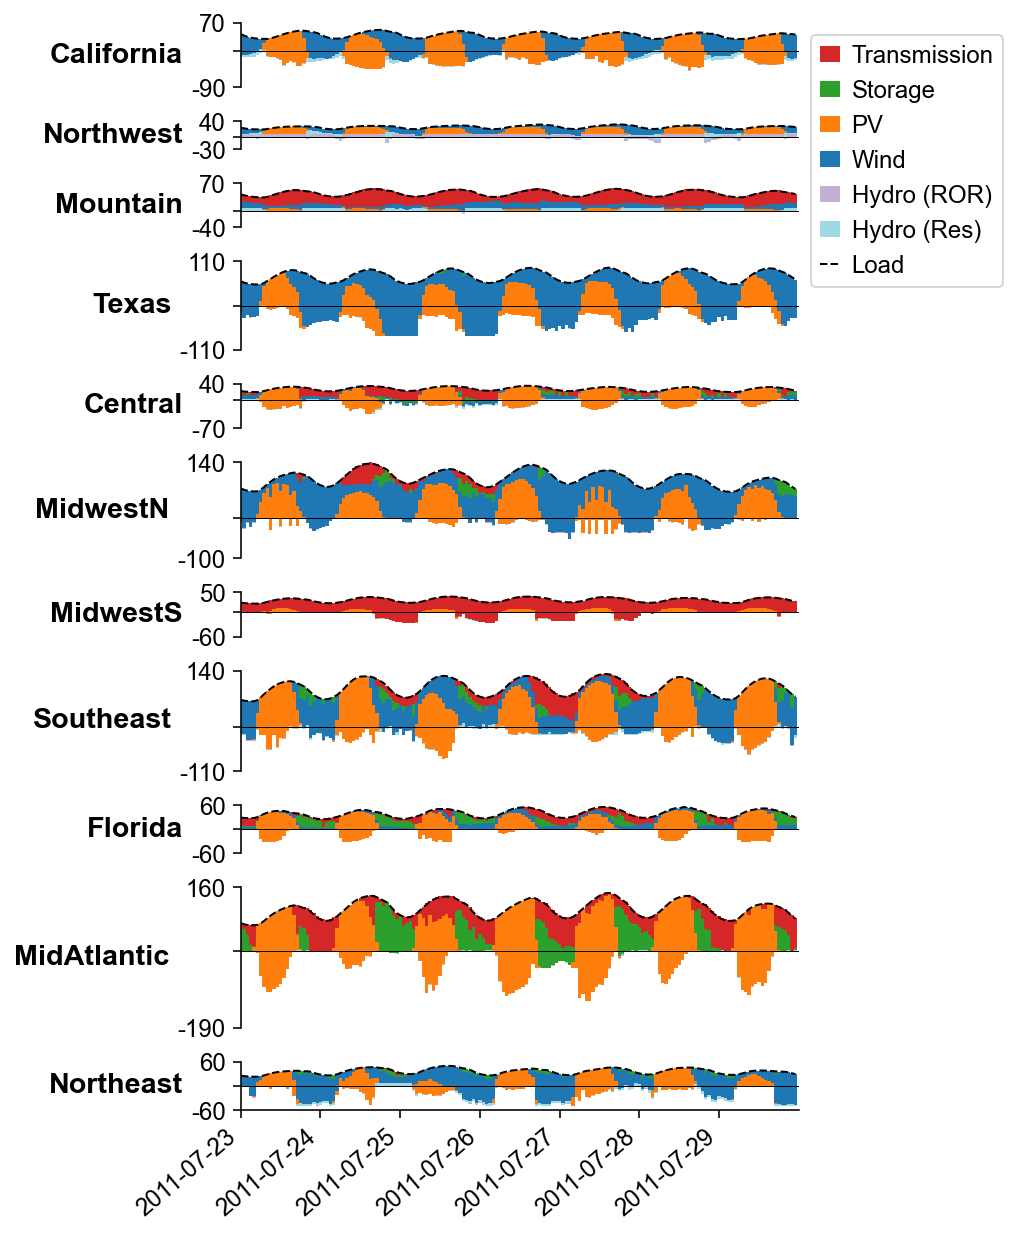

In [58]:
### Specify ranges and height scalers
### Don't show transmission / storage below 0
dfplot = dictops[case].copy()
dfplot.index = opindex
### Aggregate zonal VRE
pvbins = [0]
windbins = [0,1,2,3,4]
for ba in bas:
    dfplot['PV_{}'.format(ba)] = dfplot[['PV_{}_{}'.format(ba,pvbin) for pvbin in pvbins]].sum(axis=1)
    dfplot['Wind_{}'.format(ba)] = dfplot[['Wind_{}_{}'.format(ba,windbin) for windbin in windbins]].sum(axis=1)
ylims = {
    'California':  [-90,70],
    'Central':     [-70,40],
    'Florida':     [-60,60],
    'MidAtlantic': [-190,160],
    'MidwestN':    [-100,140],
    'MidwestS':    [-60,50],
    'Mountain':    [-40,70],
    'Northeast':   [-60,60],
    'Northwest':   [-30,40],
    'Southeast':   [-110,140],
    'Texas':       [-110,110],
}
height_ratios = [ylims[ba][1] - ylims[ba][0] for ba in bas]

### Plot it
print(case, cases.loc[case,'notes'])
plt.close()
### normally (5,10)
f,ax=plt.subplots(len(bas),1,figsize=(5,10),sharex=True,
                  gridspec_kw={'height_ratios':height_ratios, 'hspace':0.5})
for row, ba in enumerate(bas):
    ### Get columns
    transcols = [i for i in dfplot.columns if (('|' in i) and (ba in i))]
    transoutcols = [
        i for i in transcols if (
            (i.startswith(ba) and i.endswith('_pos'))
            or ((i.split('|')[1].split('_')[0] == ba) and i.endswith('_neg'))
        )
    ]
    transincols = [i for i in transcols if i not in transoutcols]
    dfplot.loc[:,transoutcols] = -abs(dfplot.loc[:,transoutcols])
    dfplot.loc[:,transincols] = abs(dfplot.loc[:,transincols])
    negcols = transoutcols + ['Stor_{}_charge'.format(ba)]
    poscols = (['Hydro_ROR_{}'.format(ba)] if 'Hydro_ROR_{}'.format(ba) in dfplot.columns else []) + [
        'Hydro_Res_{}_power'.format(ba),
        'PV_{}'.format(ba),
        'Wind_{}'.format(ba),
        'Stor_{}_discharge'.format(ba),
    ] + transincols
    plotcols = poscols # + negcols
    colorlist = [colors(c) for c in plotcols]
#     ### Subtract the negative columns
#     dfplot[poscols[0]] = dfplot[poscols[0]] + dfplot[negcols].sum(axis=1)
    ### Plot it, barwise
    for timestamp in dfplot.loc[plottime].index:
        start = dfplot.loc[timestamp,negcols].sum()
        height = dfplot.loc[timestamp,plotcols].copy()
        bottom = height.cumsum() + start
        ax[row].bar(
            x=[timestamp]*len(bottom), 
            bottom=bottom.values,
            height=-height.values,
            width=1/24, color=colorlist, lw=0,
        )
#     dfplot.loc[plottime,'Load_{}'.format(ba)].plot(ax=ax[row],c='k',ls='--',lw=1)
    ax[row].plot(
        dfplot.loc[plottime].index, dfplot.loc[plottime,'Load_{}'.format(ba)],
        c='k',ls='--',lw=1)
    ### Formatting
    ax[row].set_ylabel(ba,rotation=0,ha='right',va='center')
    ax[row].legend().set_visible(False)
    ax[row].axhline(0,c='k',lw=0.5,ls='-')
    ax[row].set_ylim(*ylims[ba])
    ax[row].set_yticks([ylims[ba][0], 0, ylims[ba][1]])
    ax[row].set_yticklabels([ylims[ba][0], '', ylims[ba][1]])
ax[0].set_xlim('2011-07-23 00:00:00-06:00','2011-07-29 23:59:59-06:00')
ax[0].xaxis.set_minor_locator(AutoMinorLocator(1))
# ax[0].set_xticks(ax[0].get_xticks())
# ax[0].set_xticklabels(
#     [i._text for i in ax[-1].get_xticklabels()], 
#     rotation=30, ha='right', rotation_mode='anchor',
# )
### Legend (by hand)
handles = [
    mpl.lines.Line2D([0],[0],c='k',ls='--',lw=1,label='Load'),
] + [
    mpl.patches.Patch(facecolor=colordict[i], edgecolor='none', label=legendlabels[i])
    for i in colordict if i not in ['PHS','Nuclear','CCGT','OCGT']
]
leg = ax[0].legend(
    handles=handles[::-1],loc='upper left',bbox_to_anchor=(1,1),fontsize='large',
    frameon=True, handletextpad=0.5, handlelength=0.8,
)
for row in range(len(bas)-1):
    zephyr.plots.despine(ax[row],bottom=False)
zephyr.plots.despine(ax[-1])
for label in ax[-1].get_xticklabels():
    label.set_rotation(40)
    label.set_horizontalalignment('right')
if save:
    savename = 'ba-1weekdispatch-{}-{}'.format(startdate,case)
    plt.savefig(figpath+savename+'.png')
    plt.savefig(figpath+savename+'.pdf')
plt.show()

### Just legend

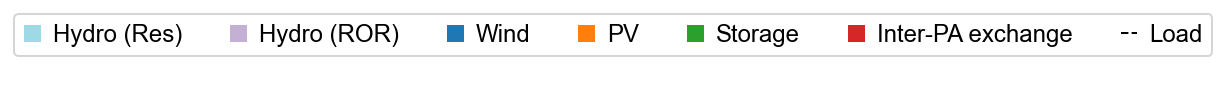

In [59]:
colordict = {
    'Hydro_Res': plt.cm.tab20(19),
    'Hydro_ROR': plt.cm.tab20(9),
    'PHS': plt.cm.tab20(15),
    'Nuclear': plt.cm.tab20(13),
    # 'Nuclear': plt.cm.tab20(12),
    'Wind': plt.cm.tab20(0),
    'PV': plt.cm.tab20(2),
    'Stor': plt.cm.tab20(4),
    'CCGT': plt.cm.tab20(10),
    'OCGT': plt.cm.tab20(16),
    # 'Trans': plt.cm.binary(1000),
#     'Trans': plt.cm.tab10(7),
    'Trans': '0.7',
    'Trans': plt.cm.tab20(6), #6
}
# colorlist = [colordict[c] for c in colordict]

def colors(col,colordict=colordict):
    for key in colordict:
        if col.startswith(key):
            return colordict[key]
    return colordict['Trans']

legendcolors = {
    'Hydro (Res)': plt.cm.tab20(19),
    'Hydro (ROR)': plt.cm.tab20(9),
    # 'PHS': plt.cm.tab20(15),
    # 'Nuclear': plt.cm.tab20(13),
    'Wind': plt.cm.tab20(0),
    'PV': plt.cm.tab20(2),
    'Storage': plt.cm.tab20(4),
    # 'CCGT': plt.cm.tab20(10),
#     'Transmission': plt.cm.tab10(7),
#     'Transmission': '0.7',
    'Transmission': plt.cm.tab20(6), #6
}
legendlabels = {
    'Hydro_Res': 'Hydro (Res)', 'Hydro_ROR': 'Hydro (ROR)',
    'Wind': 'Wind', 'PV': 'PV', 'Stor': 'Storage',
    'Trans': 'Inter-PA exchange'
}

### Specify ranges and height scalers
ylims = {
    'California':  [-90,140],
    'Northwest':   [-30,60],
    'Mountain':    [-40,100],
    'Texas':       [-110,190],
    'Central':     [-70,100],
    'MidwestN':    [-100,200],
    'MidwestS':    [-60,100],
    'Southeast':   [-110,210],
    'Florida':     [-60,110],
    'MidAtlantic': [-190,290],
    'Northeast':   [-60,110],
}

### Plot it
plt.close()
f,ax=plt.subplots(figsize=(0.1,0.1))
### Legend (by hand)
handles = [
    mpl.patches.Patch(facecolor=colordict[i], edgecolor='none', label=legendlabels[i])
    for i in colordict
    if i not in ['PHS','Nuclear','CCGT','OCGT']
] + [
    mpl.lines.Line2D([0],[0],c='k',ls='--',lw=1,label='Load'),
]
leg = ax.legend(
    handles=handles[::],loc='lower center',bbox_to_anchor=(0.5,1.05),fontsize='large',
    frameon=True, handletextpad=0.5, handlelength=0.7, ncol=len(handles),
)
plt.axis('off')
if save:
    savename = 'ba-dispatch-legend'
    plt.savefig(figpath+savename+'.png')
    plt.savefig(figpath+savename+'.pdf')
plt.show()